Github version of this notebook can be viewed at http://nbviewer.ipython.org/github/texnokrates/dicke/blob/master/ipynotebooks/dicke-qutip.ipynb.

In [40]:
import profile
import memory_profiler

In [1]:
%matplotlib inline

from scipy.misc import comb
import scipy.sparse as sp
from qutip import *
from itertools import combinations
import scipy.constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.matlib
import numpy
import time
import numpy.linalg
import numpy.random
import numpy as np
from scipy.constants import epsilon_0, pi
from sklearn.preprocessing import normalize
settings.auto_tidyup = False # This is essential when working in SI units

debye=3.33564e-30
eV = scipy.constants.e
nm = 1e-9

# in gs, the bigger index goes first!
# FIXME rRWA=False not implemented
def dickeH(K=2, omega=1., epsilons=1., Vs=0, gs=0, bdim=3, dRWA=True, rRWA=True):
    """Build the generalized extended Dicke Hamiltonian with
    K atoms, with the field Fock space truncated to bdim
    
    TODO doc
    """
    if (isinstance(epsilons, int) or isinstance(epsilons, float)):
        epsilons = [epsilons] * K
    if (isinstance(Vs, int) or isinstance(Vs, float)):
        Vs = [Vs] * K
    if (isinstance(gs, int) or isinstance(gs, float)):
        g = gs
        gs = []
        for j in range(K):
            gs.append([g] * j)
    sz=[]
    sp=[]
    sm=[]
    eye = tensor(K*[qeye(2)]+[qeye(bdim)])
    for i in range(K):
        sz.append(tensor(i*[qeye(2)]+[sigmaz()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
        sp.append(tensor(i*[qeye(2)]+[sigmap()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
        sm.append(tensor(i*[qeye(2)]+[sigmam()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
    bcr=tensor(K*[qeye(2)]+[create(bdim)])
    ban=tensor(K*[qeye(2)]+[destroy(bdim)])
    bnum=tensor(K*[qeye(2)]+[num(bdim)])
    H=sz[0]-sz[0] # Neumim jinak udělat nulu
    for i in range(K):
        #H += epsilons[i] * sz[i]  
        H += epsilons[i] * (sz[i] + eye)/2.
        H += Vs[i]*(bcr*sm[i] + sp[i]*ban)
    for i in range(K):
        for j in range(i):
            H += gs[i][j] * (sp[i]*sm[j] + sp[j]*sm[i])
    if (dRWA == False):
        for i in range(K):
            for j in range(i):
                H += gs[i][j] * (sp[i]*sp[j] + sm[j]*sm[i])
    H += omega * bnum
    return H


# N.B. here, n is ascending in the matrices, whereas in the text it is
# descending.

def ddim(K, tau):
    if (tau >= K):
        return 2**K
    d = 0
    for k in range(tau + 1):
        d += comb(K, k, True)
    return d
   

def i2n(i, K, tau):
    """Mapping between integers and bosonic excitation numbers.
    
    Returns the bosonic excitation number n, corresponding to the state
    with the index i (described in i2c)...
    """
    n = max(0, tau - K)
    base = 0
    nxt = comb(K, tau - n, True)
    while (i >= nxt):
        n += 1
        base = nxt
        nxt += comb(K, tau - n, True)
        if (base == nxt):
            print "i2n(",i,",",K,",",tau,"): invalid argument"
            return None
    return n


def i2m(i, K, tau):
    """Mapping between integers and lists of excited atoms.
    
    Returns a list m of excited atoms in the state (n,m),
    which is the i-th such state from the subspace with
    K atoms and total excitation number tau, in lexicographic
    order.
    
    The lowest possible i is 0.
    """
    #The whole code deserves some dynamic approach
    #determine atomic excitation number (tau - n)
    n = max(0, tau - K)
    base = 0
    nxt = comb(K, tau - n, True)
    while (i >= nxt):
        n += 1
        base = nxt
        nxt += comb(K, tau - n, True)
        if (base == nxt):
            print "i2m(",i,",",K,",",tau,"): invalid argument"
            return None
    # generate the combinations
    j = base
    for m in combinations(range(K), tau - n):
        if (j == i):
            return m
        j += 1
    raise
    
def i2nm(i, K, tau):
    return (i2n(i, K, tau), i2m(i, K, tau))

def nm2i(n, m, K):
    """Mapping excitation combinations to integer index."""
    m = tuple(sorted(m))
    tau = len(m) + n
    base = 0
    for nn in range(max(0,tau - K), n):
        base += comb(K, tau - nn, True)
    i = base
    for mm in combinations(range(K), len(m)):
        if(m == mm):
            return i
        else:
            i += 1
    else:
        raise
        
def tau_projector_sparse(K, tau, bdim):
    """Returns a matrix which restricts dickeH Hamiltonian to a single excitation subspace."""
    # TODO kontrola bdim vs tau
    newdim = ddim(K, tau)
    fulldim = 2**K * bdim
    i = range(newdim)
    data = [1]*newdim 
    j = []   
    for ii in range(newdim):
        n, m = i2nm(ii, K, tau) 
        setm = set(m)
        vect = []
        jj = 0
        for k in range(K):
            jj += bdim * 2**k * (1-(k in setm)) # 0 is up, 1 is down
        jj += n
        j.append(jj)
    return sp.coo_matrix((np.array(data), 
                          (np.array(i),np.array(j))), 
                          shape=(newdim, fulldim))

def tau_projector_Qobj(K, tau, bdim):
    return Qobj(tau_projector_sparse(K,tau,bdim).tocsr(), dims=[[ddim(K,tau)],[2]*K+[bdim]])
    
def tau_projector(K, tau, bdim):
    """Returns a matrix which restricts dickeH Hamiltonian to a single excitation subspace."""
    return tau_projector_sparse(K, tau, bdim).todense()
        
    
def dickeH_proj_Qobj(K=2, omega=1., epsilons=1., Vs=0, gs=0, tau=1):
    """Like dickeH, but restricted to a constant excitation number tau."""
    bdim = tau + 1
    proj = tau_projector_Qobj(K, tau, bdim)
    H = dickeH(K=K, omega=omega, epsilons=epsilons, Vs=Vs, gs=gs, bdim=bdim)
    return proj * H * proj.dag()

def dickeH_proj(K=2, omega=1., epsilons=1., Vs=0, gs=0, tau=1):
    return dickeH_proj_Qobj(K=K, omega=omega, epsilons=epsilons,
                           Vs=Vs, gs=gs, tau=tau).full()

    
def randomPositionBox(K=10, x=10*nm, y=10*nm, z=5*nm):
    return numpy.random.rand(K, 3) * numpy.array([x,y,z])

def randomUnitVectors(K=10):
    return normalize(numpy.random.randn(K, 3), axis=1, norm='l2')

def dipoleCouplings(K=10, positions=randomPositionBox(), directions=0, mu = 2*debye):
    if (directions is 0):
        directions = randomUnitVectors(K)
    epsilon_0 = scipy.constants.epsilon_0
    #TODO parameter units
    #TODO split the function to have the position/direction generation extra
    #(thus making it available for plotting etc.)
    gs = []
    for i in range(K):
        pos1 = positions[i]        
        dir1 = directions[i]        
        gline = []        
        for j in range(i):
            pos2 = positions[j]
            dir2 = directions[j]
            rv = pos2 - pos1
            r = numpy.linalg.norm(rv)
            V = numpy.dot(dir1, dir2) - 3 * numpy.dot(dir1, rv) * numpy.dot(dir2, rv) / r**2
            V *= mu**2 / (4 * pi * epsilon_0 * r**3)
            gline.append(V)
        gs.append(gline)
    return gs

def dipoleFieldCouplings(K=10, magnitude=0.1*eV, directions=0, fieldDir=numpy.array([1,0,0])):
    if (directions is 0):
        directions = randomUnitVectors(K)
    Vs = []
    fieldDir = numpy.squeeze(normalize(fieldDir))
    for i in range(K):
        d = numpy.squeeze(normalize(directions[i]))
        Vs.append(magnitude * numpy.dot(d, fieldDir))
    return Vs

In [113]:
def lrange(start,stop,stepcount):
    l  = []
    val = start
    step = float(stop - start) / stepcount
    while (val <= stop):
        l.append(val)
        val += step
    return l

def dicke_tryparams(K=2, bdim=3, start=2.21, stop=3, 
                    epsilons=2.6, Vs=0.26, gs=0, dRWA=True, rRWA=True,
                    tau = -1):
    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = dickeH(K=K, bdim=bdim, epsilons=epsilons, omega=om,
                   Vs=Vs, gs=gs, dRWA=dRWA, rRWA=rRWA)
        if (tau >= 0):
            eigs = H.eigenenergies()
            eigs.sort()
            base = 0
            for i in range(tau):
                base += ddim(K, i)
            eigs = eigs[base:base+ddim(K,tau)]
            eiglist.append(eigs)
        else:
            eiglist.append(H.eigenenergies())
            
 
    plt.figure(figsize=(10,6),dpi=200)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega$')
    plt.ylabel('$E$')
   
# @memory_profiler.profile
def dicke_tryparams_proj(K=2, tau=1, start=2.21, stop=3, 
                    epsilons=2.6, Vs=0.26, gs=0, sparse=False):
    omegalist = lrange(start, stop, 50)
    eiglist = []
    start = time.clock()
    if sparse:
        musterH = dickeH_proj_Qobj(K=K,tau=tau,epsilons=epsilons,omega=0, Vs=Vs, gs=gs)
        omegaMuster = dickeH_proj_Qobj(K=K, tau=tau, epsilons=0, omega=1, Vs=0, gs=0)
        for om in omegalist:
            H = musterH + om * omegaMuster
            eiglist.append(H.eigenenergies(sparse=True))
    else:
        musterH = dickeH_proj(K=K,tau=tau,epsilons=epsilons,omega=0, Vs=Vs, gs=gs)
        omegaMuster = dickeH_proj(K=K, tau=tau, epsilons=0, omega=1, Vs=0, gs=0)
        for om in omegalist:
            H = musterH + om * omegaMuster
            eiglist.append(numpy.linalg.eigvalsh(H))
    elapsed = time.clock()
    print "Plot calculated in ", elapsed-start, "s"
    plt.figure(figsize=(10,6),dpi=200)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega$')
    plt.ylabel('$E$')
    

# N. B. the following expects input in SI units
def randomBox_tryparams(K=20, bdim=3, x=5*nm, y=5*nm, z=3*nm, mu=2*debye,
                        start=2.21*eV, stop=3*eV,
                        epsilons=2.6*eV, Vs=0.1*eV):
    dirs = randomUnitVectors(K)
    pos = randomPositionBox(K=K,x=x,y=y,z=z)
    gs = dipoleCouplings(K, pos, dirs, mu)
#    print gs
    
    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = dickeH(K=K,bdim=bdim,epsilons=epsilons,omega=om, Vs=Vs, gs=gs)
        eigs=H.eigenenergies()#eigvals=0*(K+4))
#        np.delete(eigs,0)
        eiglist.append(eigs)
    for i in range(len(omegalist)):
        omegalist[i] /= eV
        eiglist[i] /= eV
        
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega/\mathrm{eV}$')
    plt.ylabel('$E/\mathrm{eV}$')
    
def randomBox_tryparams_tau(K=20, tau=1, x=5*nm, y=5*nm, z=3*nm, mu=2*debye,
                        start=2.21*eV, stop=3*eV,
                        epsilons=2.6*eV, Vs=0.1*eV):
    dirs = randomUnitVectors(K)
    pos = randomPositionBox(K=K,x=x,y=y,z=z)
    gs = dipoleCouplings(K, pos, dirs, mu)
#    print gs
    
    musterH = dickeH_proj(K=K,tau=tau,epsilons=epsilons,omega=0, Vs=Vs, gs=gs)
    omegaMuster = dickeH_proj(K=K, tau=tau, epsilons=0, omega=1, Vs=0, gs=0)

    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = musterH + om * omegaMuster
        eigs=numpy.linalg.eigvalsh(H)
        eiglist.append(eigs)
    for i in range(len(omegalist)):
        omegalist[i] /= eV
        eiglist[i] /= eV
        
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega/\mathrm{eV}$')
    plt.ylabel('$E/\mathrm{eV}$')
    
def scalegs(gs, coeff):
    '''Linear scaling of dipole couplings'''
    scaled = []
    for x in gs:
        scaledrow = []
        for y in x:
            scaledrow.append(y*coeff)
        scaled.append(scaledrow)
    return scaled

def absgs(gs):
    '''Returns absolute value of the dipole couplings'''
    scaled = []
    for x in gs:
        scaledrow = []
        for y in x:
            scaledrow.append(abs(y))
        scaled.append(scaledrow)
    return scaled

def dir_transitions(begin, end, steps=50):
    '''Generates a sequence of arrays of 3D unit vectors, 
    from begin to end, with equidistant steps through the
    great circles.'''
    axb = np.cross(begin, end) # Unnormalised rotation axes
    sin_phi = np.linalg.norm(axb, axis=1) # sinus of begin and end deviation
    axis2 = axb / sin_phi[:, np.newaxis] # Normalised rotation axis
    axis3 = np.cross(axis2, begin) # complementary axis in the rotation plane
    phi = np.arcsin(sin_phi)
    # Handling the case of obtuse angle between begin and end
    phi += (np.sum(np.multiply(begin,end),axis=1) < 0) * (np.pi-2*phi)
    for i in xrange(steps + 1):
        angle = (phi / steps) * i
        yield (begin * np.cos(angle)[:,np.newaxis] 
               + axis3 * np.sin(angle)[:,np.newaxis])
        
        
def visualiseDipoles(pos=randomPositionBox(), dirs=randomUnitVectors(),
                     number=False):
    boxDiag = np.linalg.norm(np.amax(pos, axis=0)-np.amin(pos, axis=0))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(pos[...,0],pos[...,1], pos[...,2],
              dirs[...,0],dirs[...,1],dirs[...,2],
             length = boxDiag / 12)
    if(number):
        for i in xrange(shape(pos)[0]):
            ax.text(pos[i,0],pos[i,1],pos[i,2],'%d' % (i,))
            

In [3]:
poss = randomPositionBox(K=50, x = 10*nm, y = 10*nm, z = 1*nm)
dirs = randomUnitVectors(K=50)
gs = dipoleCouplings(K=50, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=50, magnitude = 0.11*eV)

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:493: UserWarning: The normalize function assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


In [4]:
print Vs
print gs

[-7.304198230341991e-21, 5.4761097314128836e-22, 1.7464561482181161e-20, -7.0701108972467133e-21, -2.1819472526719876e-21, 1.3044168475271485e-20, 1.2216760822537337e-21, 1.0975378675423592e-20, 1.456120678099043e-20, -1.2983483022677153e-20, 1.7517979133869371e-20, 1.4533654239411634e-20, -1.556998102976062e-21, 5.145657242886784e-21, -8.1939812150373045e-21, 4.3117100999577926e-21, -1.0902747615878995e-20, 1.6270034415036812e-20, -5.9597262912517218e-21, -2.9785502722827976e-21, -1.6380942206573236e-20, -6.6729008568518219e-21, -3.0091394781204387e-21, -1.7395296556883291e-21, 1.4402794918845616e-20, -1.6243434273030982e-20, 1.6901241814414788e-20, -1.3100184536264648e-20, -1.0207119587392836e-21, -4.2810173775220266e-21, -6.1706369748556937e-21, -1.0818972234310833e-20, -5.0623364557657784e-22, -1.3794733197710684e-20, 6.3961460207431874e-21, 5.4116279219219276e-21, 1.0656224996268943e-20, 8.3365237457087053e-21, -9.0022924866397128e-21, -1.7082908716795275e-20, -3.7371445232654869e

[[7], [2, 2, 2, 3]] [[2, 2, 2, 3], [2, 2, 2, 3]] [[2, 2, 2, 3], [7]]
[[7], [2, 2, 2, 3]] [[2, 2, 2, 3], [2, 2, 2, 3]] [[2, 2, 2, 3], [7]]
Plot calculated in  0.184593 s


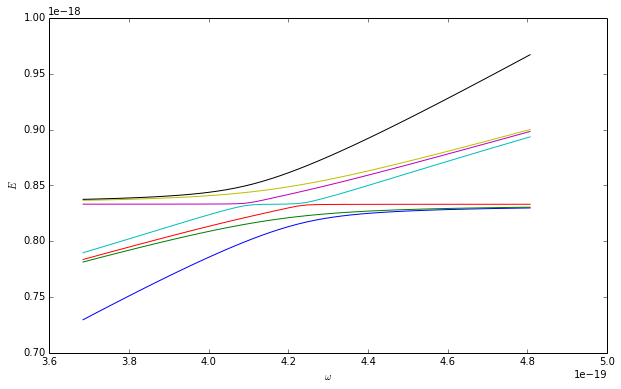

In [101]:
dicke_tryparams_proj(K=3, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=2)

Plot calculated in  0.337095 s


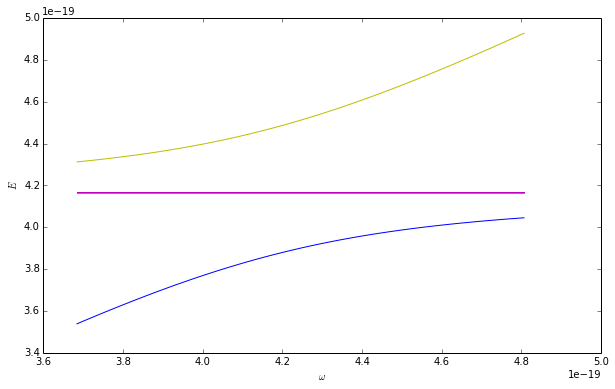

In [65]:
dicke_tryparams_proj(K=5, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  1.678062 s


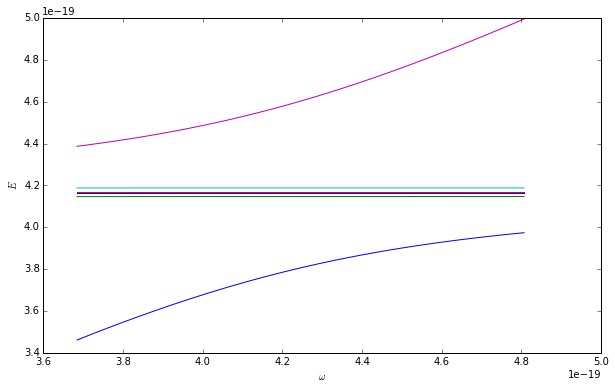

In [66]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  3.507558 s


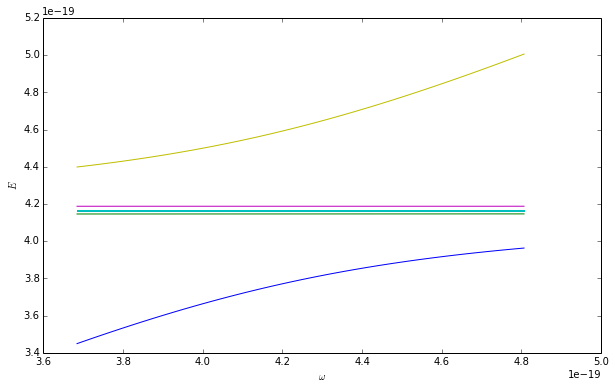

In [67]:
dicke_tryparams_proj(K=12, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)
# Kernel died, out of memory with K = 12

In [8]:
# Decreasing the size a bit
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs

[[], [1.5161045033497876e-23], [4.7479708255456177e-23, 2.7191876098221873e-23], [-9.8943381435924737e-25, -7.206384715737855e-23, -2.2419202208357079e-24], [-1.7922198859360798e-23, -1.0760940184442235e-22, -6.1987600581724772e-24, -8.3163926928364048e-24], [-4.0150444747690117e-24, 9.8109019813520675e-23, 9.2701158609498229e-24, -3.5534293605971835e-22, -2.386020010327916e-22], [2.3244808461866866e-23, -3.386964945657092e-24, 1.4107480492221673e-23, 3.0751136789827041e-24, 2.335112215546663e-24, 5.9932856282452761e-24], [-2.9079714383521051e-23, 1.1889930100390201e-20, -2.3425685975592684e-23, 1.3152380942547139e-22, 2.0894055610763667e-23, 2.4087012278215392e-22, 1.0553807155950617e-24], [-1.0464347638513597e-22, -1.9016741141101751e-23, 3.4700437417266253e-24, -3.0025374499391937e-24, -1.469223984688114e-22, -3.9740521184628796e-23, 1.3465042230031005e-23, -3.086053258451786e-23], [-2.0471534687545971e-24, -2.8391801311997913e-22, -1.1224373674466996e-23, 1.5736177920922364e-22, 3.

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


Plot calculated in  0.079188 s


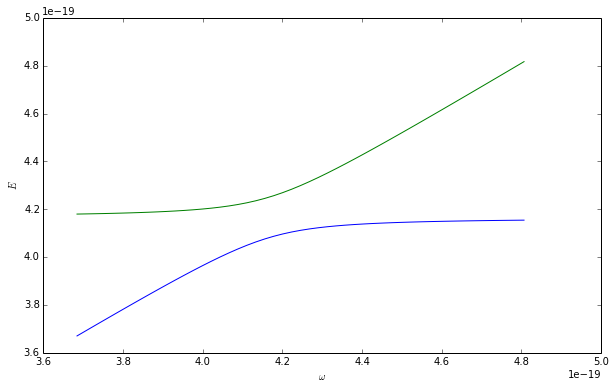

In [10]:
dicke_tryparams_proj(K=1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  0.129749 s


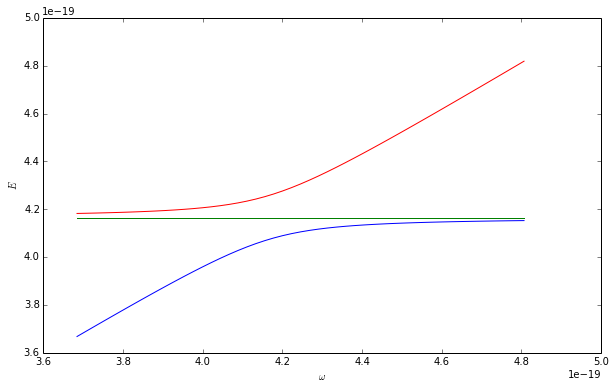

In [11]:
dicke_tryparams_proj(K=2, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

In [40]:
dicke_tryparams_proj(K=3, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)
tau_projector(3,1,2).astype(int)

ValueError: column index exceeds matrix dimensions

Plot calculated in  0.632987 s


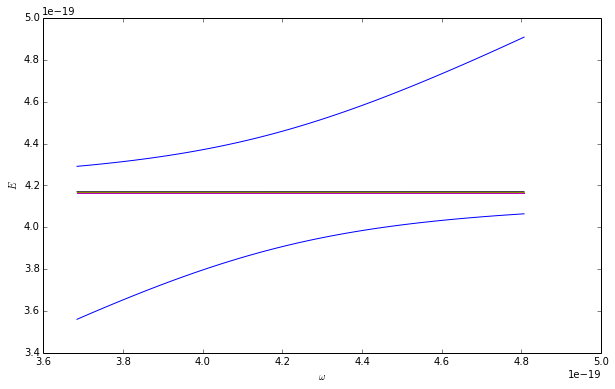

In [18]:
dicke_tryparams_proj(K=7, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  0.781266 s


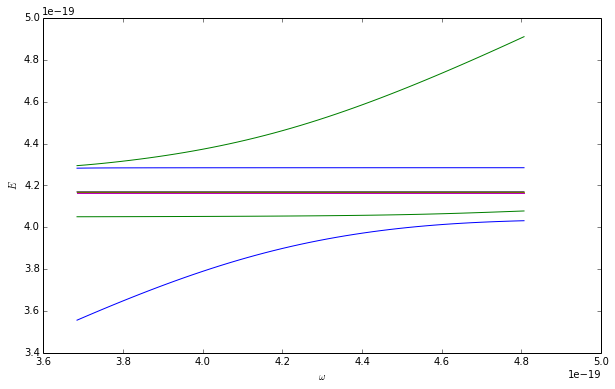

In [19]:
dicke_tryparams_proj(K=8, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  0.986688 s


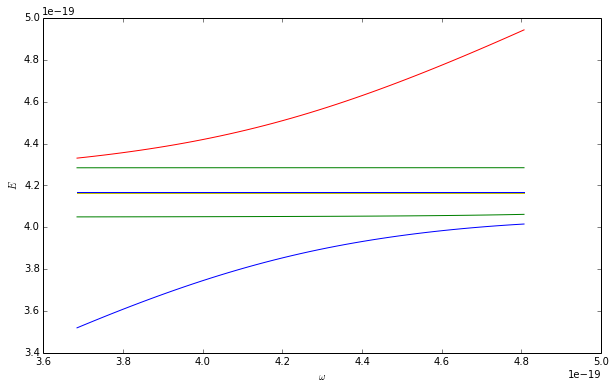

In [20]:
dicke_tryparams_proj(K=9, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  1.251629 s


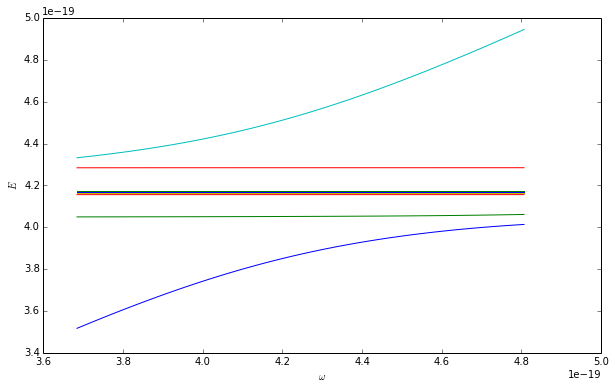

In [21]:
dicke_tryparams_proj(K=10, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  1.892084 s


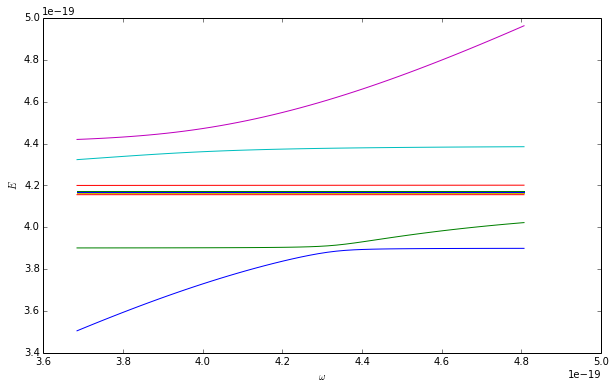

In [22]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

# 1-1

In [23]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs

[[], [-2.0362308431727136e-24], [2.0204044920020307e-23, -2.1337841682228974e-22], [1.033542982503766e-23, 1.8232417493706378e-23, 5.6491741350674061e-24], [-2.8521136981810988e-23, 2.3648734741190422e-23, 3.0812243102545336e-25, -1.0500566657695805e-22], [-1.0410574884811062e-23, 2.8884980374716939e-22, 1.3501791746133038e-22, -2.7700020927912971e-23, -6.564313202518834e-24], [2.5404380617313263e-23, 3.3569902145125347e-22, -6.6489896852556258e-23, 1.8013560226831016e-22, 2.5306079277818158e-23, 1.4687809530750986e-22], [1.3068393749483525e-23, 2.1565522720863968e-23, 3.9859945673562836e-24, 4.8637477217863307e-22, -3.7470634400511581e-22, -3.8304751410896558e-23, 2.3194406811134429e-22], [4.2771363023410689e-23, -2.0019994138845533e-23, 6.7343363085337286e-25, 2.4652958587237484e-22, -1.6388781641322935e-22, -8.7091723881596972e-24, 4.0957606139489735e-23, 9.4641675899313117e-22], [3.3730090226681439e-23, 1.2741555468310302e-24, 6.0497015811227715e-24, 2.5698737720283487e-22, -2.9907

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


#1-2

Plot calculated in  0.071948 s
Plot calculated in  0.114838 s
Plot calculated in  0.192977 s
Plot calculated in  0.266279 s
Plot calculated in  0.367089 s
Plot calculated in  0.477678 s
Plot calculated in  0.606032 s
Plot calculated in  0.770133 s
Plot calculated in  0.945217 s
Plot calculated in  1.219766 s
Plot calculated in  1.815065 s


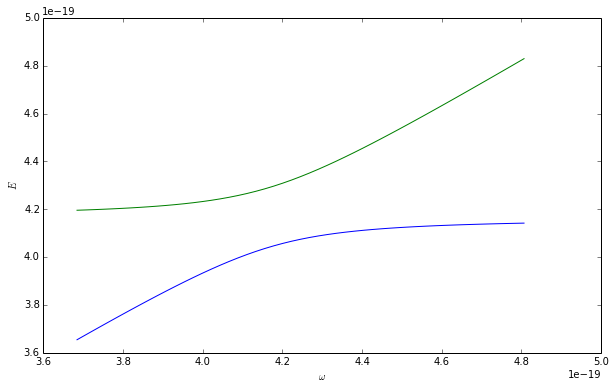

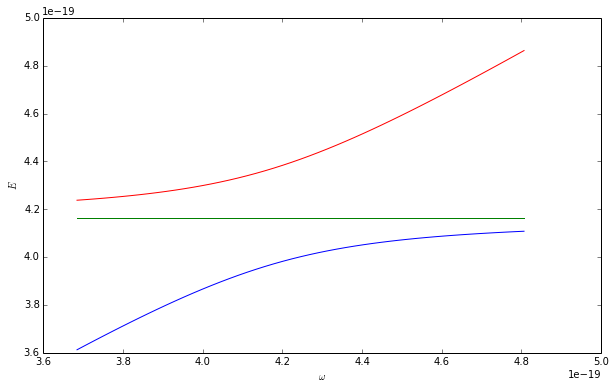

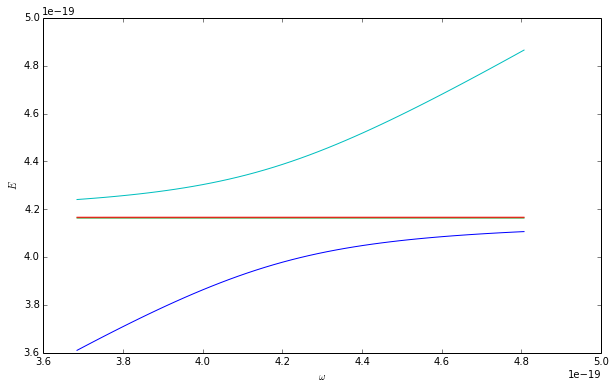

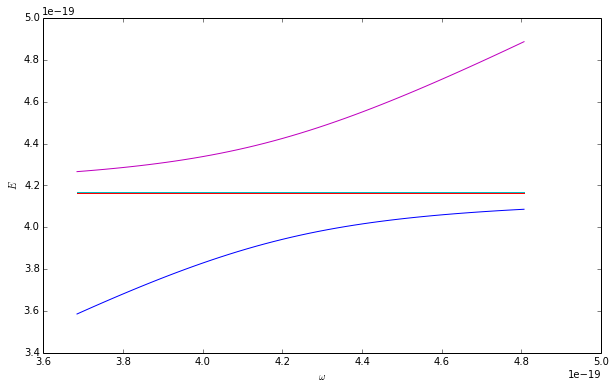

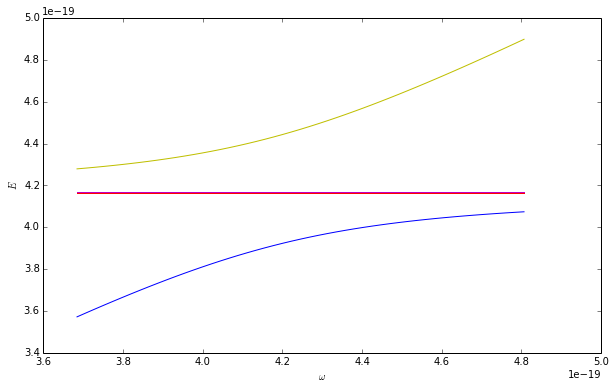

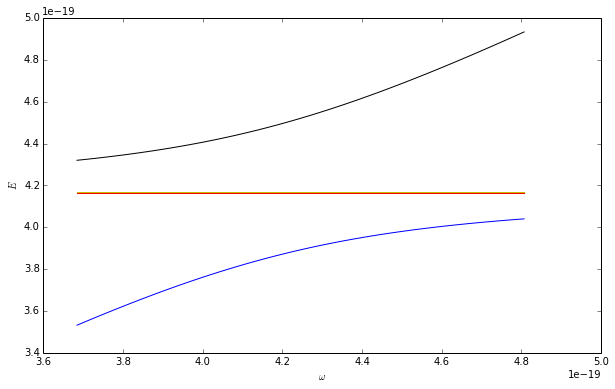

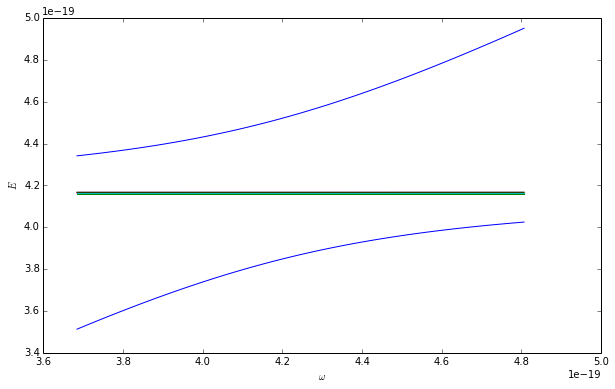

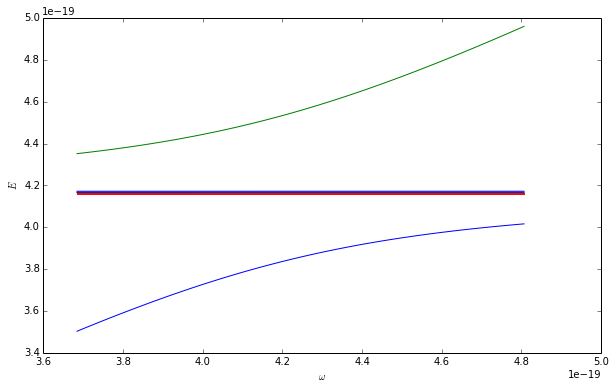

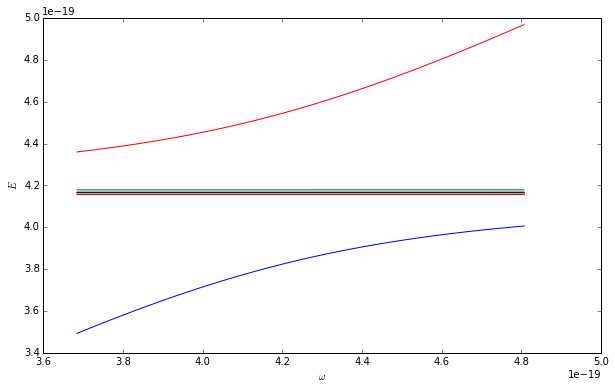

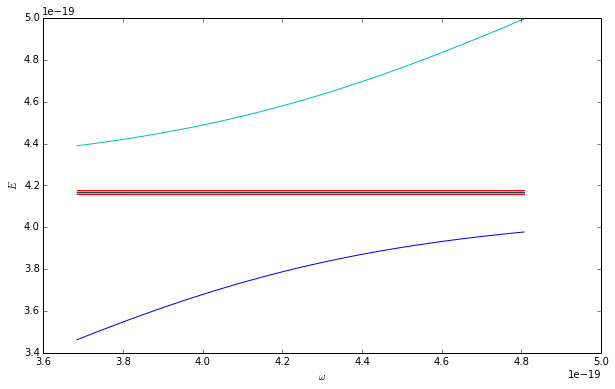

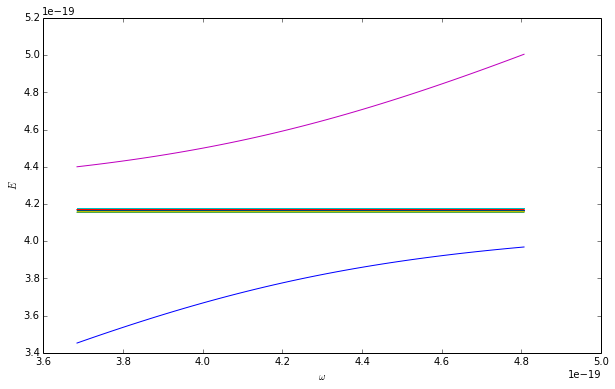

In [24]:
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#1-3

[[], [-8.1275742700595242e-23], [-1.988296762699821e-23, 9.0351154228641324e-23], [3.389333713988625e-23, 1.1472815745854751e-21, 1.0167685229825935e-23], [-1.032473078631779e-25, -6.0394179112333199e-22, 5.5768404910018225e-23, -5.8797583679801038e-22], [-1.8902993787106846e-22, 3.9779041207651721e-23, 2.7121540929498485e-23, -1.7924493161546813e-23, -3.343378315952484e-24], [1.1294945326837707e-21, 1.8486226330503074e-22, 1.1578539751346452e-24, -6.6132427046570812e-23, 3.068692652518626e-23, -1.5020452475993466e-22], [3.2988498564683845e-23, -4.0707432162302557e-23, -1.471392529939993e-22, 1.5043961068748721e-23, -6.4465877486293732e-24, -5.4868915028582814e-23, -2.7329955455311119e-26], [-2.5045000389436512e-23, -1.4827125422512299e-22, -1.1451912408800529e-23, -6.2365330079237168e-21, 1.8789426494521759e-21, 1.4044996870857722e-23, 3.9977569299355168e-23, -9.922407089453459e-24], [1.6861100621693837e-23, -7.4227551675815915e-22, -1.9078558383854249e-22, -2.7819234459788149e-22, 3.

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


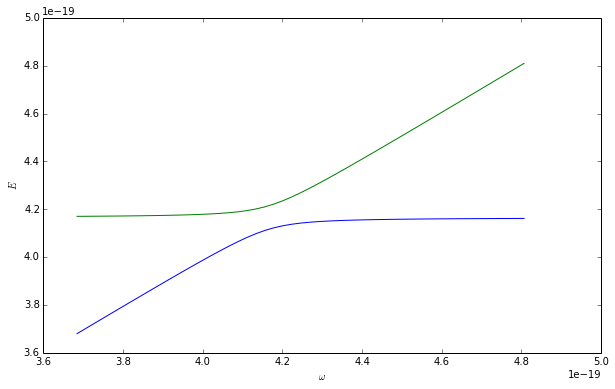

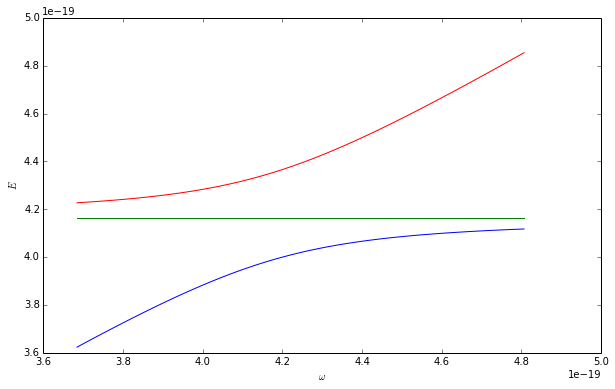

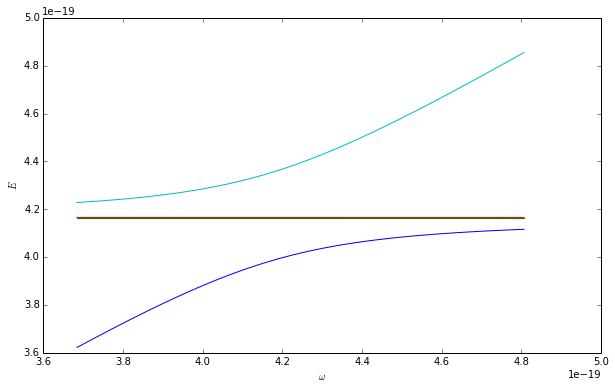

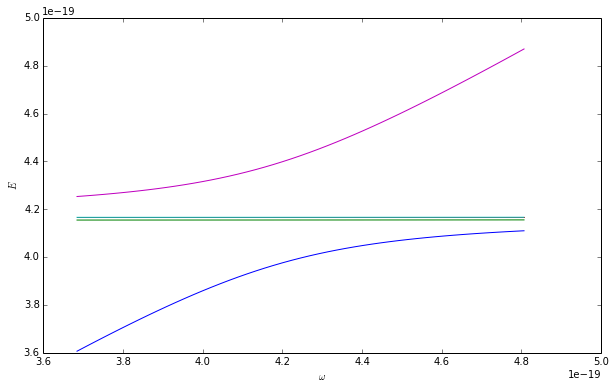

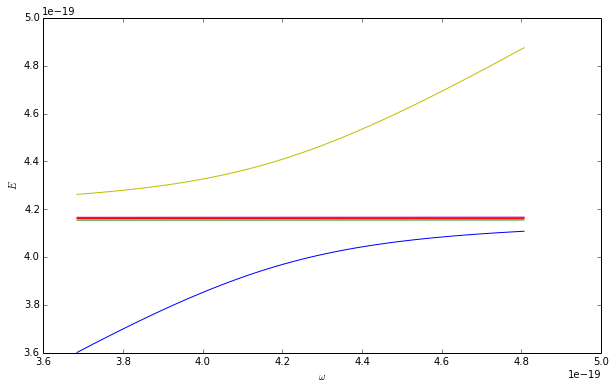

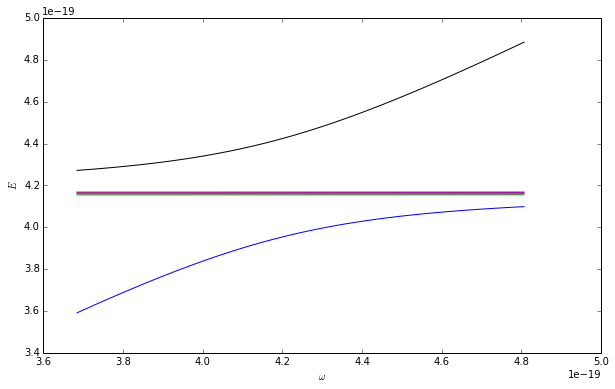

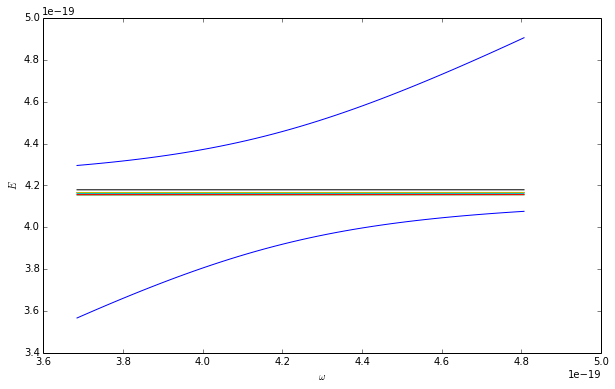

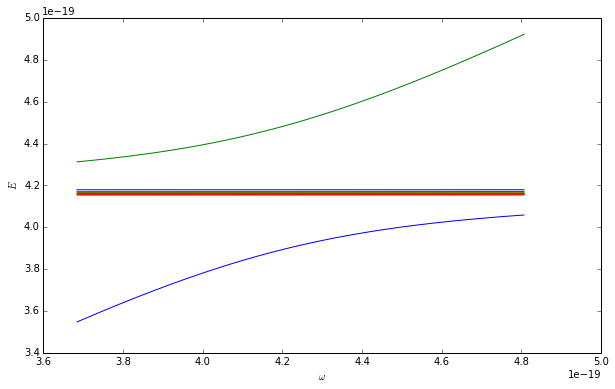

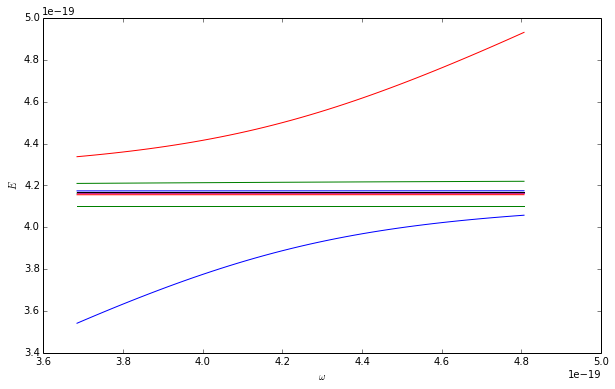

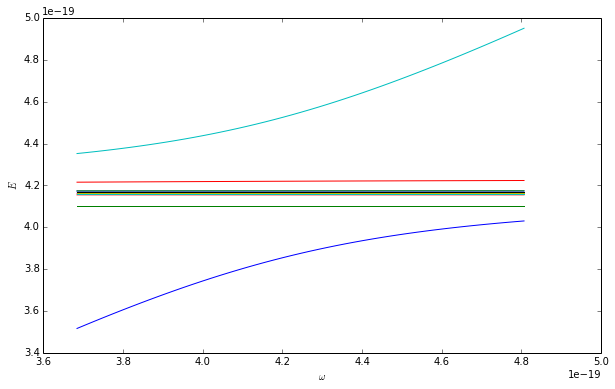

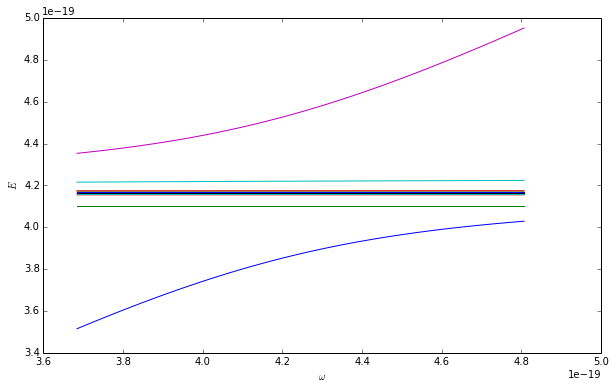

In [25]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#1-4

[[], [-1.92108178975569e-24], [2.5424984780874862e-23, 1.0002548015788256e-21], [-7.7478899533656649e-24, 2.2866656711032236e-22, 1.1474611770032803e-22], [-2.864294476438912e-23, 1.3889512385212867e-22, 2.780564904186501e-22, -2.3185052070890491e-21], [3.3811031781940304e-24, -2.4574347693197728e-23, -2.6335670279975029e-23, -2.1726145485610803e-23, 2.022046186839082e-23], [5.2029835760866466e-25, 3.5611740325053831e-23, 3.8047009386010704e-23, 1.0592907668289089e-23, -9.3591572391100708e-24, -1.5111821717170396e-23], [6.4392930811722111e-22, -1.6420976652880097e-23, 4.2662697340709577e-23, 9.1271068478481904e-24, 9.7318308166281784e-24, 6.8380548030506371e-24, 2.754587429121732e-25], [8.0604329848048069e-24, -9.444994608119646e-21, -7.6711249478165255e-22, 6.883151830476306e-23, -5.9621895566077095e-23, -2.9578746639842855e-23, 1.5909118224044522e-23, 2.2216092320989217e-23], [5.2615915640746149e-23, 1.2772919887468793e-22, 1.7568193041566234e-21, -5.2238407712393713e-22, 4.550849835

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


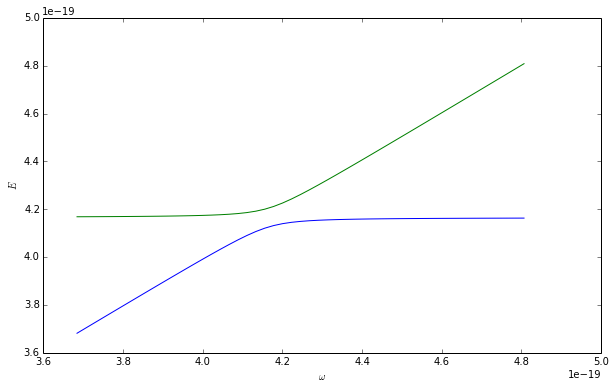

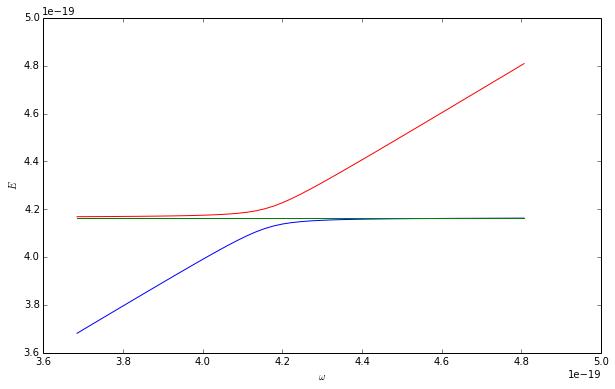

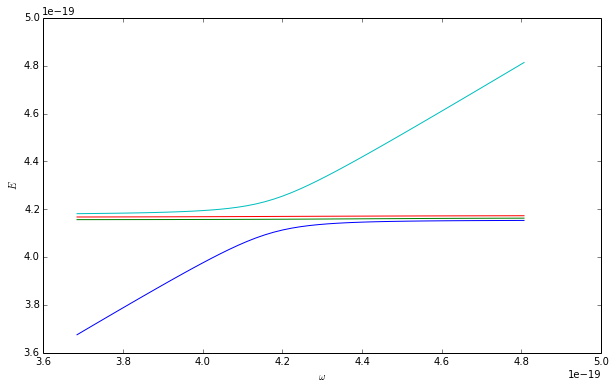

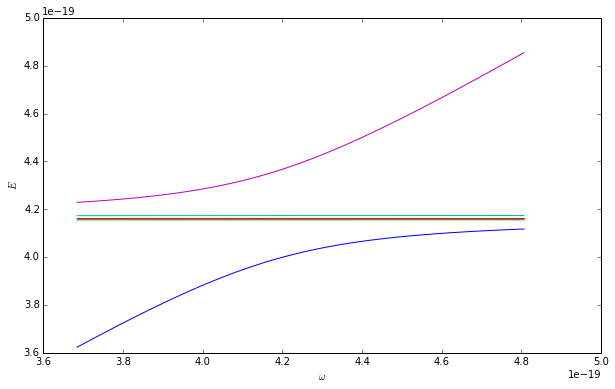

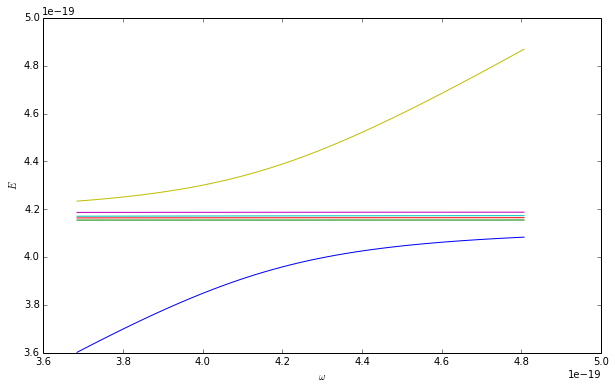

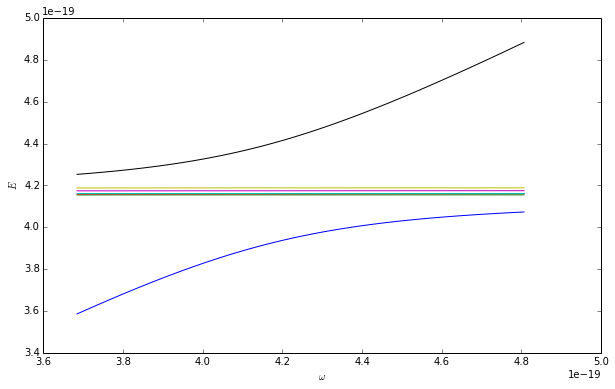

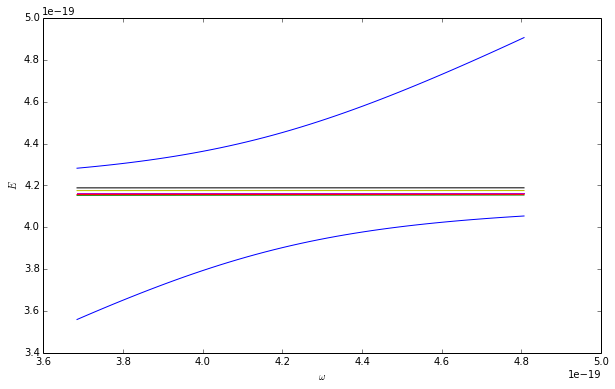

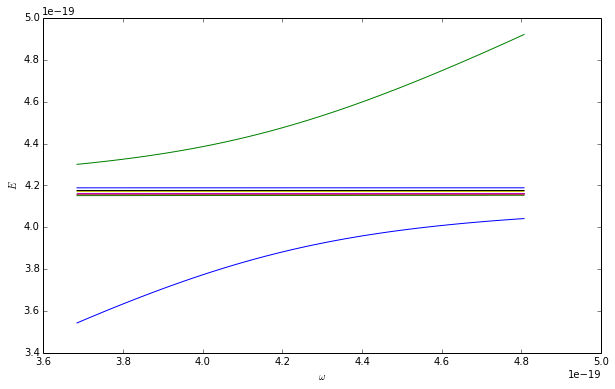

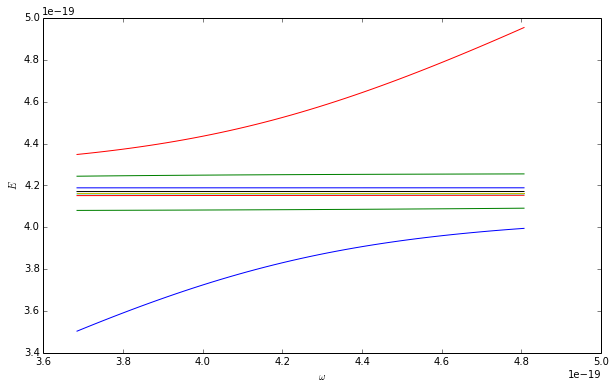

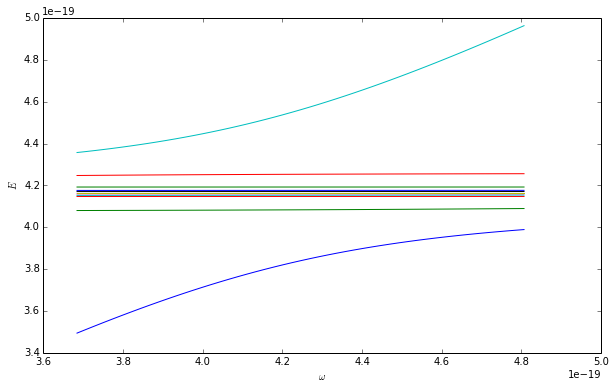

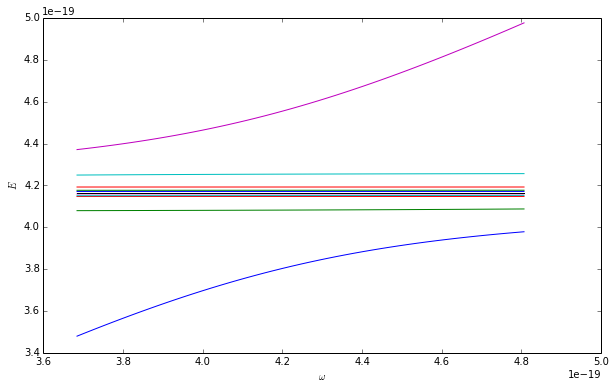

In [26]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#1-5

[[], [7.9482488844882379e-23], [-6.0742376273318675e-23, 8.5185381842112971e-24], [-2.9792984966093421e-22, 1.1031273558957172e-23, 1.8899496893928622e-21], [1.4801343406521702e-23, -1.5674180155124223e-23, 2.1618073365372719e-22, -3.7950291811673724e-22], [6.6124906865513448e-24, 6.257659610005392e-24, 1.5832609152053369e-23, 1.0179293676189688e-23, 2.2421485802701082e-23], [-2.1301181318516328e-22, 9.0407309219278367e-23, -9.6758897541107721e-23, 5.6715313108425656e-24, -1.2439354353499548e-22, -1.0112908582773612e-23], [-1.1165348794076129e-21, 3.7329897936841858e-24, -1.7703724304495697e-22, 6.9155461127611195e-22, 3.8270813871071727e-21, 2.4213807647971418e-23, 7.2363603618515366e-23], [3.7067406271810987e-23, -8.5633398133859058e-24, -2.0322961644270922e-22, -7.4057041796363993e-23, -5.3991456481535934e-23, 5.2246783662372391e-24, 3.3754076006051767e-24, -3.9874501109310954e-23], [-2.1928933364908891e-23, 7.5035701117605802e-24, 2.9183049315963709e-24, -1.5795602680817933e-22, 5.

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


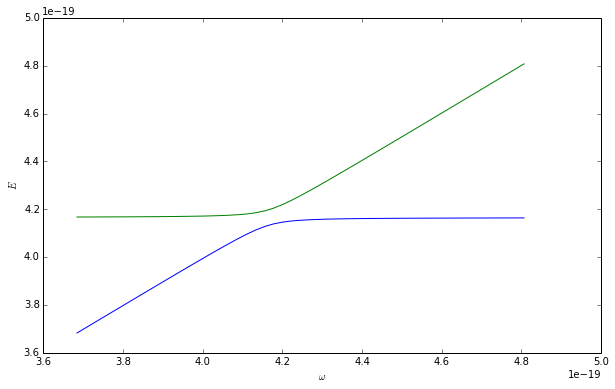

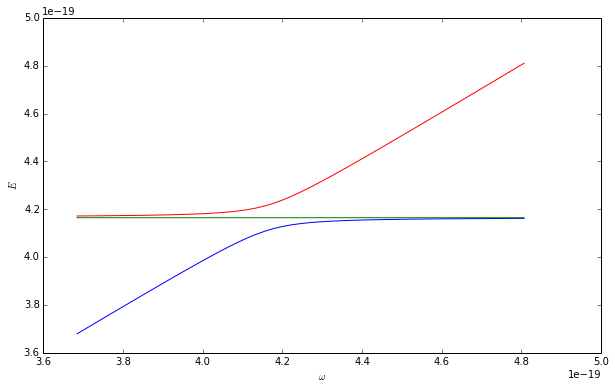

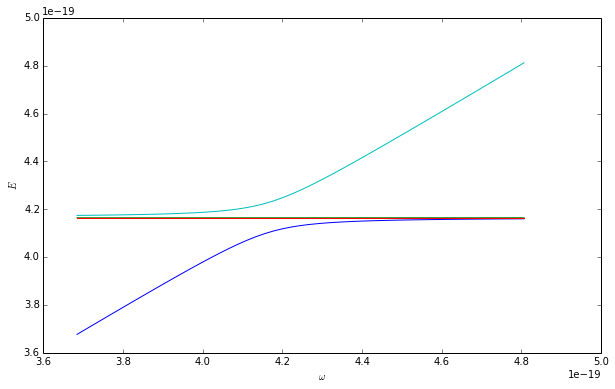

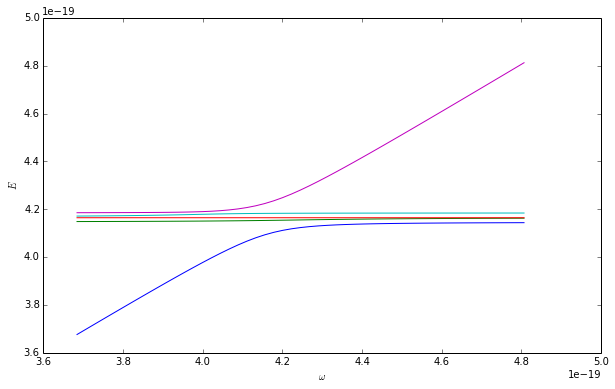

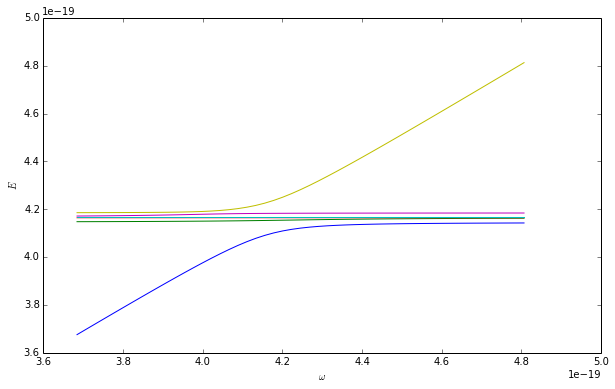

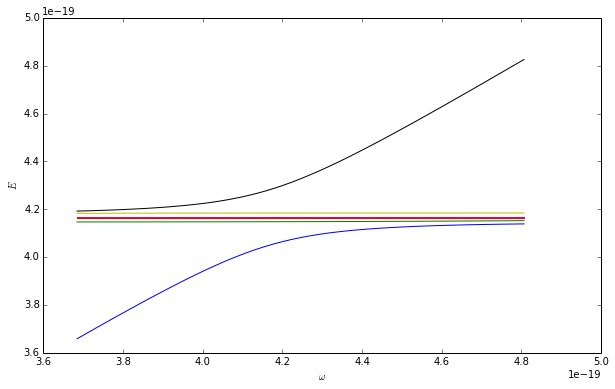

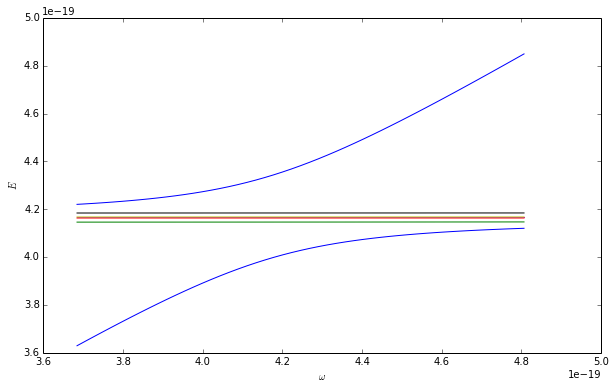

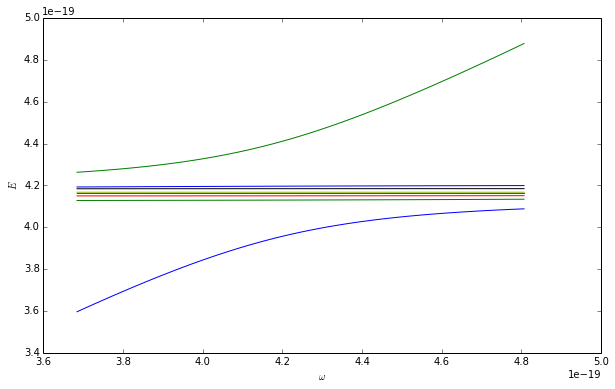

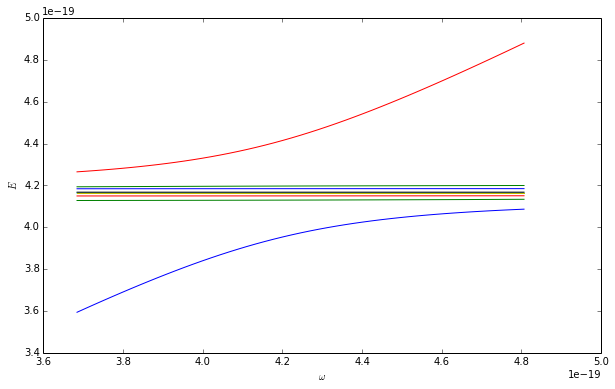

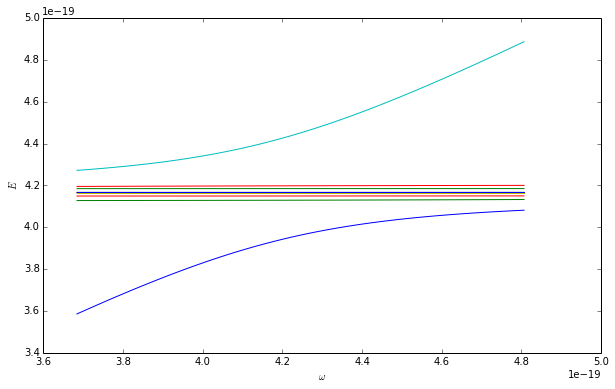

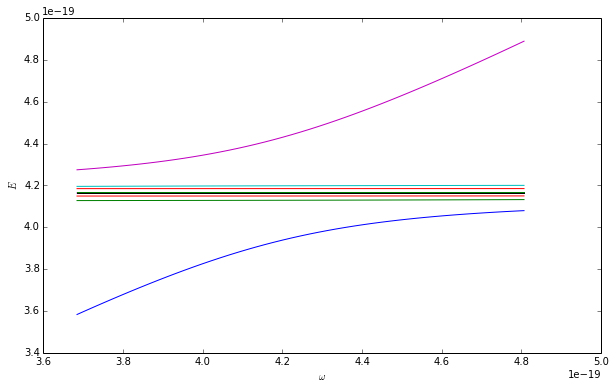

In [27]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#1-6

[[], [1.3383201068768537e-22], [5.6069564356600687e-22, -8.5238374198490622e-23], [1.6124245224430276e-23, 1.6338953261052738e-23, -4.2974934487007836e-22], [4.6794930042694052e-23, 1.5843277990162173e-23, -2.0708551816828168e-22, 7.0127409154101942e-23], [3.5166834134087353e-23, 1.5553069084364555e-23, -3.7749355811900139e-23, -3.69773067374802e-24, 4.3340658419337817e-23], [5.7025852820661964e-23, 1.1861092544636906e-22, -1.3948174283235857e-22, -1.7878913984086335e-23, 3.4631782347325996e-23, 1.2199842417309223e-23], [-2.0623149293932394e-23, 4.2043528627447668e-24, -1.2704607812427916e-23, -1.2072529002632945e-23, 1.2691818367920645e-22, -3.3725444311731543e-23, -3.1473241385876939e-24], [-6.4549350280319567e-24, 6.4464719524300953e-24, 5.4988277214128517e-23, -1.636789436489092e-23, -1.83778354327878e-23, 4.3438414007766153e-24, 1.633480475524308e-23, -5.865732709915482e-24], [-2.5506935681084176e-23, 2.3073516564187191e-23, -1.1672171136342488e-22, 1.1576879532126581e-23, -1.9414

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


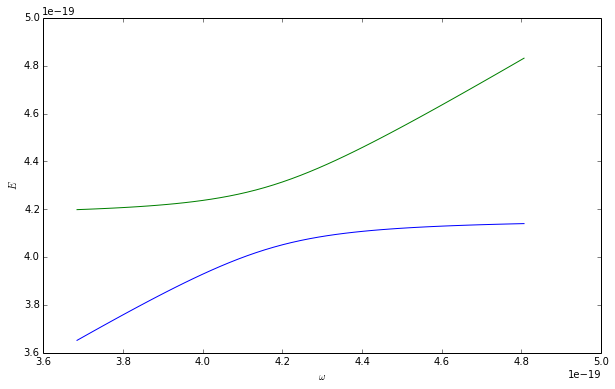

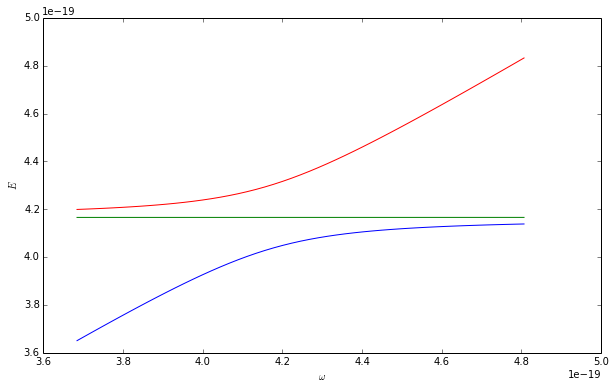

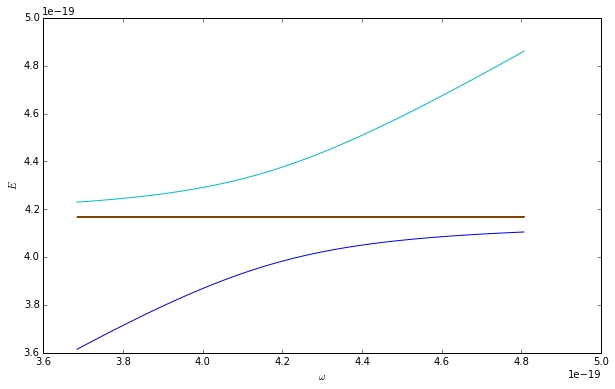

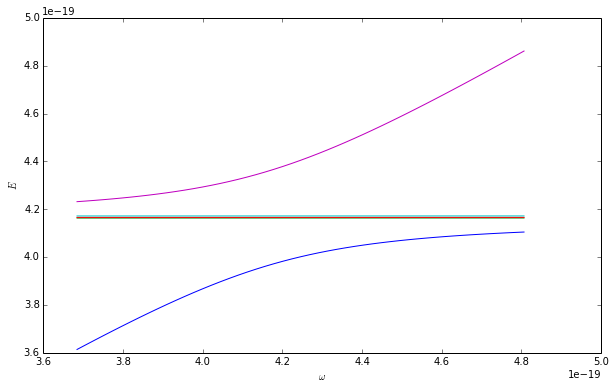

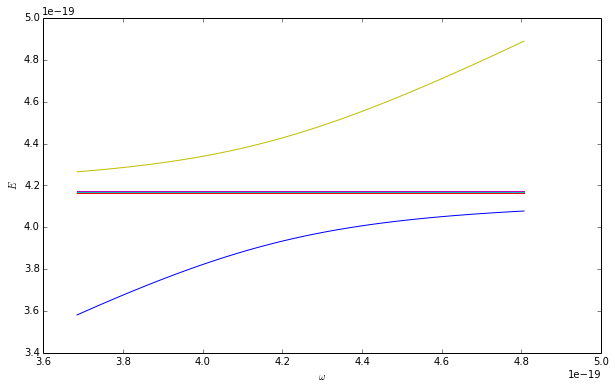

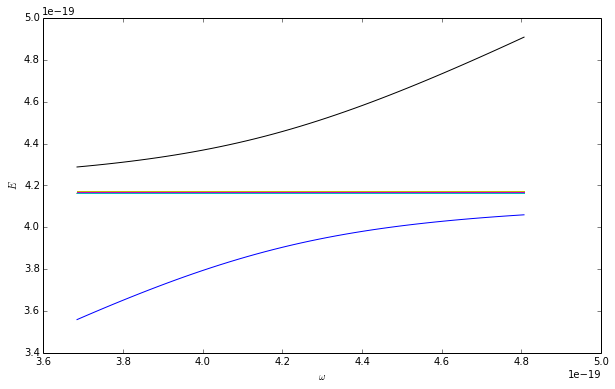

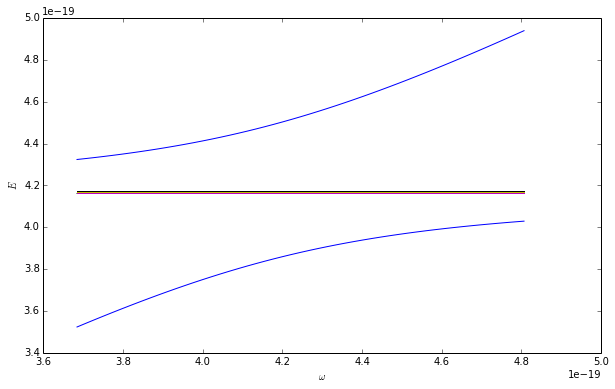

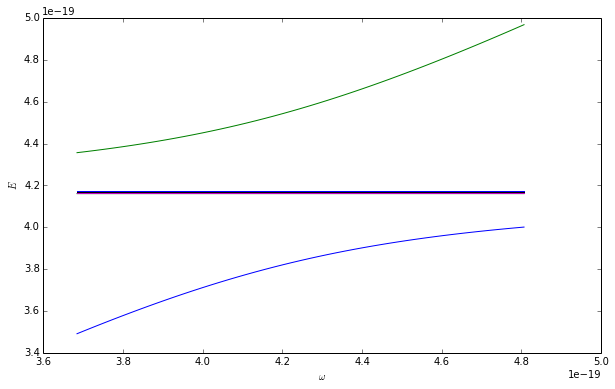

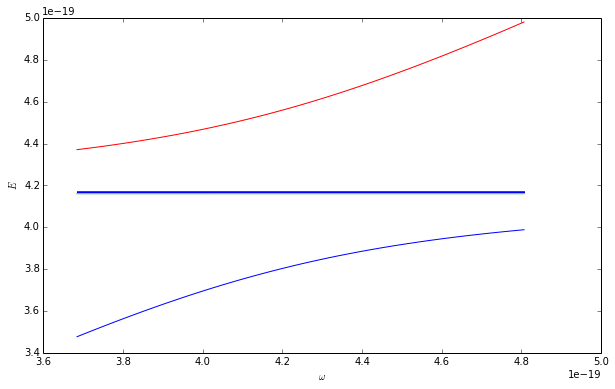

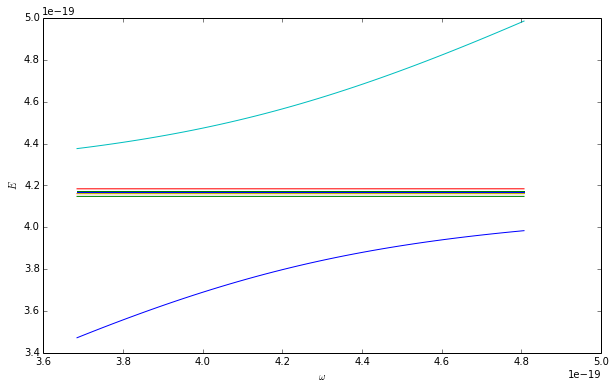

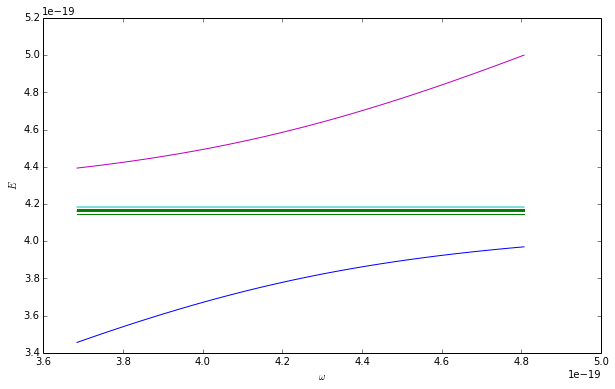

In [28]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#1-7

[[], [-1.8912890274969885e-23], [3.7253613543745935e-25, -2.5279881435531796e-24], [-2.3945069612678696e-23, 1.8412815108273773e-22, -7.1606819372094147e-24], [-1.4310490655611668e-23, -1.3477168736102773e-24, 7.5173324003957728e-22, 8.8009539309964287e-25], [-1.805943798723226e-22, -9.69410633041588e-23, -4.8595299115303336e-25, -8.1238453463310125e-23, -8.9365116678864948e-24], [8.8987242727301121e-22, -1.3730902410006162e-23, 1.6283810104895582e-23, -2.3795133249185262e-23, -1.0800178125938589e-23, -7.3185330336305427e-23], [-4.9400111540059924e-24, -4.4662276586602269e-24, -3.4284335633691988e-24, -4.5366323740707517e-22, -4.4715529561776267e-24, 4.501992023928979e-22, -2.0225461803807119e-23], [-2.7901965647663311e-22, -8.9951679225414982e-26, -3.8613553297617253e-24, -8.1398203521784019e-24, 4.8608651355308978e-24, -6.0473798893434409e-24, -9.6463538998873531e-23, 1.9240305259156746e-23], [2.3621816626277636e-21, 3.1418192855849397e-23, -1.3105243640174204e-24, 3.5271281346953061

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


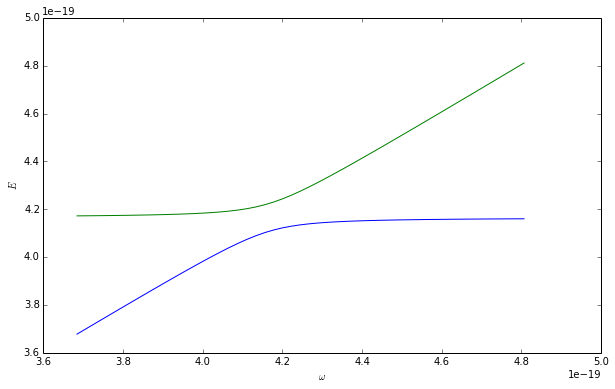

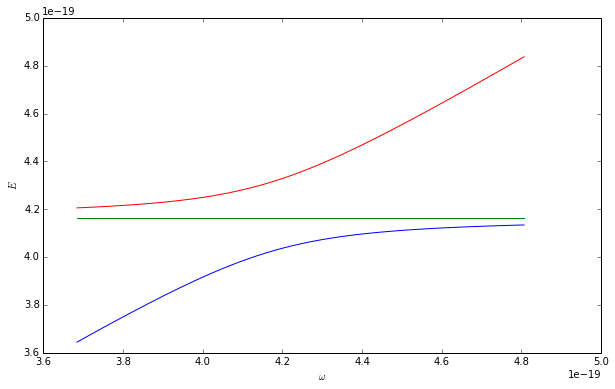

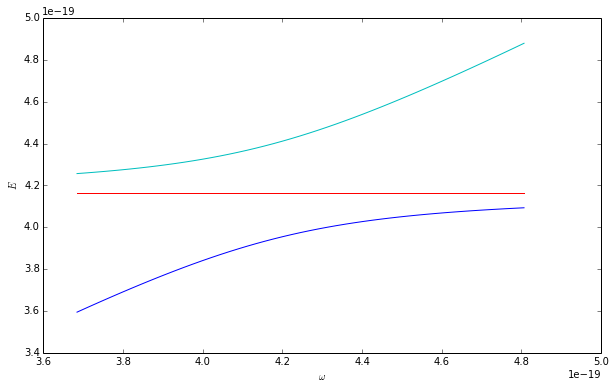

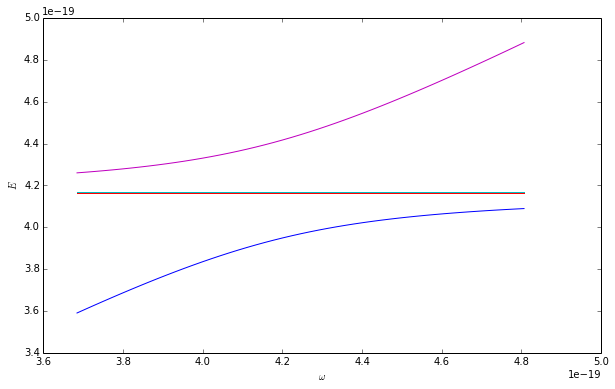

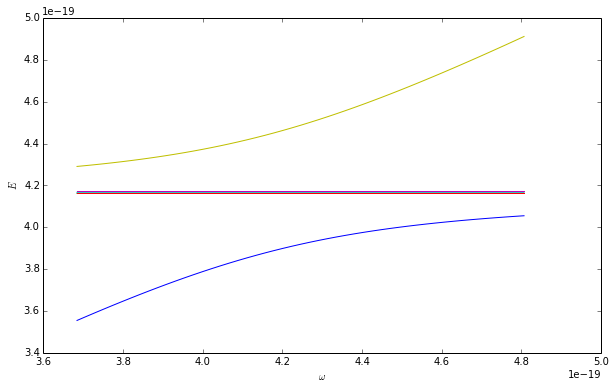

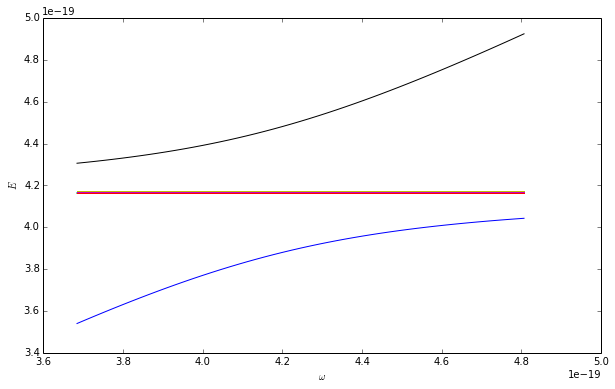

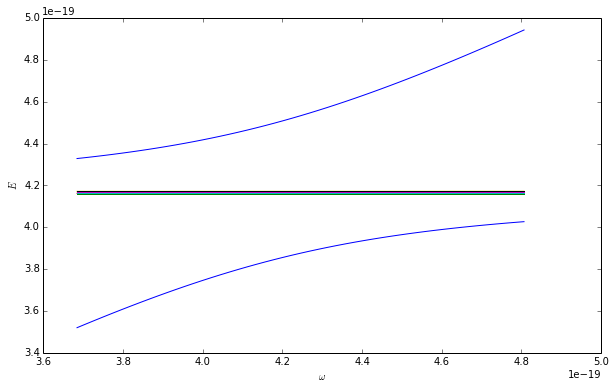

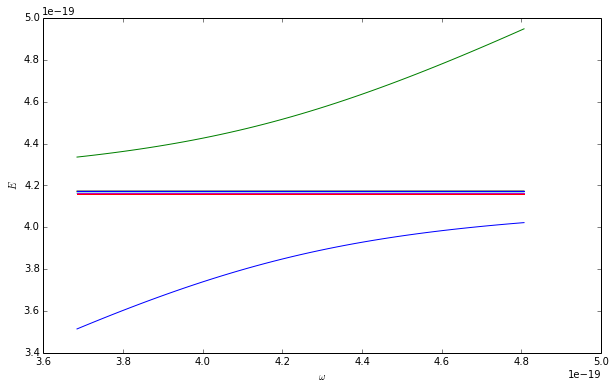

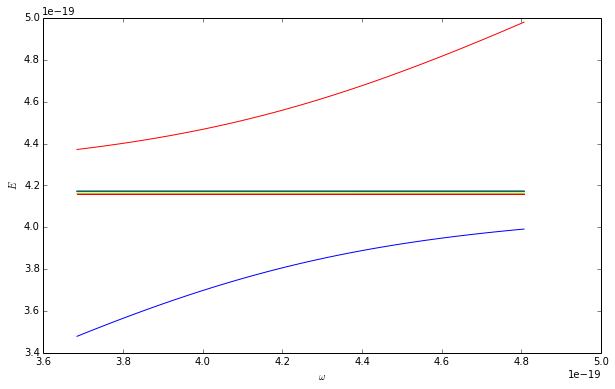

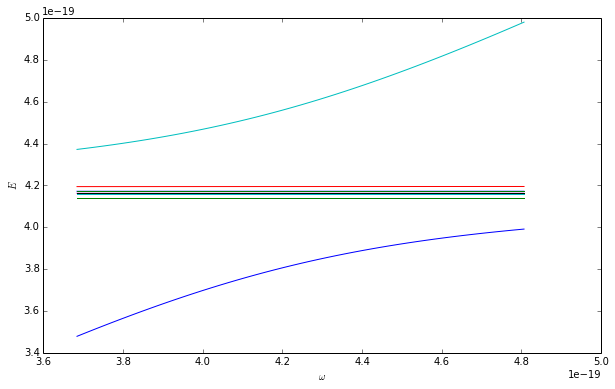

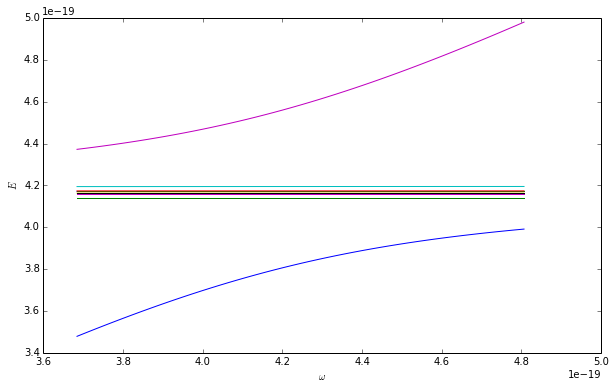

In [29]:
K = 11
poss = randomPositionBox(K=K, x = 4*nm, y = 4*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#2-1

[[], [-1.6771323948860473e-23], [2.8021047201649467e-23, -2.1668563584285926e-23], [-3.2799762856212469e-23, 3.8423903463405792e-23, -2.0303492315304871e-22], [2.3722636752939552e-23, -9.7707680247306965e-23, 4.1371078957730697e-22, 9.8314156610497858e-23], [-1.3006819877511897e-22, 1.4207633125865644e-23, -2.1319563245437847e-22, 4.9643399041904418e-23, -1.7403850395361311e-22], [-1.1039864694018177e-22, -5.1955361213295412e-23, -7.0394981880636144e-22, 1.4513699166234003e-22, 2.717395461284337e-23, 7.6296782399107325e-22], [5.6222887147354811e-24, -1.8447284782171612e-23, -3.5302671761986163e-22, -4.1049357596475681e-22, -3.6169203857419091e-23, -2.7675524949112282e-24, -2.100310337741942e-23], [-1.1998993603634451e-22, 4.5396593520394556e-23, 2.0452757235565645e-22, -2.9220180366466687e-22, 1.2261554228966818e-23, 3.580888779389807e-22, 2.3738513074926164e-22, 4.9973354132669296e-24], [-5.7163298761476258e-21, 1.7618989077596431e-23, 6.6620380797483161e-23, -1.0548899319364477e-23, 

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


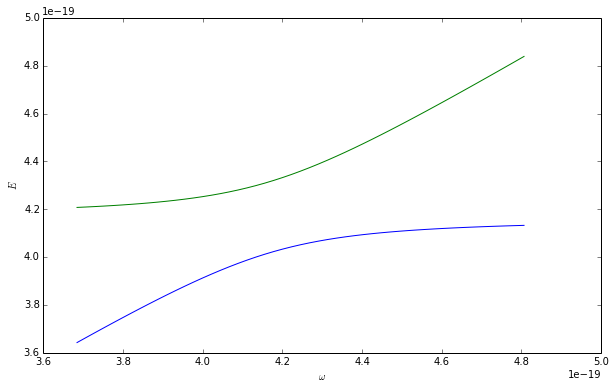

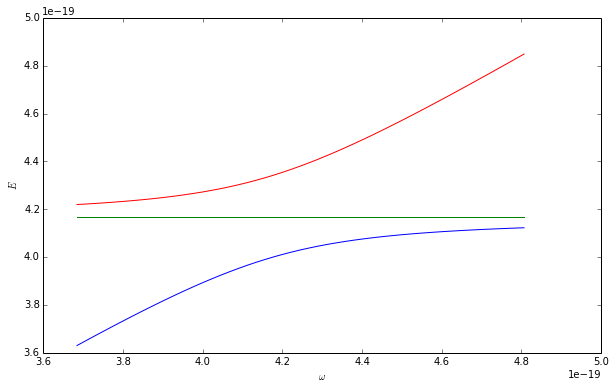

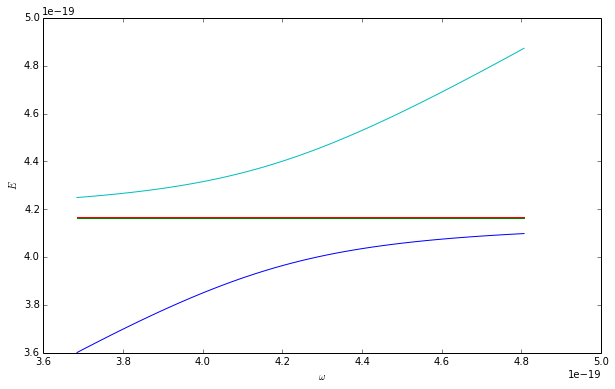

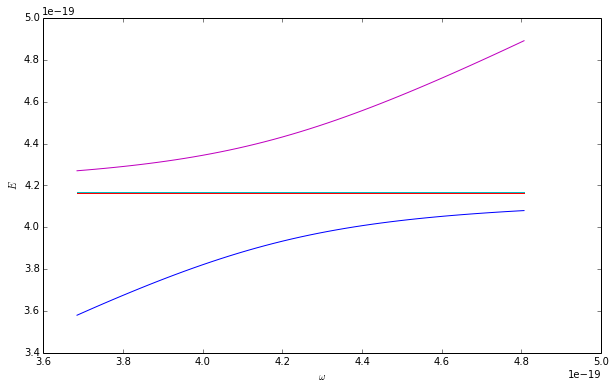

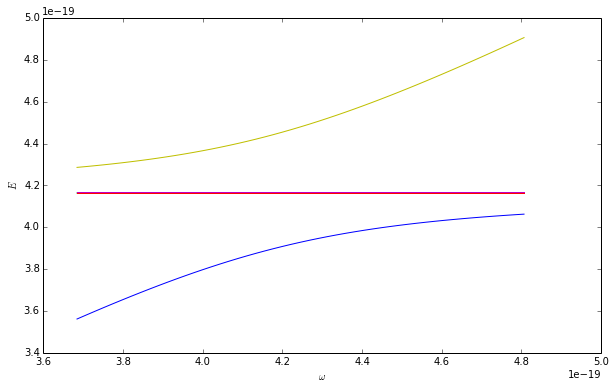

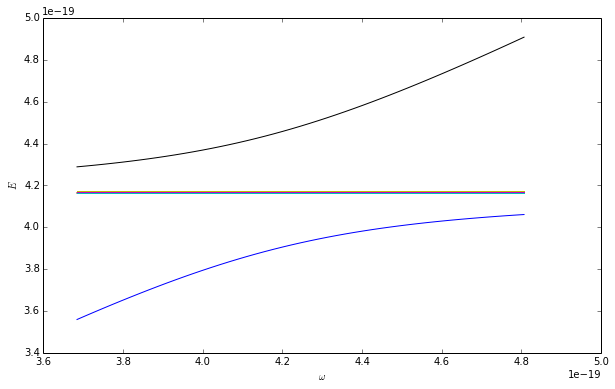

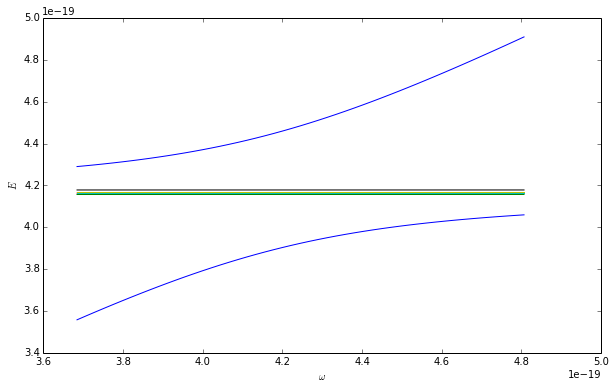

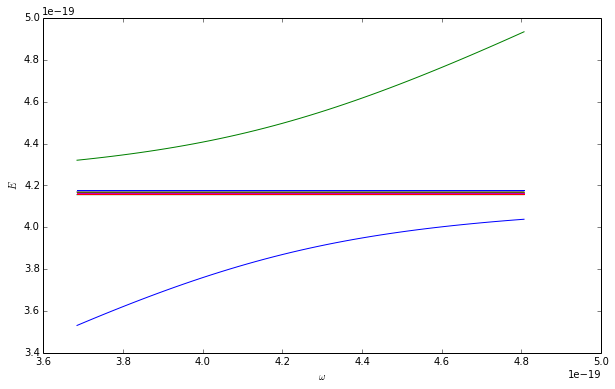

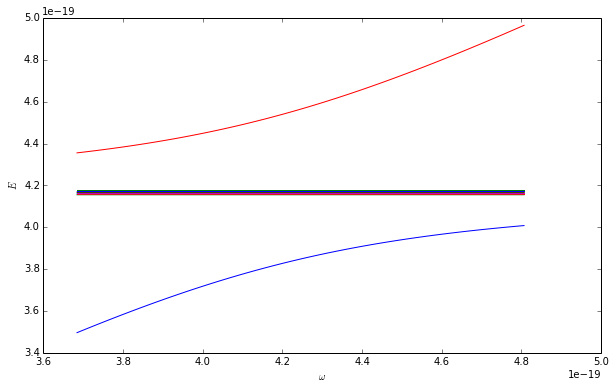

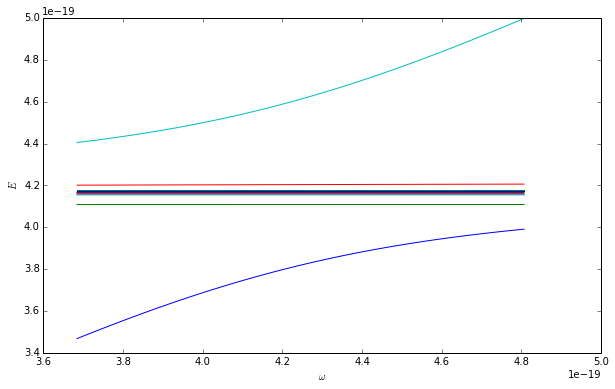

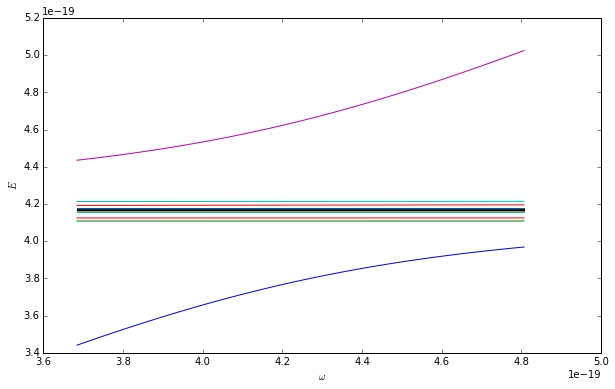

In [30]:
# Box size even more reduced
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 2*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#2-2

[[], [-7.3710676985232212e-22], [2.1267416005852824e-21, -3.2233428663485667e-22], [7.7200165535677545e-22, -2.9921773888697918e-22, -2.6453935055355949e-21], [-8.7109342936404361e-23, -7.1749004613669842e-23, -1.5935562236361584e-22, -1.5469021596680443e-22], [-1.1002934303473607e-21, 2.4027953686942705e-22, -1.856935198074304e-22, -5.5052969138697318e-22, -2.0857015372651051e-23], [6.927439964662584e-23, 6.8485676659892879e-23, -7.0066519926720936e-23, 5.0726954796777909e-22, 1.5504420727082466e-21, -2.1254283996936002e-23], [4.1807172113586371e-23, -1.6652713546152297e-22, 3.6238985780807675e-22, -3.1965806082484001e-22, 5.3192570032882375e-23, -7.7423830384586102e-23, -7.5550405408477587e-23], [8.0770974438163166e-24, -1.114910608292738e-22, 3.0582083913704459e-22, -5.8446645345855368e-22, 4.1426989778895285e-22, -7.753343102417016e-23, -6.1387595911643082e-21, 1.2398632546158779e-22], [3.2781074003873708e-22, 5.1480848182248752e-22, 1.1317455393045487e-22, 9.9380693816834166e-23, 

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


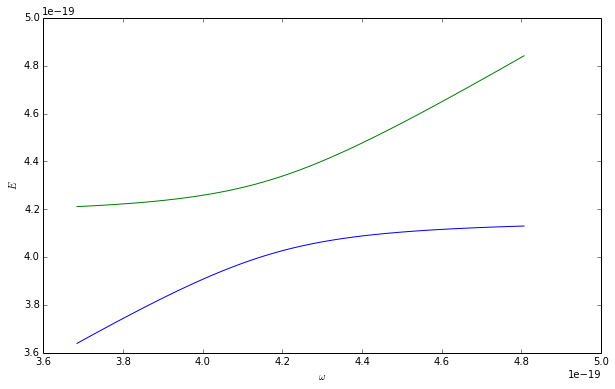

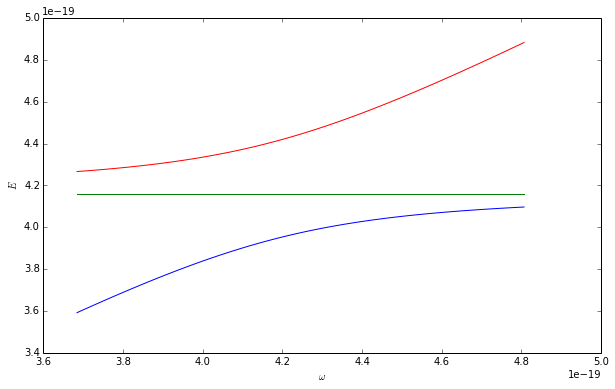

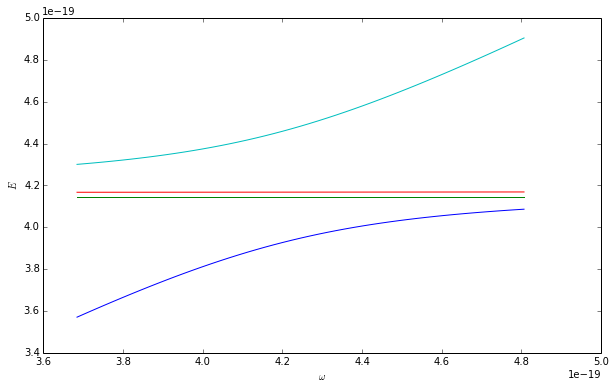

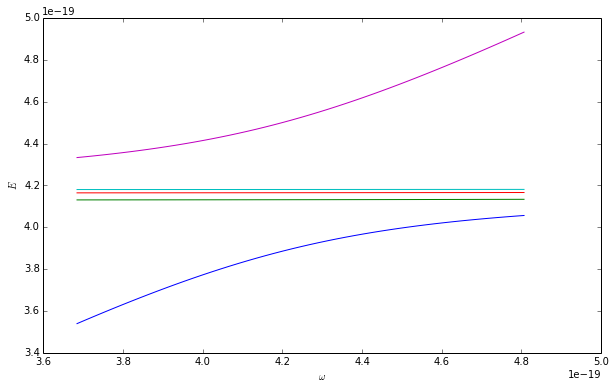

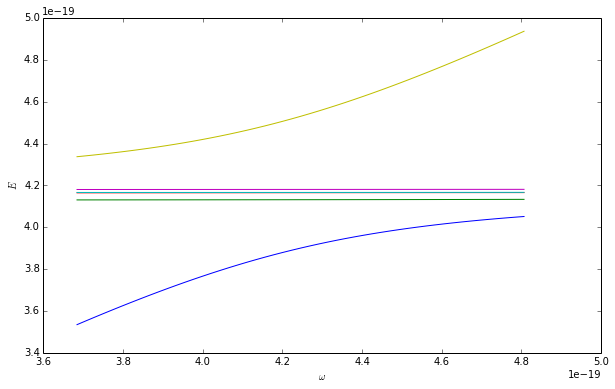

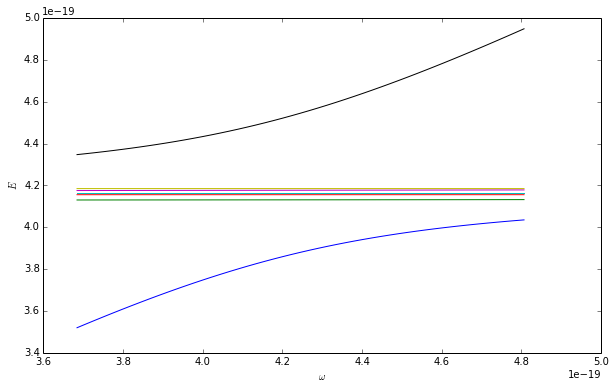

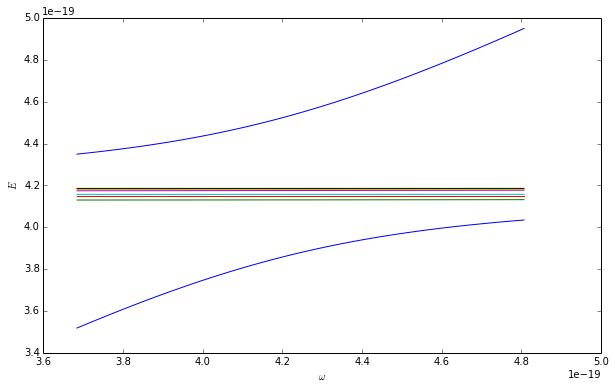

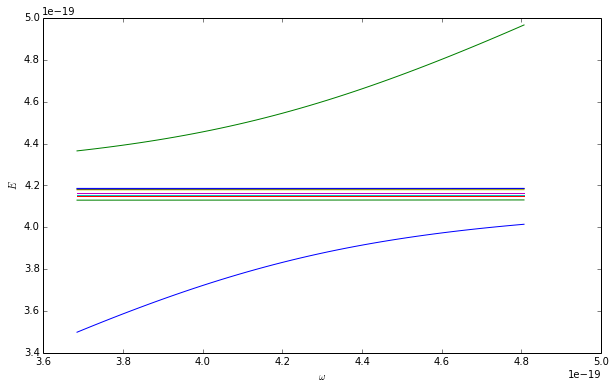

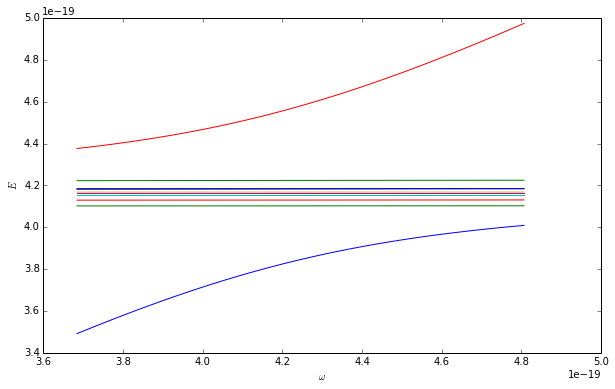

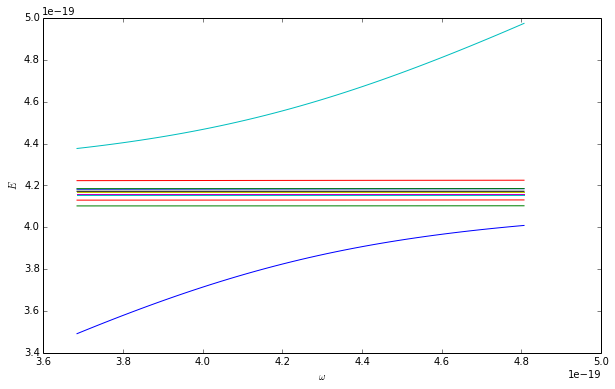

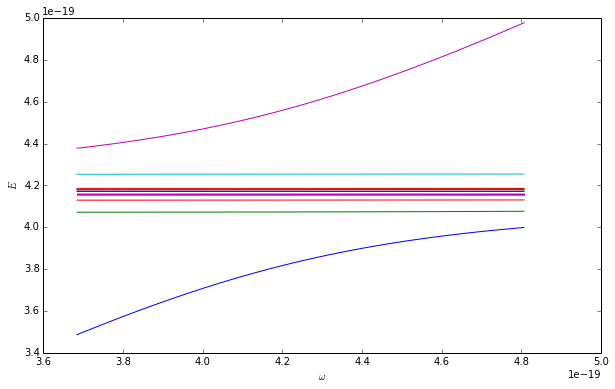

In [31]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 2*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#2-3

[[], [4.4599283110346113e-22], [-2.0310443748954397e-24, -5.797614835514617e-23], [-4.8737216879833592e-23, 7.169040563170458e-22, 2.5435080188123417e-23], [1.3318929558649033e-22, -2.8220974088625563e-21, 7.5120748440288091e-23, -3.005711470544235e-22], [4.4359268925980893e-23, 1.5583208267473858e-23, -3.7261018892615661e-22, -5.2158426908517494e-24, 7.2621741163464113e-23], [-2.5342456516478694e-23, 1.5559047140472991e-22, -2.4230894306096662e-23, -1.0705529315491294e-21, -2.5176742469973544e-22, -3.9257506689303019e-23], [3.933238740988804e-22, 1.4325058360352992e-23, -1.3962314609076339e-22, -6.5435809942937524e-23, 1.1710839277286502e-22, 1.9343971556329136e-23, 2.3904917085075576e-23], [-2.8228921357658553e-23, -4.9593196032104262e-23, -1.8344454390346899e-22, 1.2223057578590461e-22, 6.5579429100647553e-23, 7.2796685416296548e-23, -1.5323775481447349e-22, -3.9934844832497701e-23], [-1.707721148509734e-22, 1.4486149944526092e-22, 7.5107204686990399e-22, -5.2025017938529727e-23, -8

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


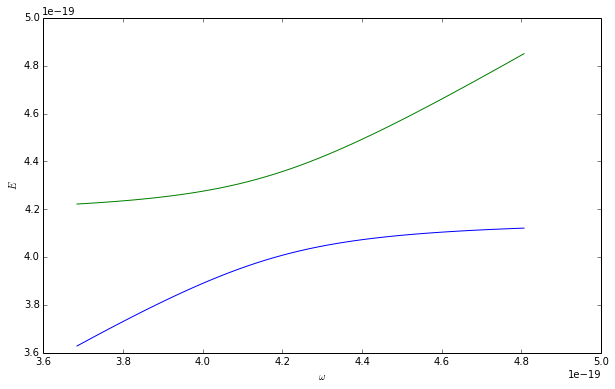

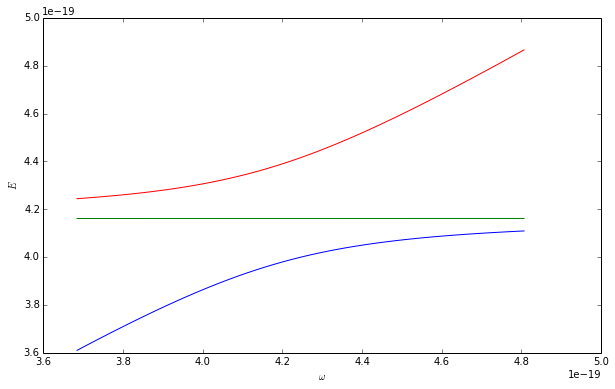

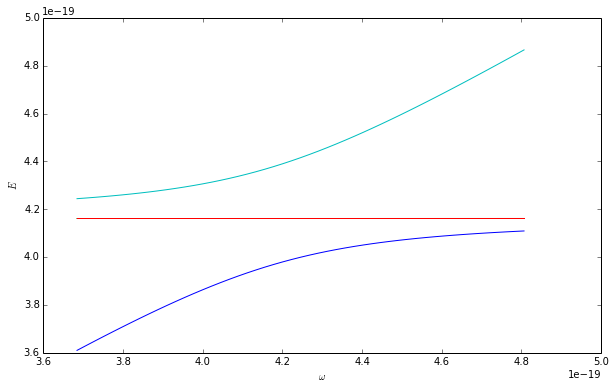

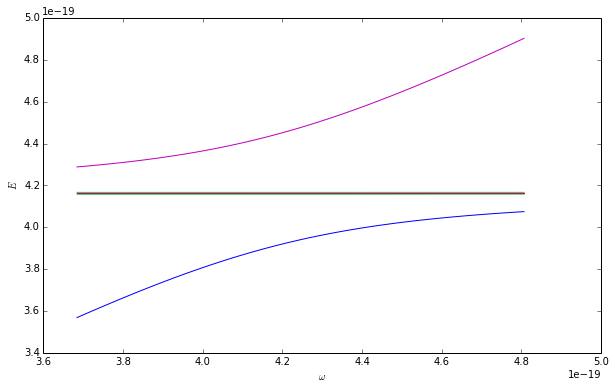

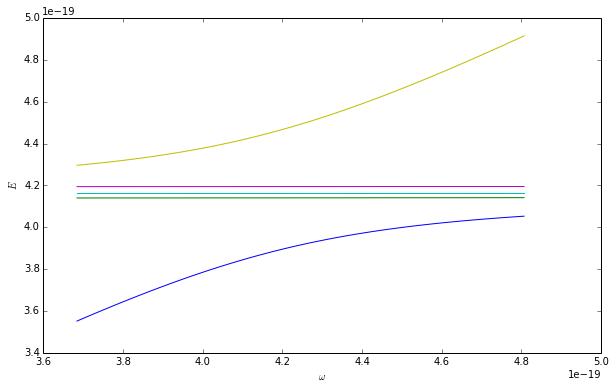

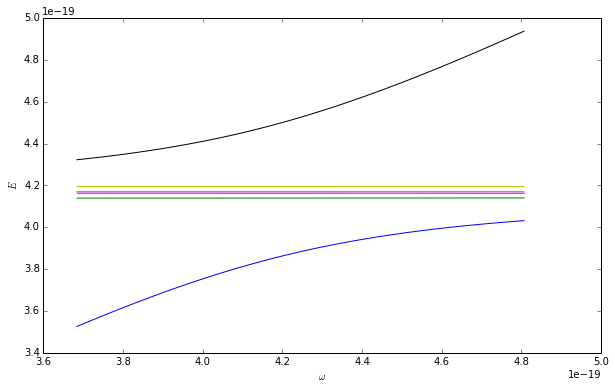

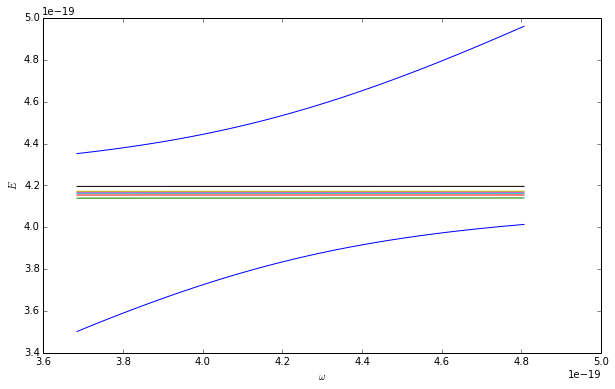

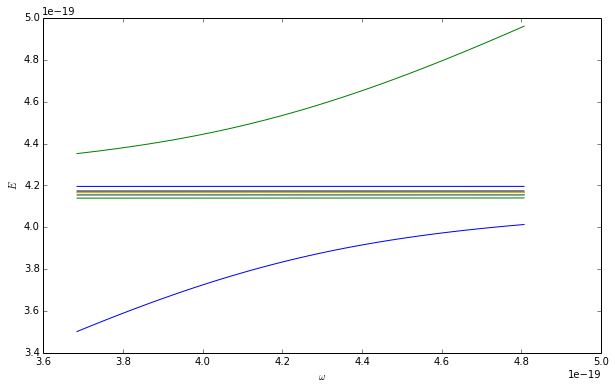

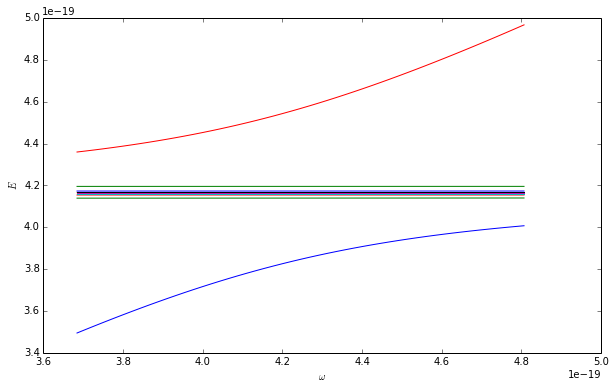

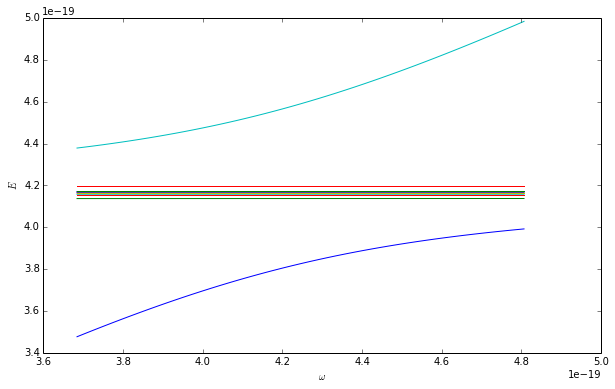

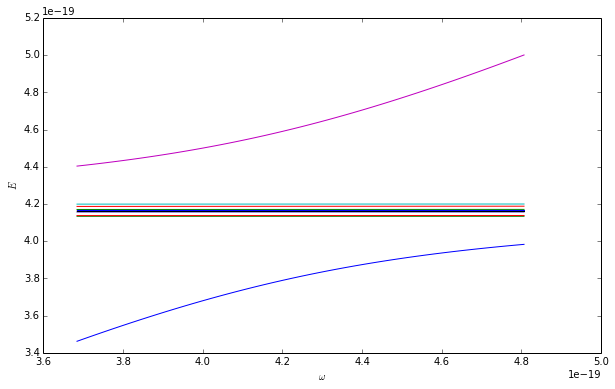

In [32]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 2*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#2-4

[[], [2.8631463678108167e-21], [-2.5657006453579524e-22, -9.1050817949773446e-22], [-1.5620611846278081e-23, -3.4337202584557236e-23, 3.0020433788295098e-22], [2.7828460980789424e-23, 1.837108929438995e-22, -7.9215002621646874e-23, -1.5847111170342736e-22], [-1.2500397065699517e-22, -2.5103950880752429e-22, -1.5476559924378477e-21, 3.0700031902814358e-22, -2.4595507690364174e-22], [4.7929766133465955e-22, -6.8650104727305712e-22, 1.46025921167818e-22, 8.721023991647337e-24, 1.1308223264495851e-22, 5.109705254804648e-23], [-2.4917886522460432e-23, -6.8571646340325979e-23, -1.4346374778502544e-22, 1.0115420120288441e-22, 2.9687941564987249e-21, 3.5361300824474525e-23, -9.5862668851861724e-24], [-1.4581994234959929e-22, -6.3858231834775206e-24, 1.537014508960595e-21, -1.8917181811258761e-23, 4.5725395203831029e-23, -1.6785865899781548e-22, 7.997828371312644e-23, -1.0970362113221635e-22], [-2.2453887827688191e-23, -2.7685484901045945e-23, -7.9494532966371848e-23, 1.2327441020431498e-23, -3

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


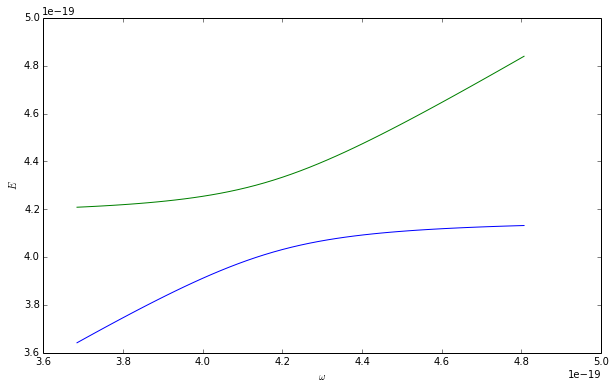

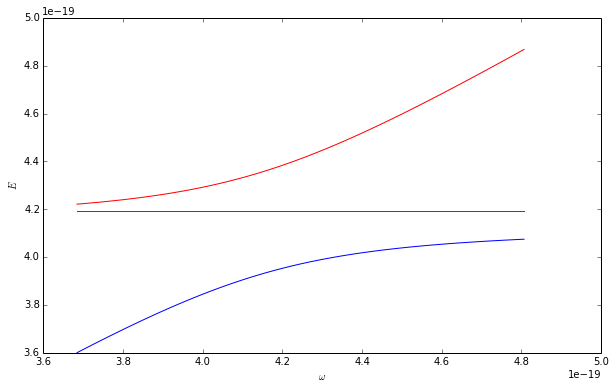

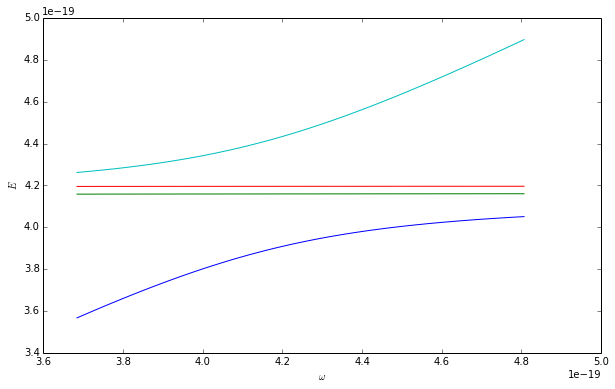

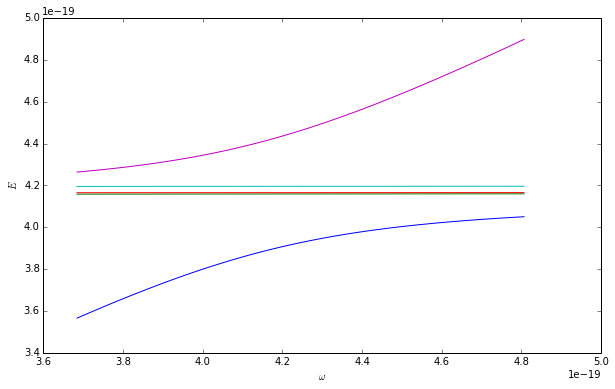

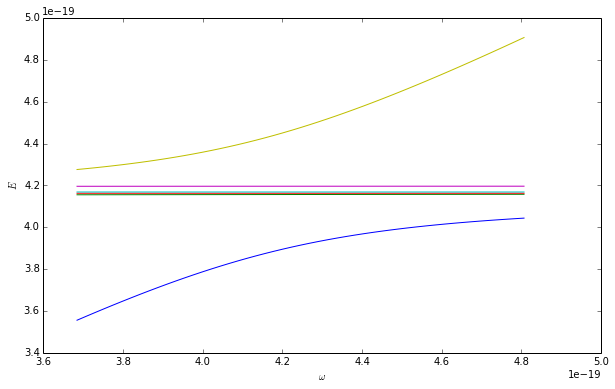

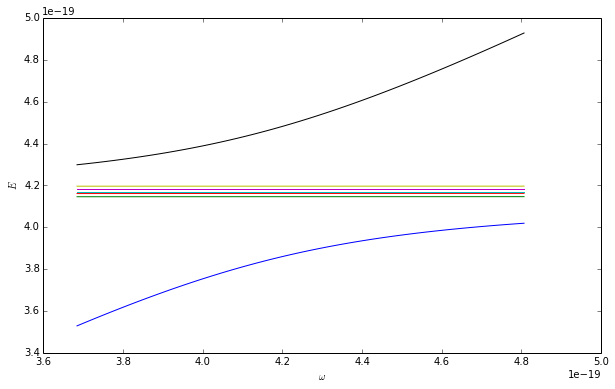

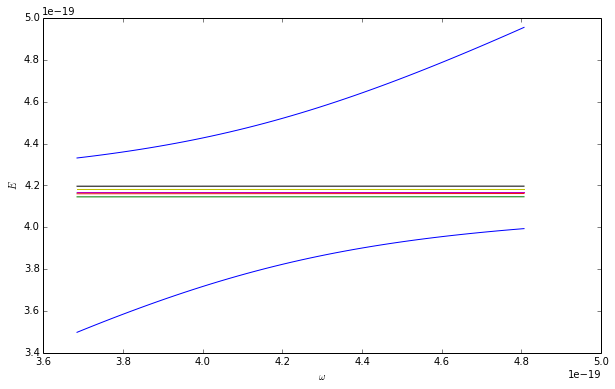

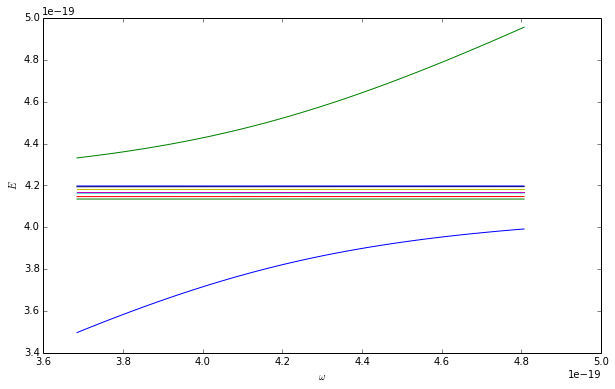

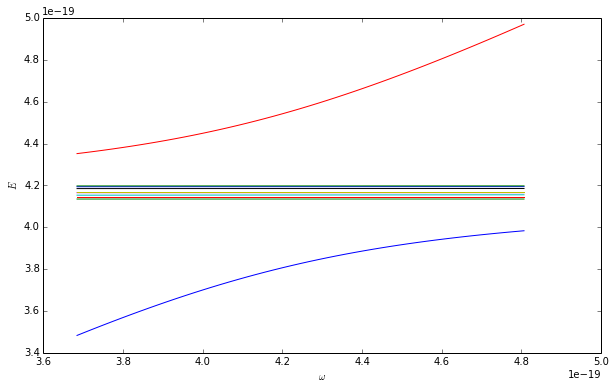

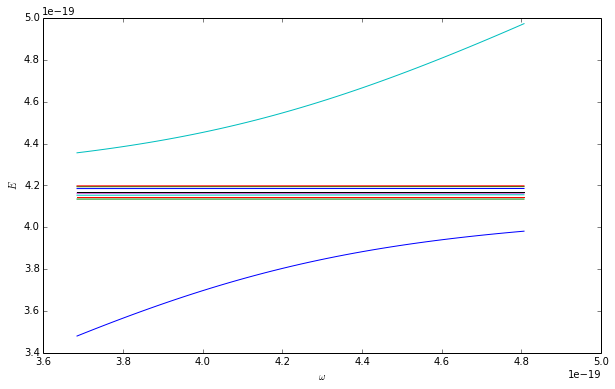

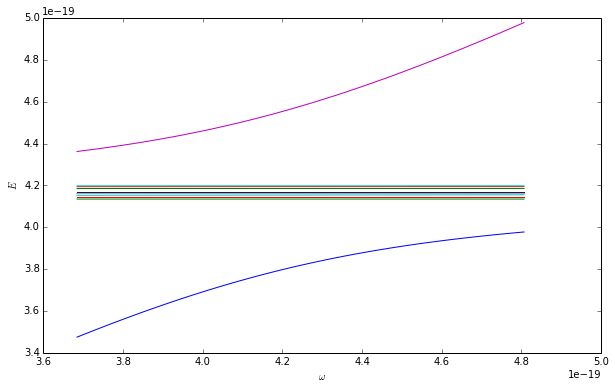

In [33]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 2*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#3-1

[[], [3.6217567822070523e-23], [1.820739355449472e-22, 6.8019691370995728e-23], [2.314839859347206e-22, 6.797321367510553e-23, 2.1936385634748837e-20], [-8.3690727886992938e-23, 5.3055500011460822e-22, 5.4737150283038366e-23, 7.8936431007274719e-23], [-1.7297010160614664e-22, 1.5810619810309789e-23, 2.1453169107582672e-22, 6.1366882454509128e-22, -2.0024705561068057e-22], [-1.3611419878503278e-22, 5.9101586921504499e-23, 4.1829817849131579e-22, 4.9720461553224515e-22, 4.5586823990302772e-22, -2.8669004428003447e-21], [5.3055410236304818e-22, 2.3384949674120323e-23, 5.2767132347131701e-22, 1.2398336315172132e-21, 3.6305919069819702e-22, -2.1610915853490145e-21, -1.554787680392619e-19], [-5.222421992139638e-22, -2.4314732149720562e-23, -6.474091626972301e-23, -5.1743242834496917e-23, 3.6490885520128603e-22, -1.4149642871053279e-21, 7.7448112335970698e-22, 4.820384656470431e-22], [-3.7609766142524193e-21, -1.0318045312894886e-25, 1.2393386233650522e-22, 2.6613636272726977e-22, -5.13846530

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


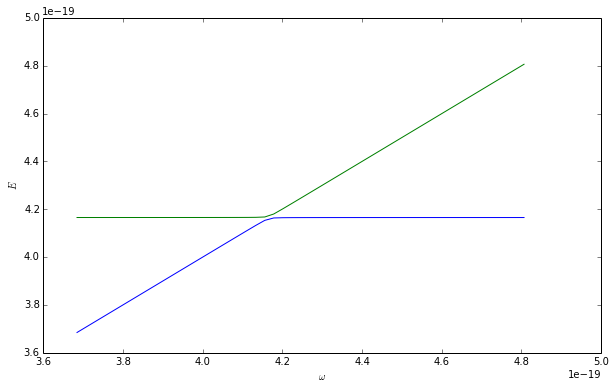

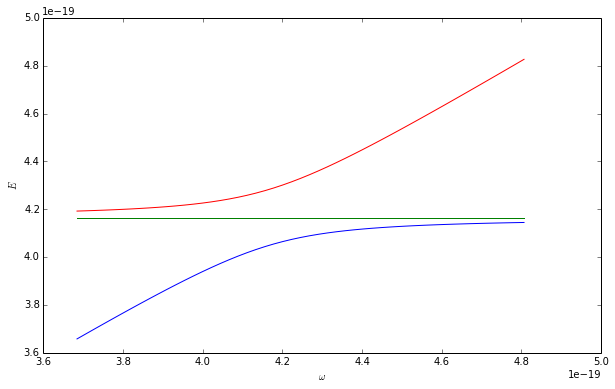

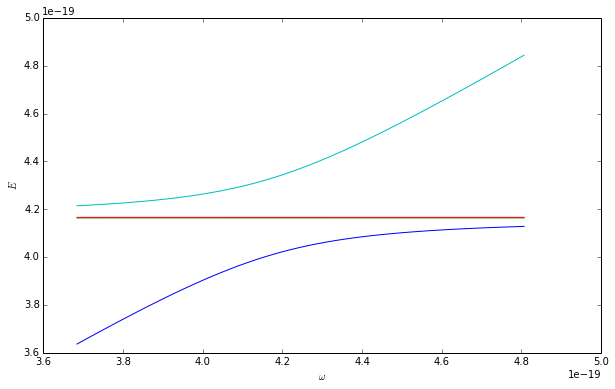

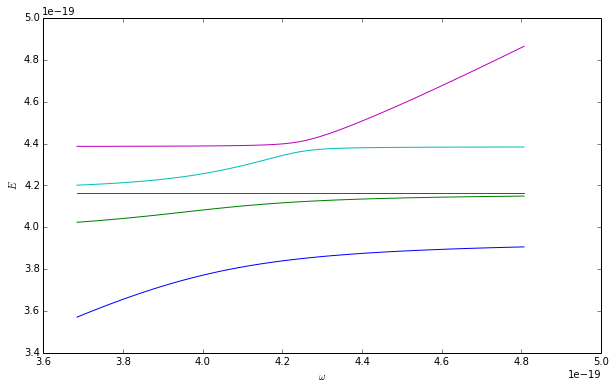

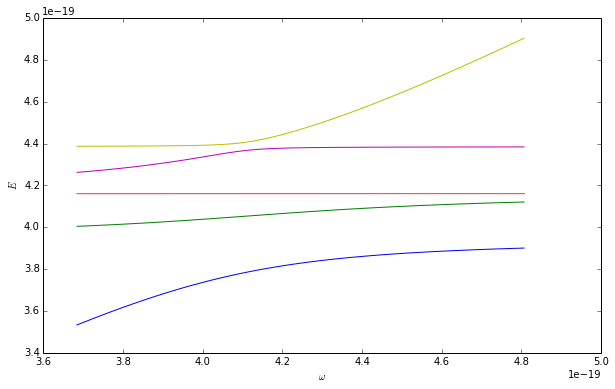

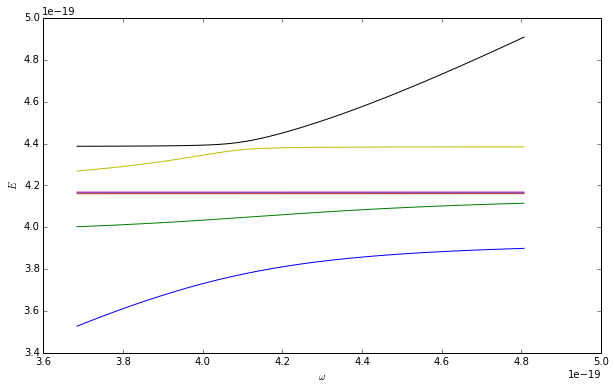

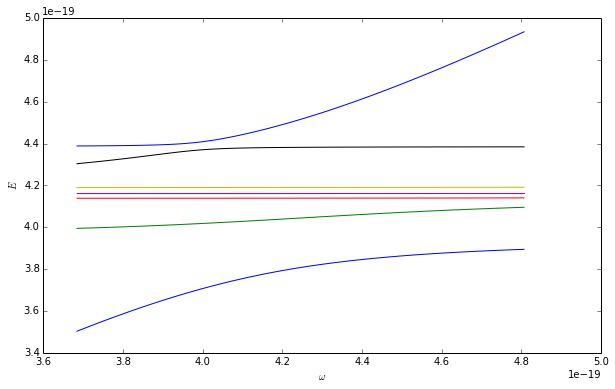

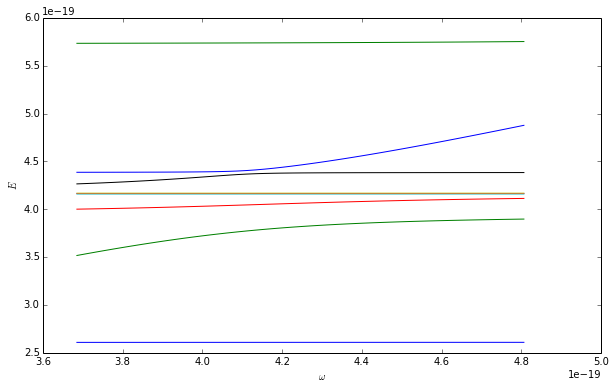

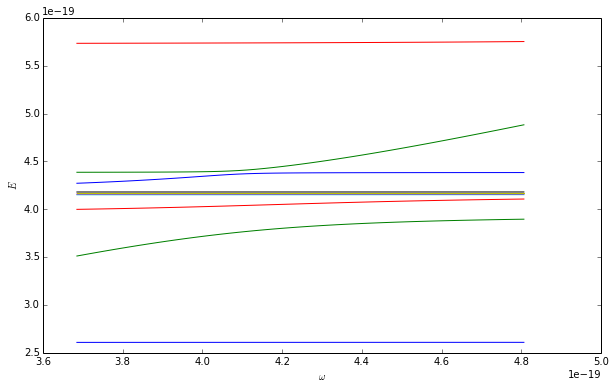

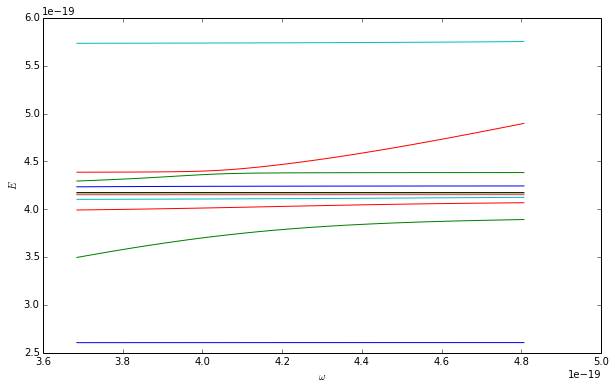

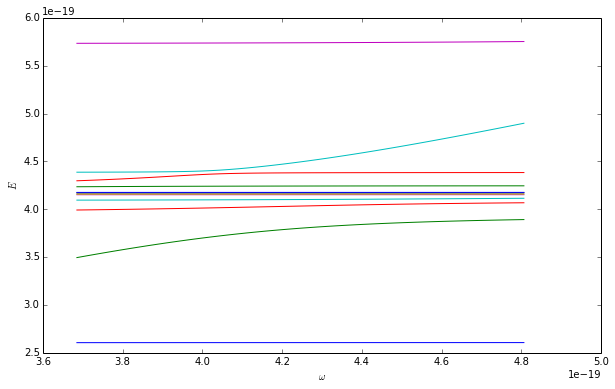

In [34]:
# Box size even more reduced
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#3-2

[[], [-2.2340518353585938e-21], [2.5699013806255034e-23, -4.1033982533491128e-23], [-2.385538240337193e-23, -1.5040484472452366e-22, 1.2382607379988434e-22], [-4.4362809521391467e-22, 1.5978925262992872e-22, -2.676910787309652e-22, -5.6946865355001056e-23], [3.4012004531383572e-22, -2.8323001514323744e-22, 4.233189064177915e-23, 3.7872251930181718e-22, -2.4200186786688531e-22], [7.9064766550613367e-23, -1.7185567337829434e-23, -4.787545246837334e-23, 1.0906498920144039e-24, 8.632937051179936e-24, -1.1293235671270973e-21], [-5.1556683044014792e-23, 1.2431875683125096e-23, -2.9326992991163681e-22, 2.6850983843580435e-23, -1.8932206727541894e-22, 2.832472341608429e-23, -1.1063891726705182e-23], [-1.3669046947683804e-20, -2.4398739187111537e-22, -1.8616857134192603e-22, -1.9359246745911904e-22, 2.4049088468012452e-22, -1.2561195808162628e-22, 6.2725354535906923e-25, -7.010472788892548e-23], [-1.1855198775438337e-21, 3.2336428842351164e-21, 1.602695869842674e-24, -1.0849417521158657e-22, 1.

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


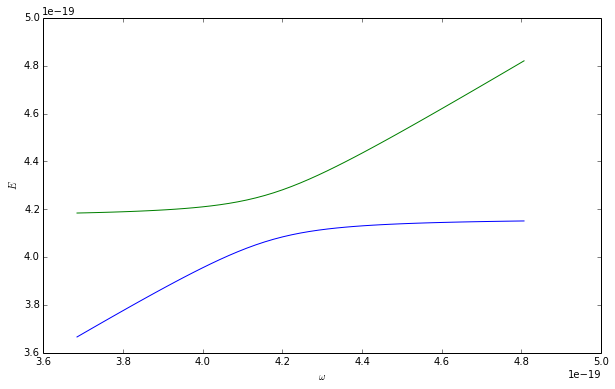

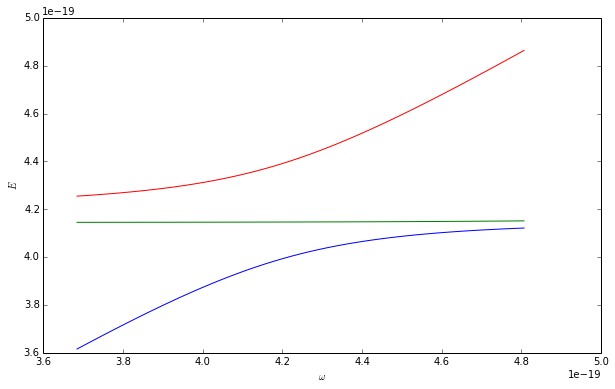

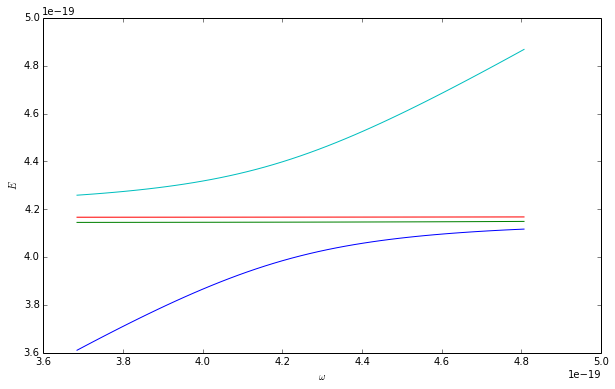

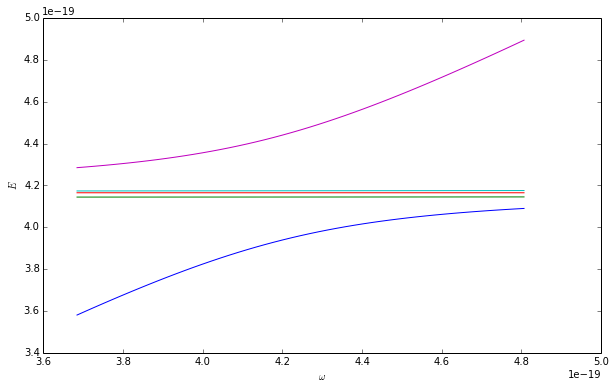

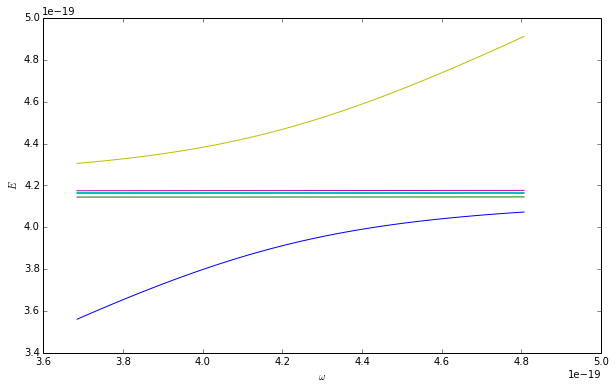

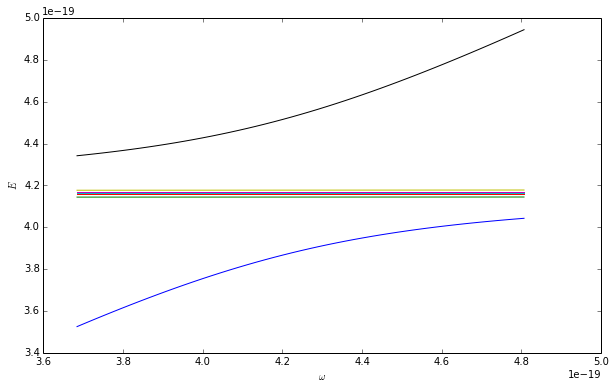

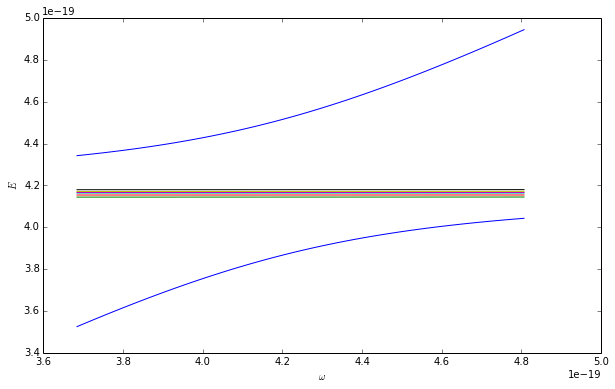

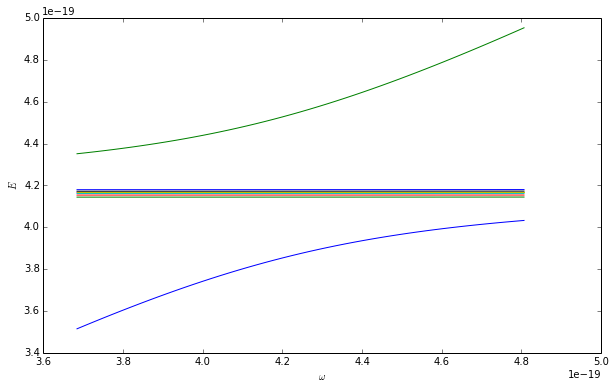

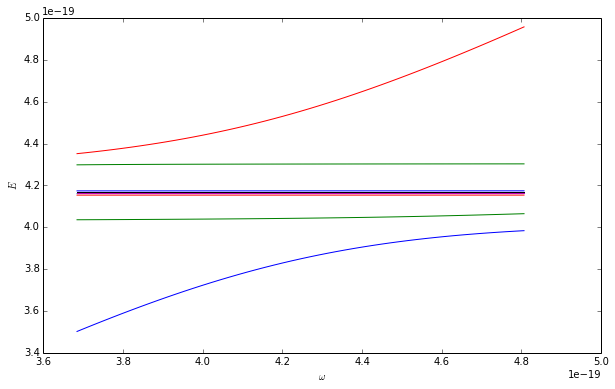

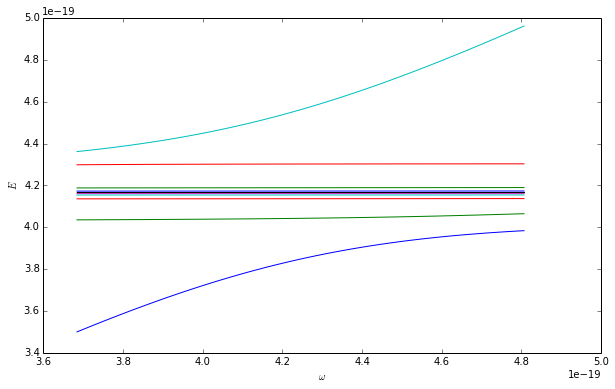

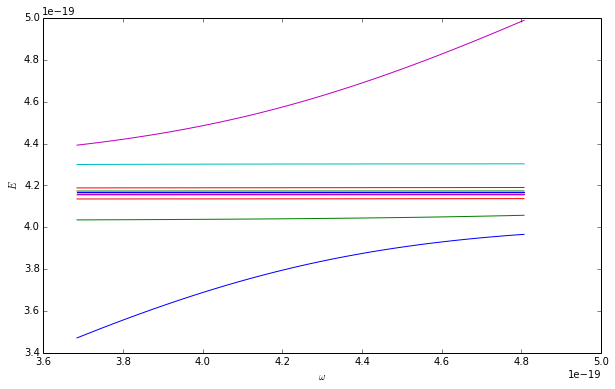

In [35]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#3-3

[[], [-6.6889212349509999e-21], [1.2531467054195998e-22, 2.9723217588198587e-22], [-5.0771227440865166e-23, -1.0520264637391126e-22, 8.5558496835063494e-23], [8.07120693197935e-23, 1.7913479738586647e-22, 8.4374863551858687e-24, -1.8691391003989482e-21], [1.879379782391833e-22, -3.7143290034097605e-23, 5.8635321057526588e-23, -3.893622229226742e-23, 4.0284905329371582e-23], [2.011601427980353e-22, 6.4482903480713176e-22, 1.8038285844706567e-22, -7.0309291231606431e-22, 7.4210002022042134e-21, 1.222486921155457e-22], [2.5892651636160779e-23, 8.0689490223564946e-23, -2.7892825857458347e-24, -9.0694874291433693e-22, 2.8800598729725828e-22, 3.0808788588563798e-23, 4.4236476898282807e-22], [1.876136609625394e-20, 1.0294118449009833e-21, 1.227993605169587e-22, 8.0748305057602397e-24, -1.0678014099628591e-22, 7.6643633664244571e-25, -4.1300275808503622e-23, 3.0902935509234928e-23], [-1.6323245906302877e-22, -2.1796114172770561e-22, -1.6462010543192717e-22, 2.9491324274673678e-23, 4.4399279034

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


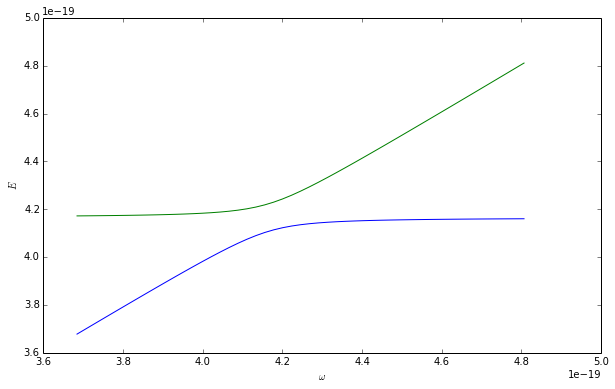

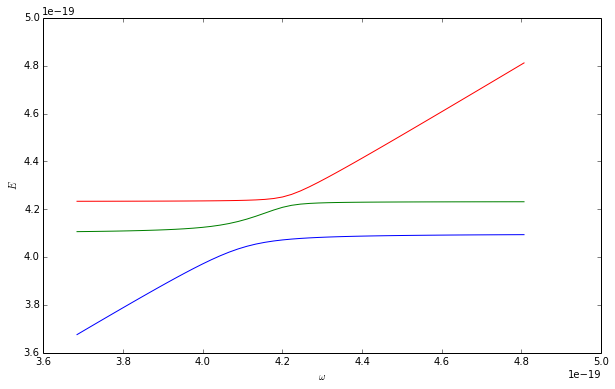

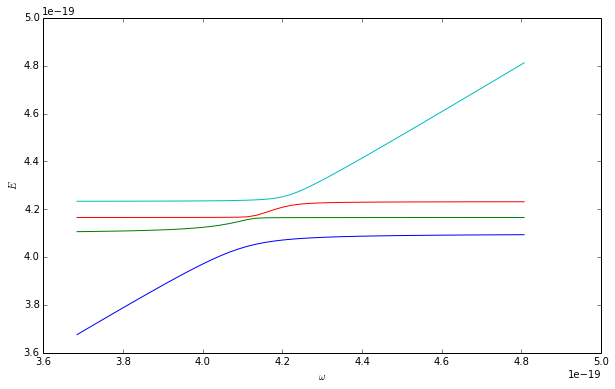

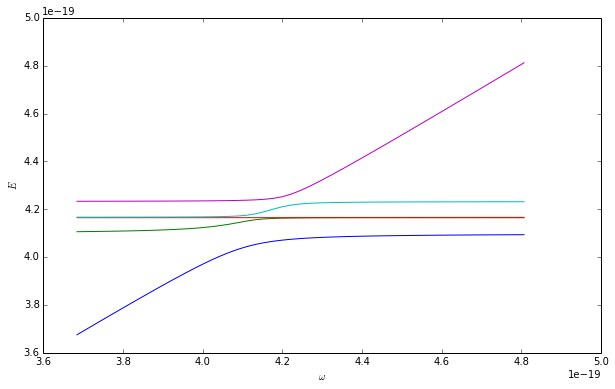

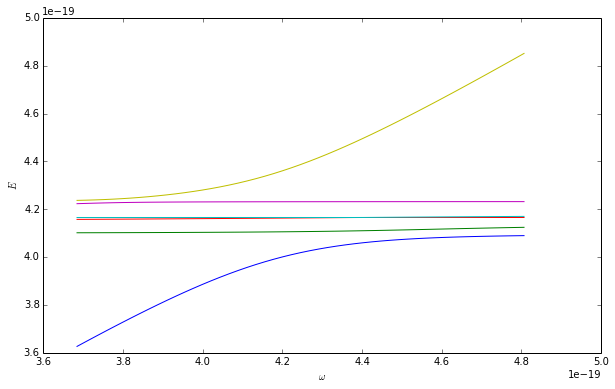

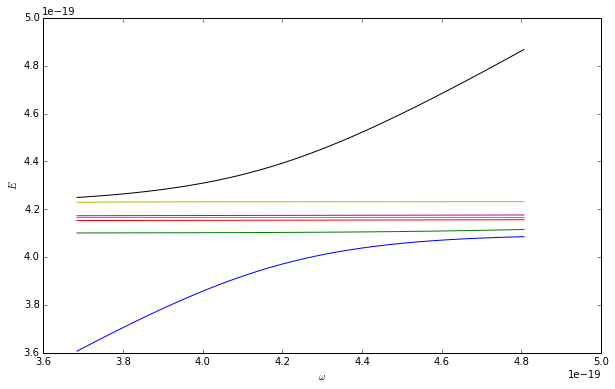

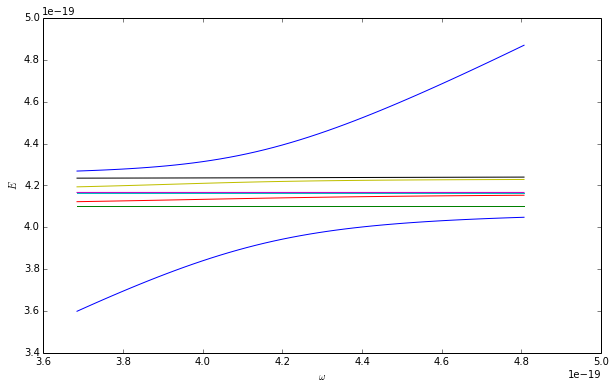

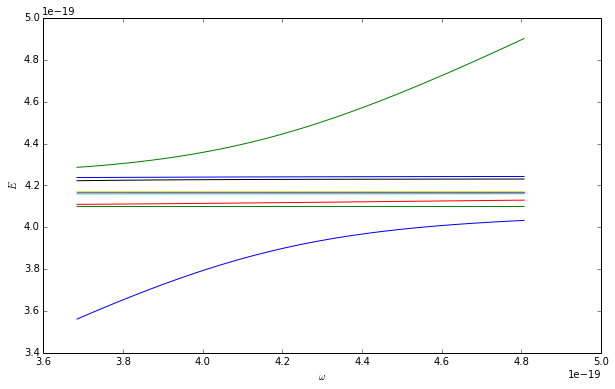

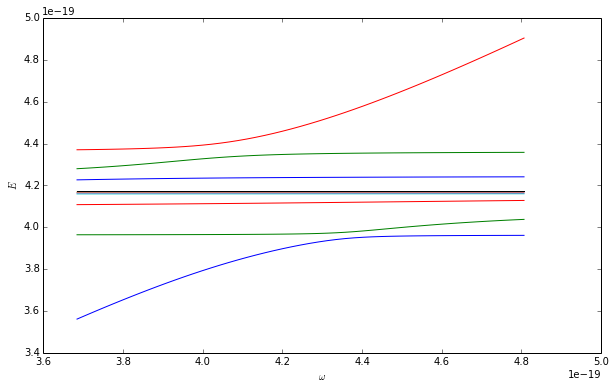

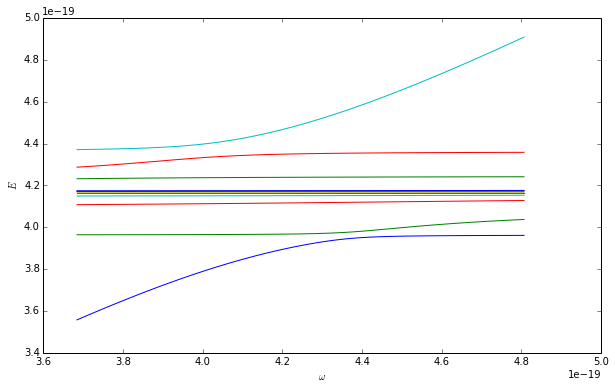

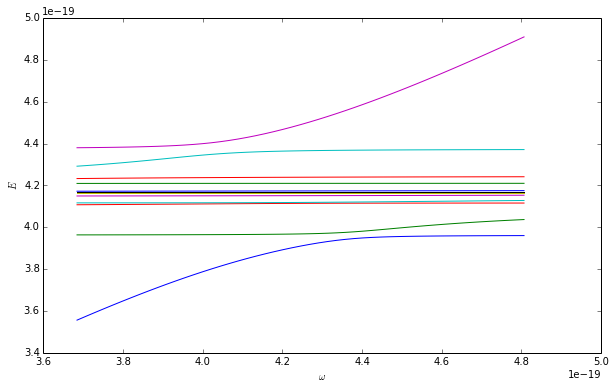

In [36]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

#3-4

[[], [2.4555453234549017e-21], [-1.0600680773932921e-22, 2.5238129158198184e-22], [8.5130371469094342e-23, -1.1389982764243981e-22, -1.3671176776184048e-22], [-1.184430279370951e-23, 8.0396752334437355e-23, -3.3019552731079082e-23, -1.5748568188229256e-24], [2.4271697487740146e-22, -2.8293812751419288e-22, -8.7825544404008103e-22, 2.6525848317869997e-22, 1.4368470390746223e-22], [3.3848211272467762e-21, 7.4297984591449449e-22, -6.132380379895549e-23, -3.0739140239056441e-23, 1.1134403460308084e-22, 1.8111038562939869e-22], [1.5442159044647551e-22, 5.5933107604513347e-23, -1.3280158678479674e-22, -2.6346104657437875e-20, 1.7695405049207334e-21, 3.8730553911831247e-22, 2.0815945289119987e-22], [8.0244548068806954e-23, -1.7809477178147253e-22, -7.1248334428990812e-22, 2.1297014112686446e-23, -1.063194225007437e-23, 1.4292219507103403e-22, 3.8413609983032212e-23, 5.6319667462802707e-24], [-6.2470363154508452e-23, 1.8589534406916328e-22, -6.9640588582962537e-23, -1.1406970538153797e-21, -4.

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


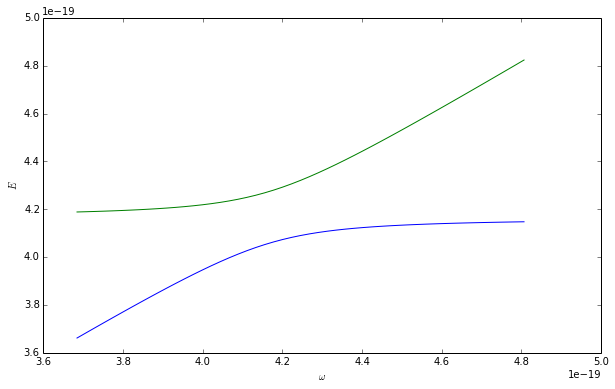

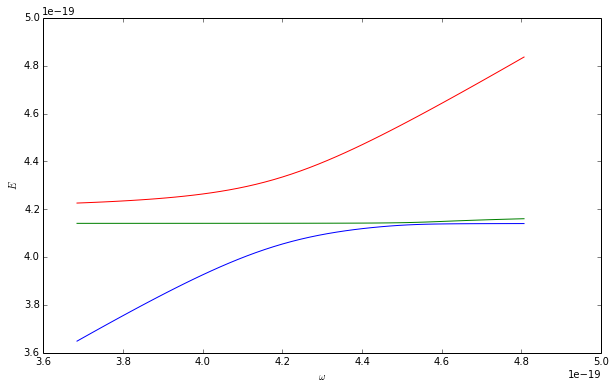

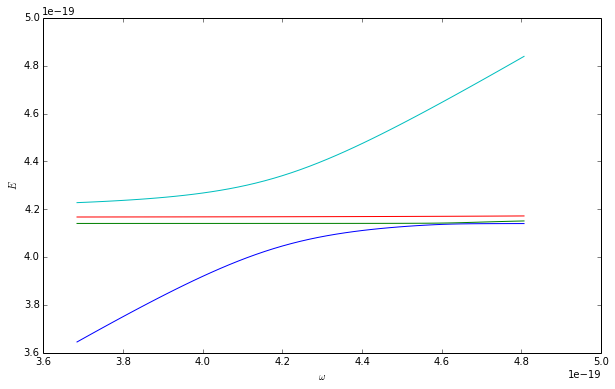

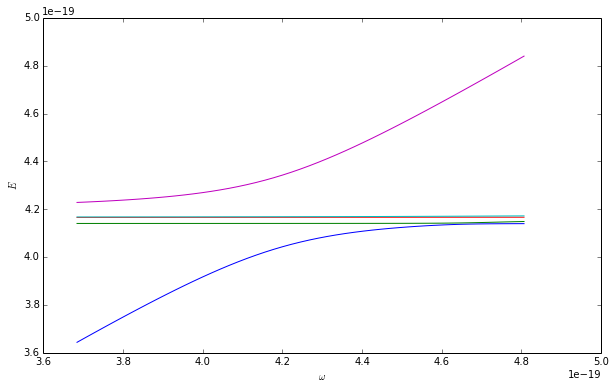

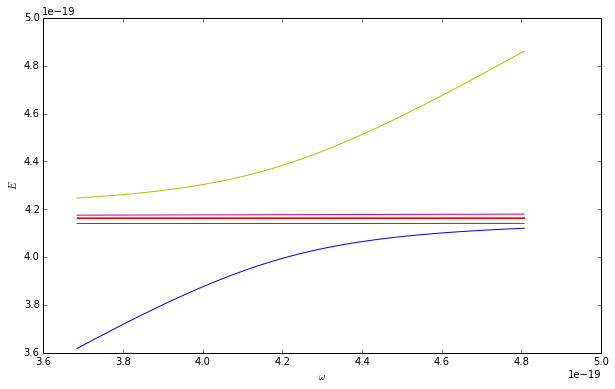

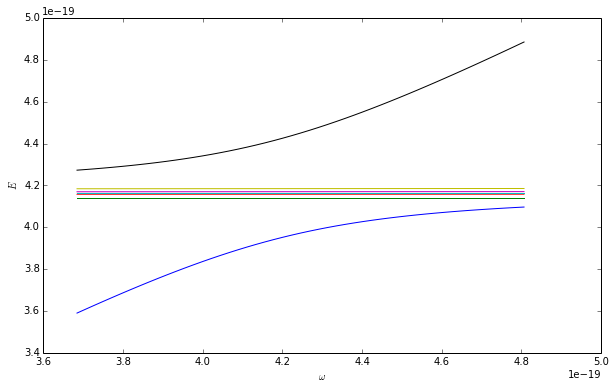

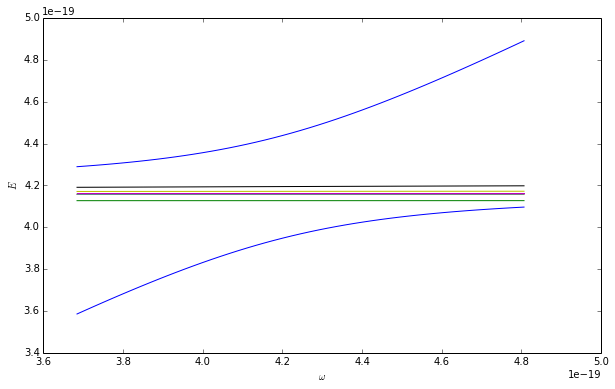

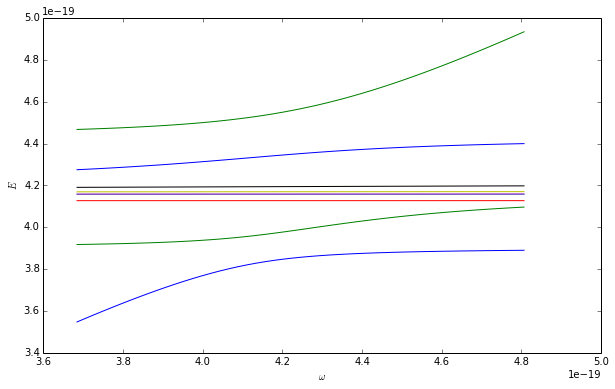

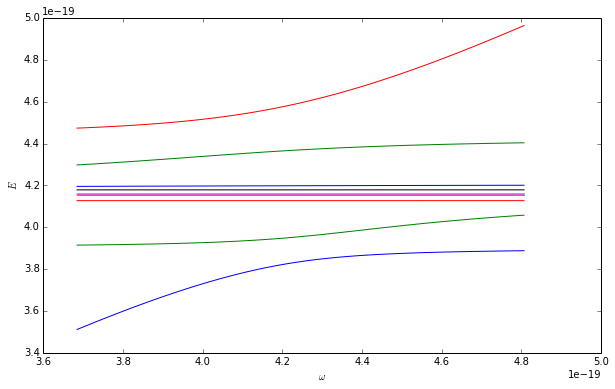

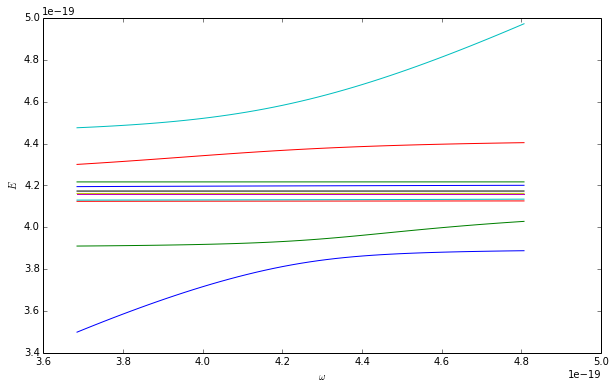

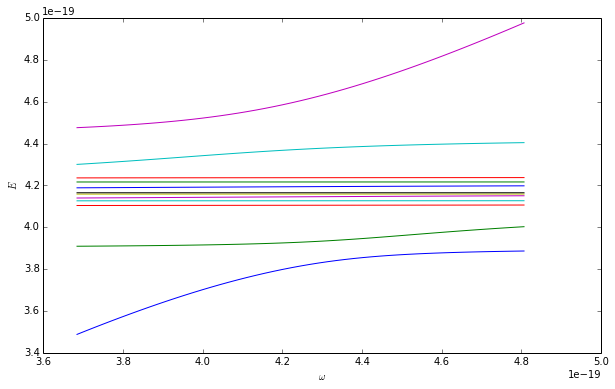

In [37]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

[[], [1.153923266474719e-24], [-8.9514863034742892e-23, -7.0940236176175033e-24], [1.680058521457354e-23, -2.752889208815675e-22, -5.9712421282570812e-23], [2.4730549971668671e-23, 2.1177713072506142e-23, 1.5503202748780607e-21, 1.7549528797961991e-22], [1.4503018763183371e-23, 5.7398128886793844e-25, -3.5167286001516315e-24, 3.0714803331873852e-24, 1.846728574703708e-24], [-1.3981727734331741e-22, 6.1738895245137223e-24, 3.6855268319165382e-22, -4.6780023637028699e-23, -6.1028317153834249e-22, -7.5633649968260264e-24], [-2.9266347636076401e-23, 1.7255538299483703e-23, 9.4796997391615354e-22, 3.2611878902396366e-23, 4.2940514172251538e-22, -3.1417538620734696e-24, 4.730016798622789e-23], [1.7778353978417336e-23, -1.1287915256037855e-24, 4.2790244345207457e-23, -3.76780773476402e-24, -1.5077908196091179e-23, 2.6225972428876937e-24, 3.7049213239508316e-24, 9.9729274023788793e-24], [3.3023268950793481e-23, -1.1918899168443397e-24, -1.9545740393090895e-23, -3.2606910837721397e-25, -2.61424

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


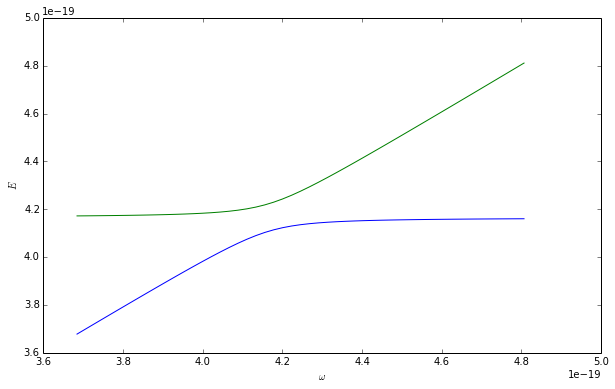

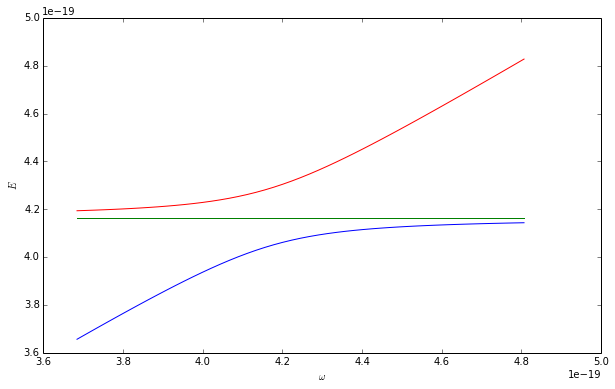

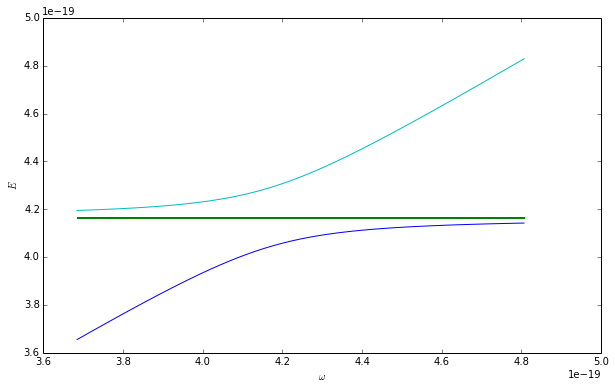

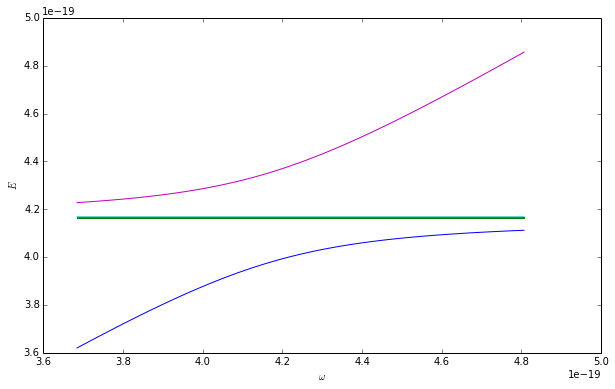

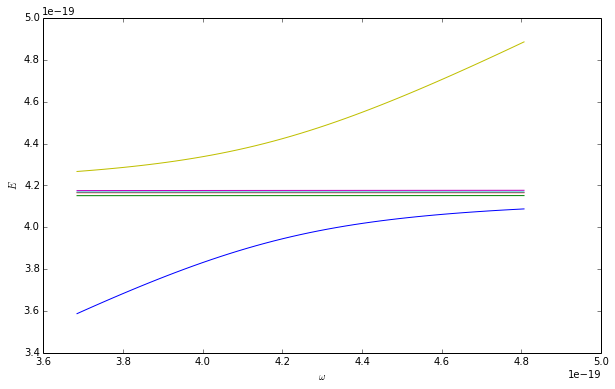

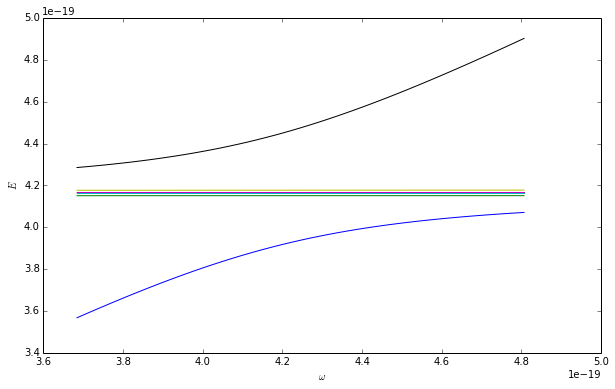

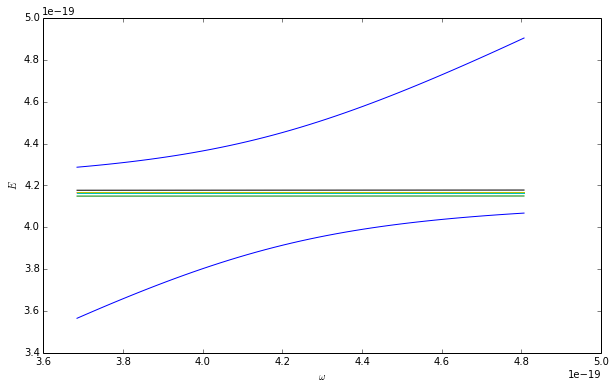

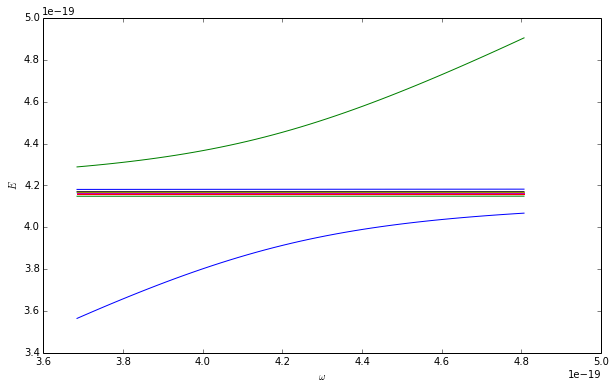

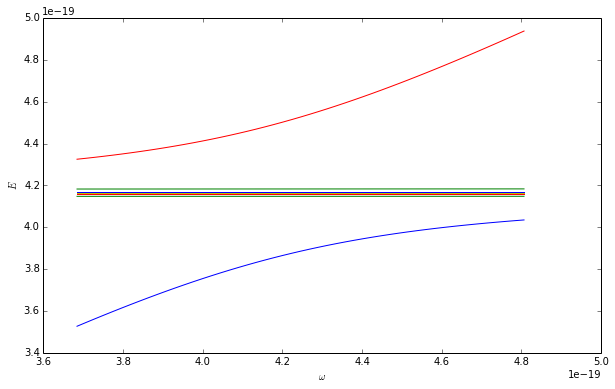

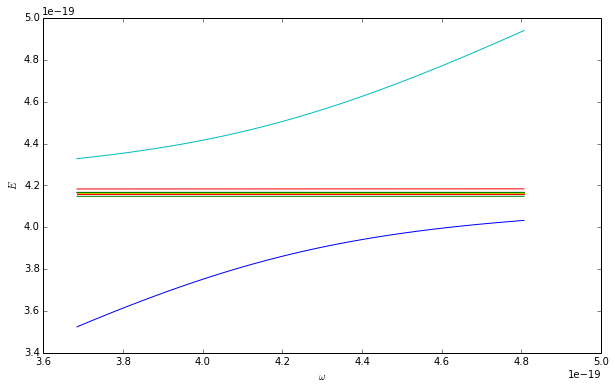

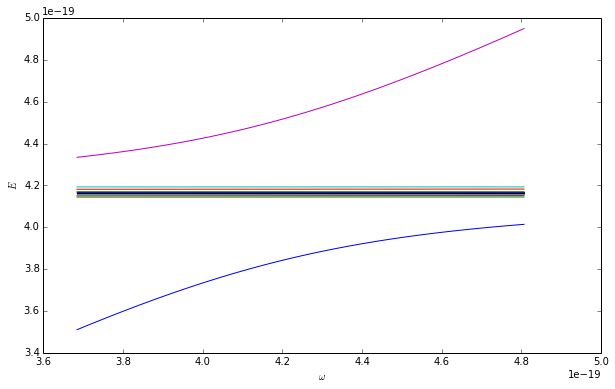

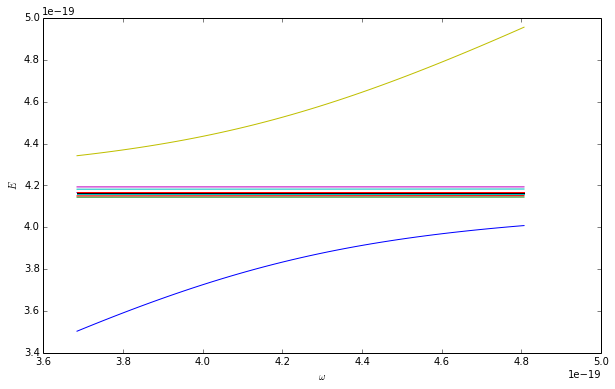

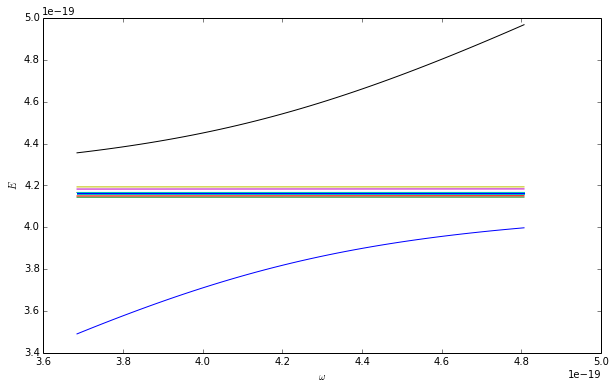

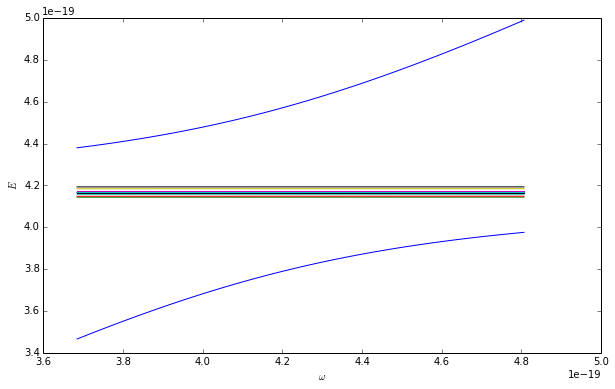

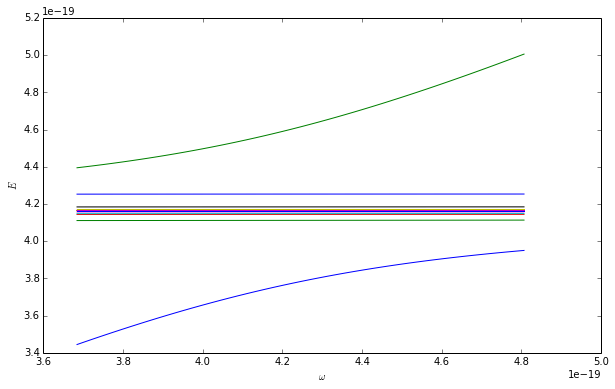

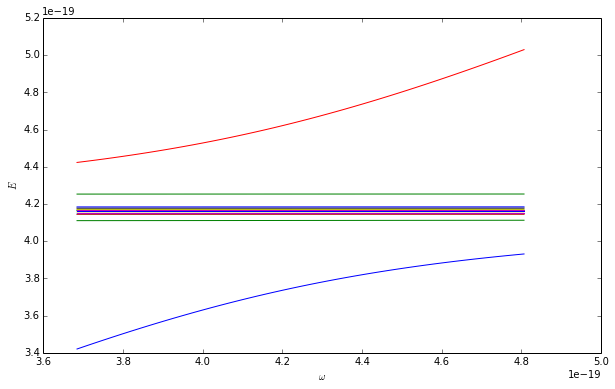

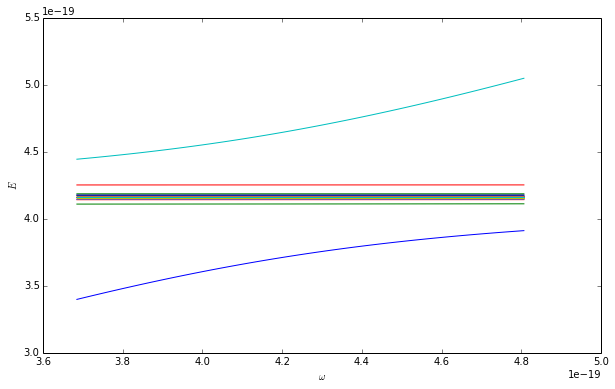

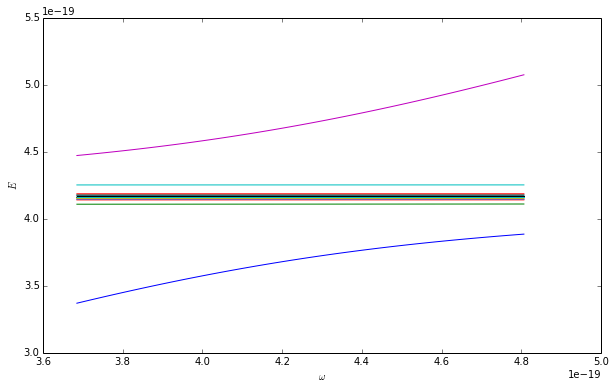

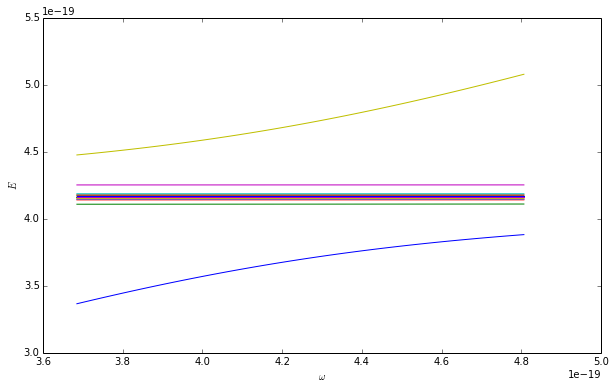

In [5]:
K = 19
poss = randomPositionBox(K=K, x = 5*nm, y = 5*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

[[], [-1.8377867776508406e-23], [4.8229362635005423e-24, 2.9003441212549737e-23], [4.5053258058323383e-24, 1.6538846652082074e-23, 5.2862969337612629e-23], [-1.0098288488302897e-23, -6.5899429580114631e-24, -8.4851493585489369e-24, -1.6721896368418616e-23], [-8.7903405263167522e-23, 3.8715653176959202e-23, -6.9844202955463857e-25, -6.8599562279765888e-25, -6.6809211850843197e-24], [9.940990487679842e-24, -3.9153562604180625e-22, 1.8722641906492383e-24, 2.6176028974896e-24, -5.0293671488681288e-25, 6.1748694342630145e-23], [6.0763226133574463e-24, 6.9307026618712418e-23, 8.920912207466913e-23, 1.7898886679339883e-23, -6.184340450071072e-24, -2.9154542896839709e-24, -3.0814243466179299e-24], [3.8023986422156125e-24, -3.9900325590965417e-24, -2.9462724712123974e-24, 2.5628791765282376e-25, -1.7532774776026645e-21, 1.477696682389165e-23, 2.6269695533714049e-24, -2.5766948195270112e-24], [1.0469893455525097e-23, 6.689830296375915e-23, 1.7458282352585342e-23, 7.9529827966952767e-24, -5.26556

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


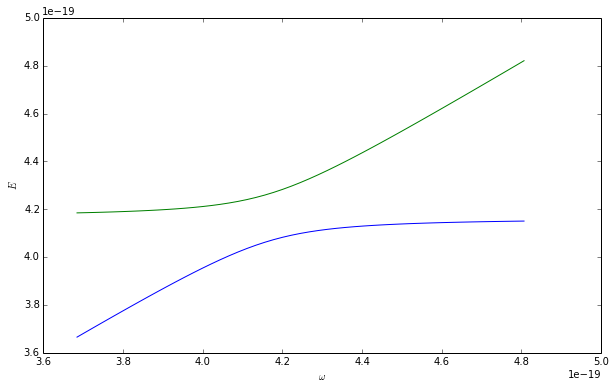

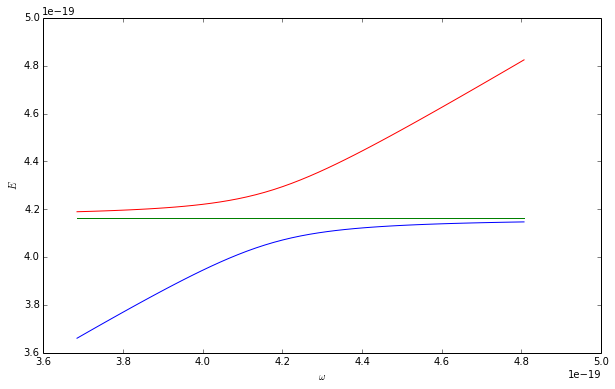

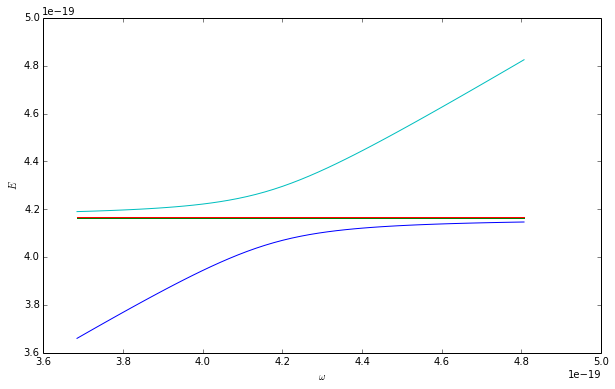

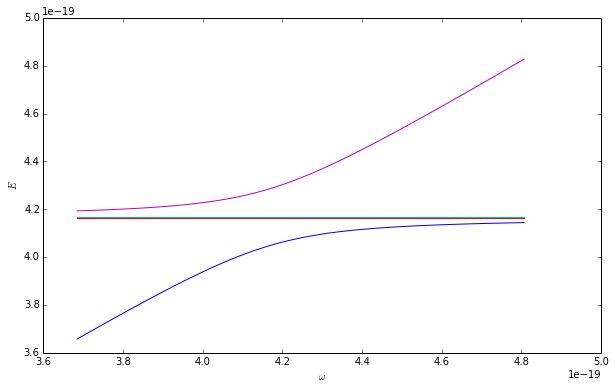

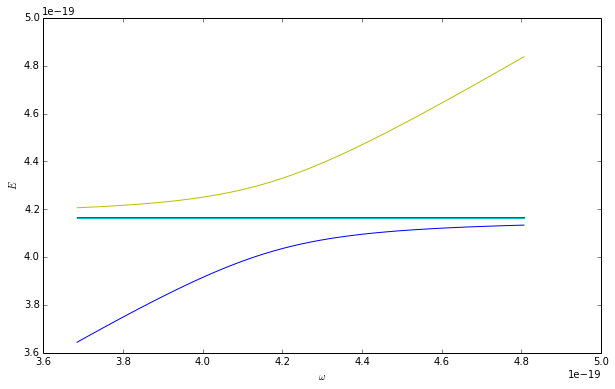

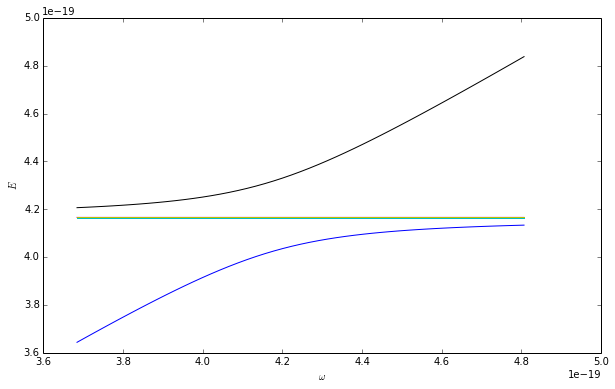

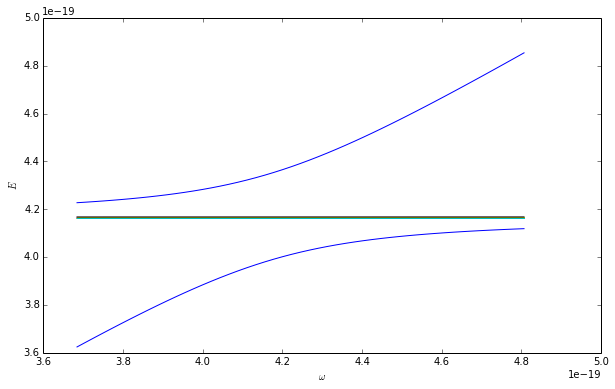

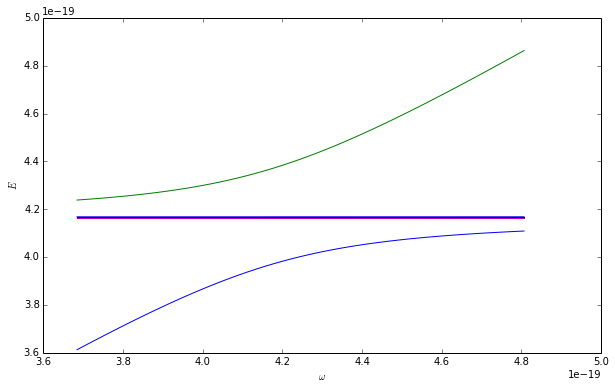

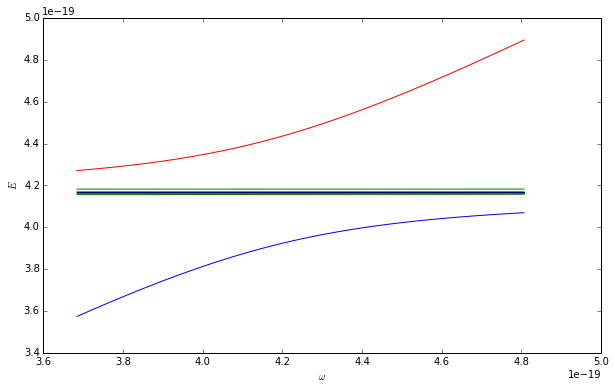

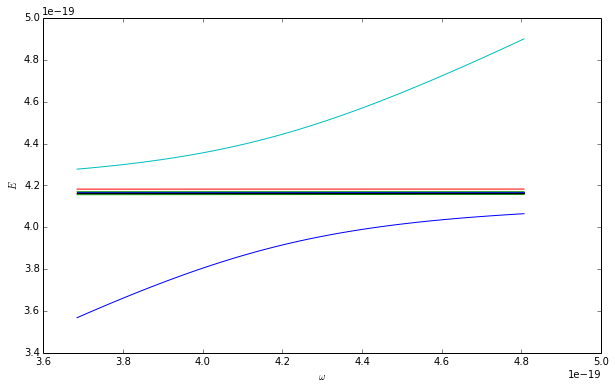

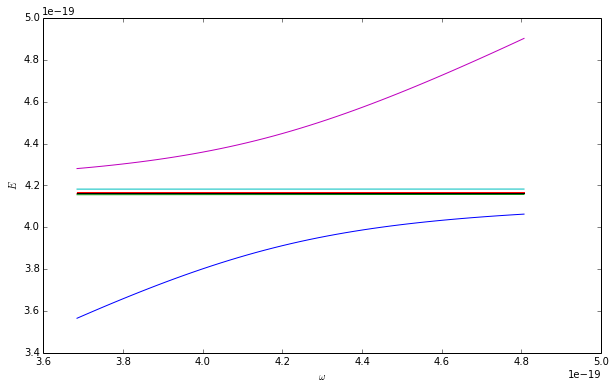

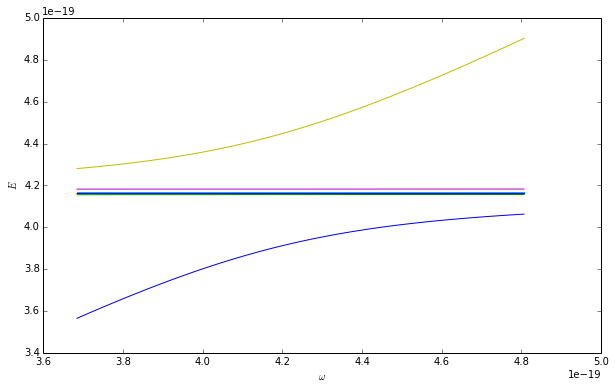

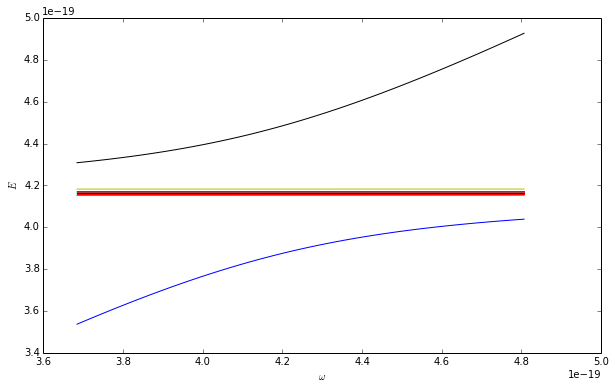

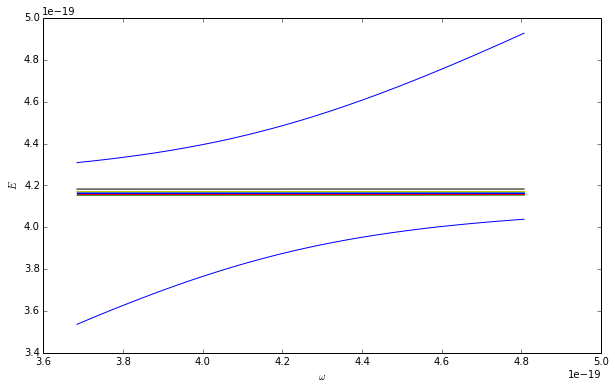

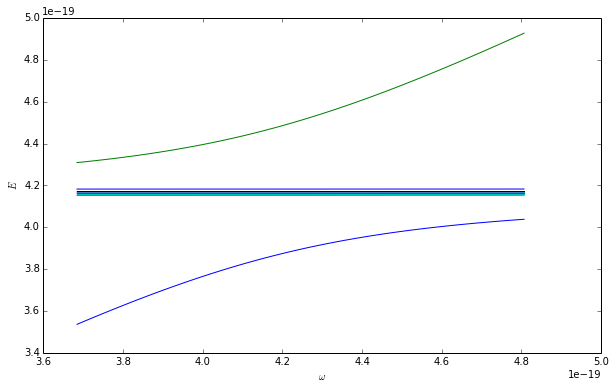

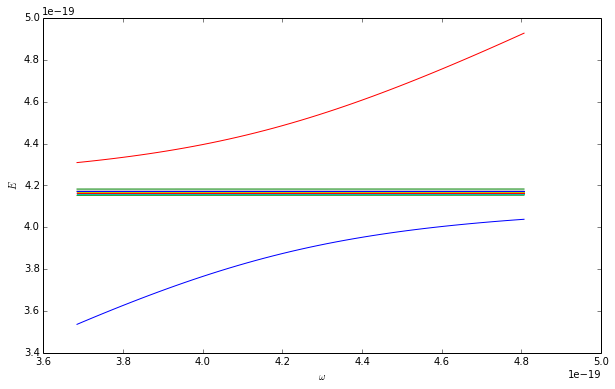

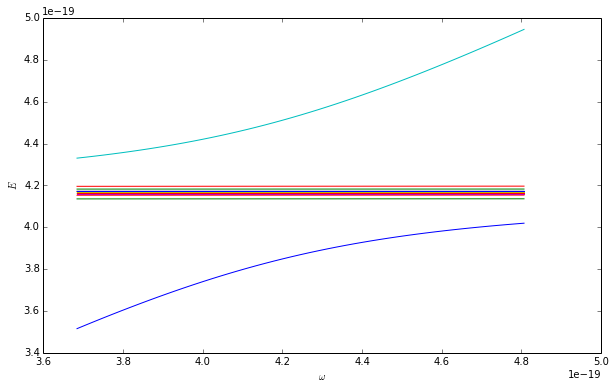

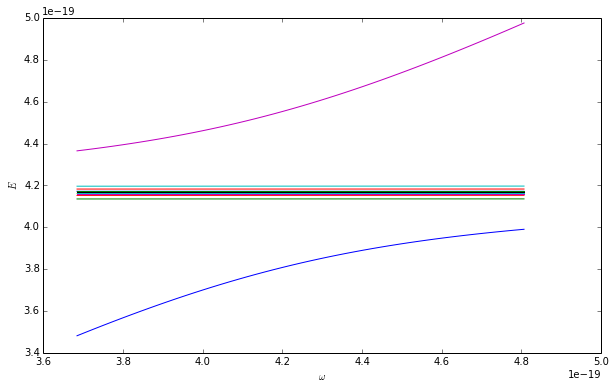

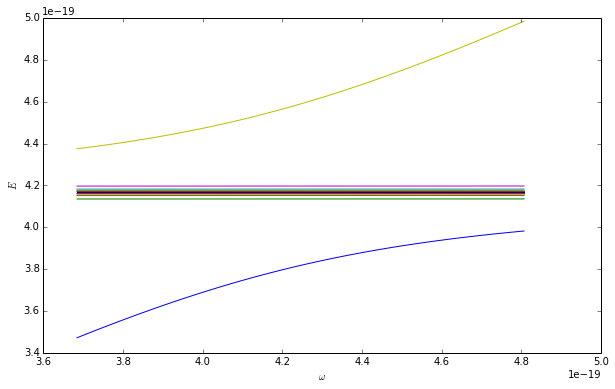

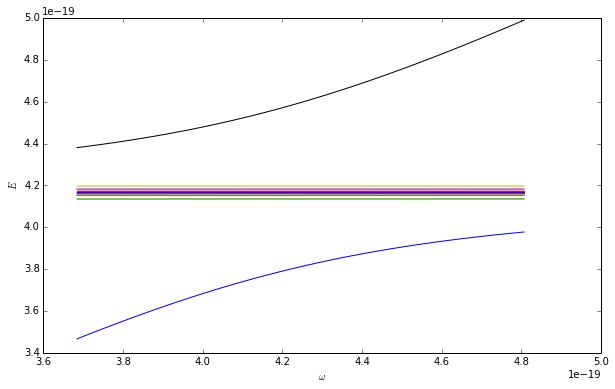

In [6]:
K = 20
poss = randomPositionBox(K=K, x = 5*nm, y = 5*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

In [ ]:
K = 21
poss = randomPositionBox(K=K, x = 5*nm, y = 5*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs
dicke_tryparams_proj(K=K, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1, sparse=True)

In [5]:
ddim(5,2)

16

In [12]:
tau=1
a=range(11)
a[ddim(5,tau-1):ddim(5,tau)]

[1, 2, 3, 4, 5]

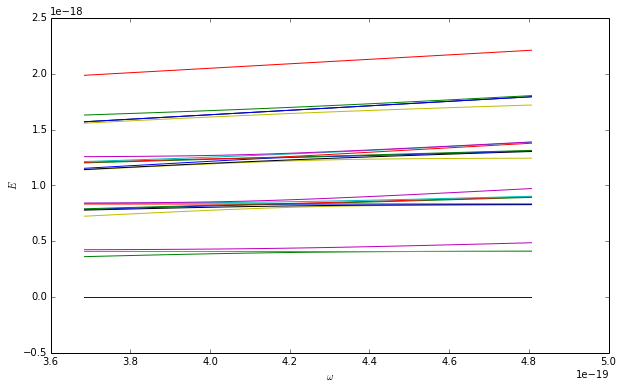

In [17]:
dicke_tryparams(K=3, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, bdim=3)

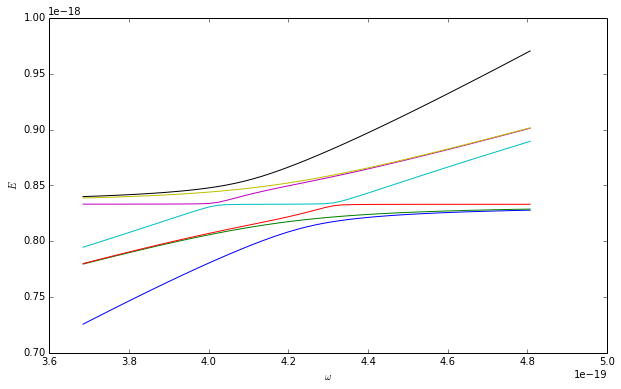

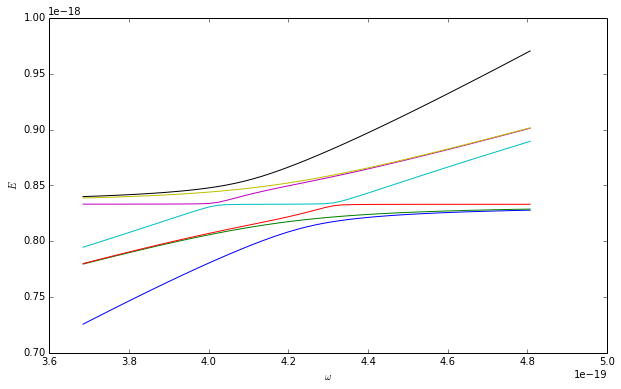

In [10]:
dicke_tryparams(K=3, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, bdim=3, tau=2, dRWA=False)
dicke_tryparams(K=3, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, bdim=3, tau=2, dRWA=True)

In [5]:
K=3
tau=1
H=dickeH(K=K, epsilons=2.6*eV,Vs=Vs, omega=2.4*eV,gs=gs, bdim=3)
eigs = H.eigenenergies()
print eigs
eigs.sort()
print eigs
eigs = eigs[ddim(K,tau-1):ddim(K,tau)]
eigs

[ -2.40741334e-35   3.76310972e-19   4.16564827e-19   4.16569035e-19
   4.24775262e-19   7.54377353e-19   7.93547137e-19   7.94249862e-19
   8.13021127e-19   8.33249688e-19   8.40663220e-19   8.42596653e-19
   1.17001655e-18   1.17242758e-18   1.18540934e-18   1.21154367e-18
   1.23059457e-18   1.23087998e-18   1.25862057e-18   1.58790217e-18
   1.60217549e-18   1.60217969e-18   1.64849244e-18   2.01874247e-18]
[ -2.40741334e-35   3.76310972e-19   4.16564827e-19   4.16569035e-19
   4.24775262e-19   7.54377353e-19   7.93547137e-19   7.94249862e-19
   8.13021127e-19   8.33249688e-19   8.40663220e-19   8.42596653e-19
   1.17001655e-18   1.17242758e-18   1.18540934e-18   1.21154367e-18
   1.23059457e-18   1.23087998e-18   1.25862057e-18   1.58790217e-18
   1.60217549e-18   1.60217969e-18   1.64849244e-18   2.01874247e-18]


array([  3.76310972e-19,   4.16564827e-19,   4.16569035e-19])

In [28]:
ddim(K=4, tau=1)

5

In [11]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs

[[], [-2.4485391786381634e-22], [3.1554616108377898e-22, 4.0241716428120271e-22], [4.1886042182680476e-22, 3.0346892140922468e-22, 6.976280937023967e-22], [-2.5582143115945824e-21, 5.6050958696032213e-23, -9.5232845325860141e-23, -7.229958398157341e-23], [6.7280951213706655e-23, -4.4762551465454879e-22, -6.2193756875294258e-23, -9.0070350387393351e-23, -7.3223988860135421e-23], [-4.6050232623982101e-22, 4.8410774803291541e-21, 6.1281666530700413e-23, -1.1096370682897849e-22, 1.7750534203857332e-23, 3.3237062124378023e-22], [-2.0927628575582421e-21, -8.6499383739890942e-23, 2.1258123375645062e-22, 5.5529143389473682e-22, -5.8459667295864393e-21, -3.0968107293592089e-23, -1.1647225561015025e-22], [3.9790940887264361e-22, 2.2920713195231216e-21, -9.2789728989586917e-23, 1.7626066929737062e-21, 6.7889764465869832e-23, 2.3239178234642056e-22, -2.2857953602409908e-21, 5.3407655722501693e-23], [-2.8370897540001058e-22, 1.5711740483091692e-20, 1.5275915007649686e-22, -1.2283514595746347e-22, -

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


Plot calculated in  0.065084 s
Plot calculated in  0.114228 s
Plot calculated in  0.166835 s
Plot calculated in  0.241142 s
Plot calculated in  0.322962 s
Plot calculated in  0.435989 s
Plot calculated in  0.532312 s
Plot calculated in  0.654966 s
Plot calculated in  0.827938 s
Plot calculated in  0.96915 s
Plot calculated in  1.188274 s


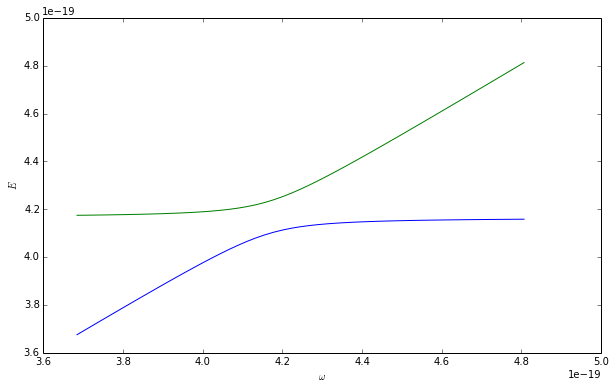

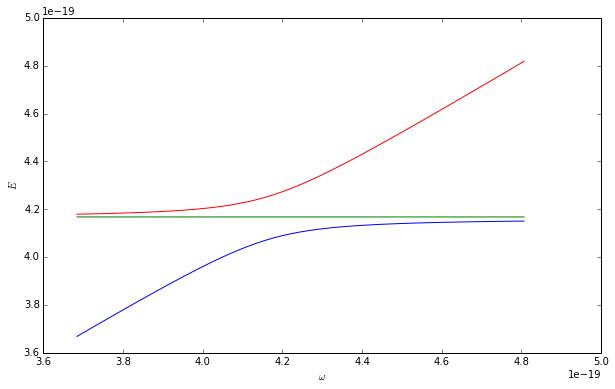

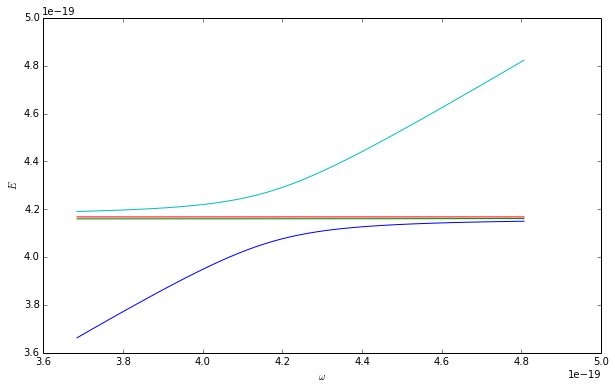

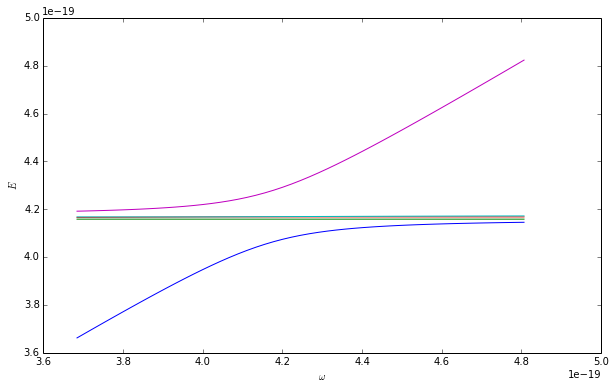

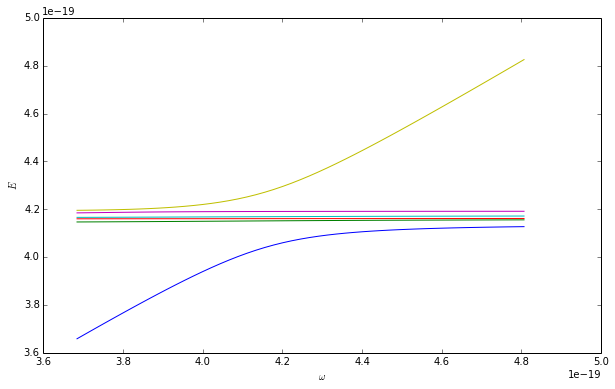

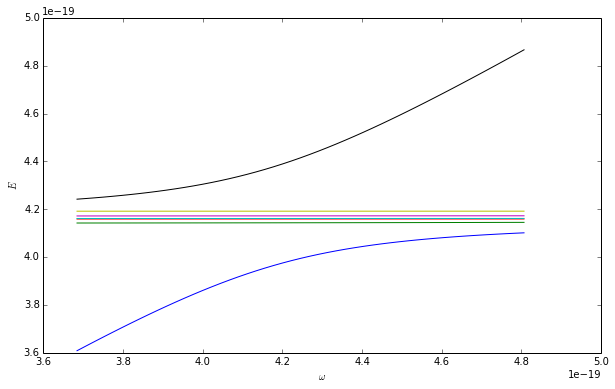

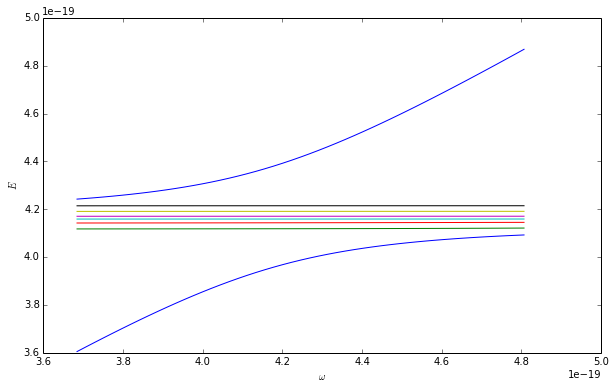

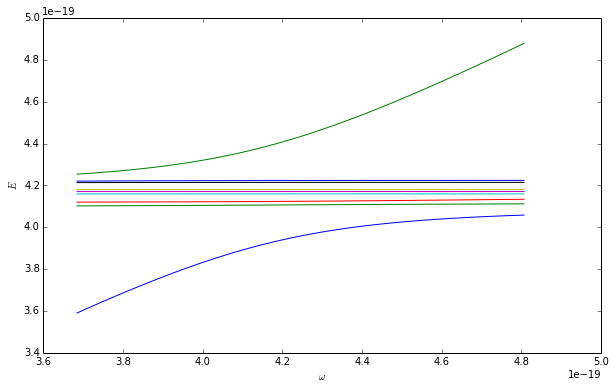

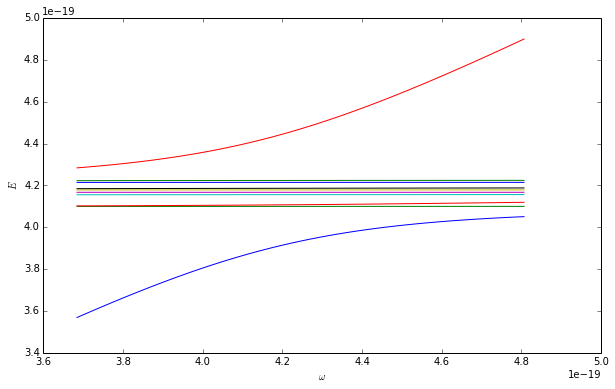

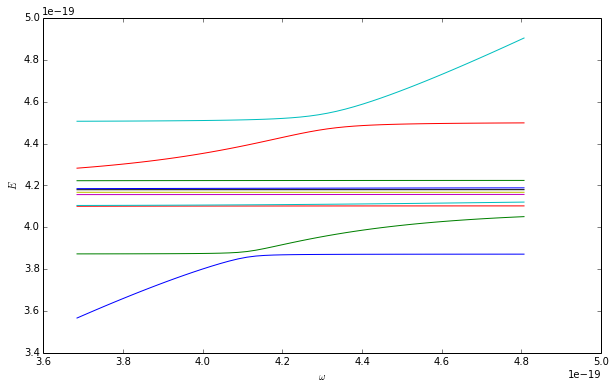

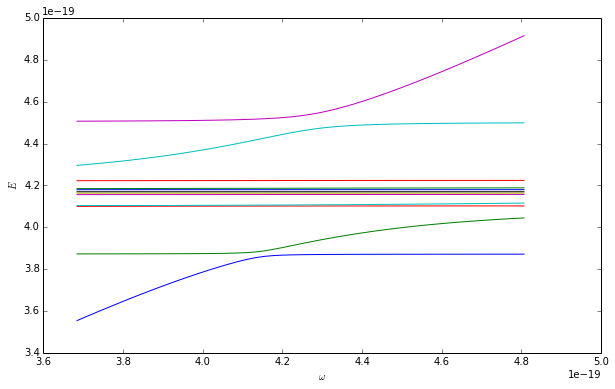

In [12]:
for i in range(K):
    dicke_tryparams_proj(K=i+1, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

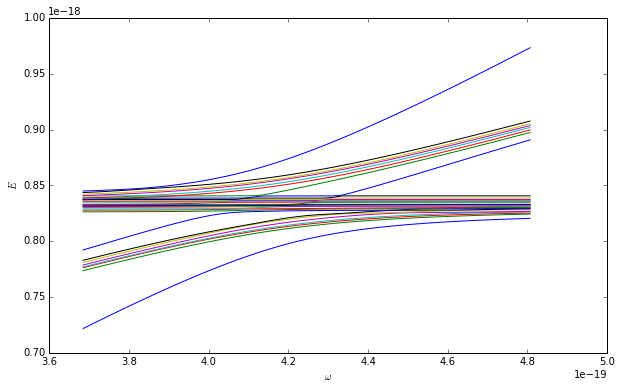

In [17]:
dicke_tryparams(K=7, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=2, bdim=3, dRWA=False)

Plot calculated in  0.548248 s


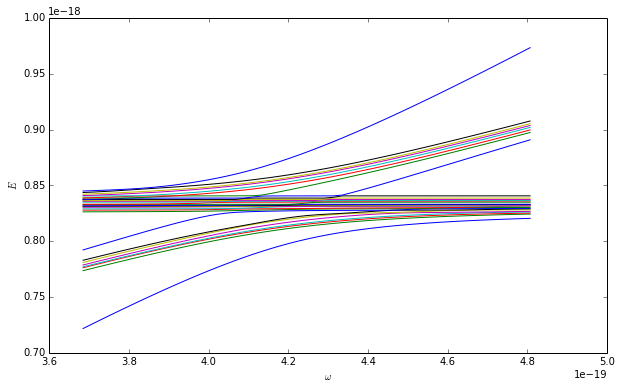

In [18]:
dicke_tryparams_proj(K=7, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=2)

In [19]:
K = 11
poss = randomPositionBox(K=K, x = 2*nm, y = 2*nm, z = 1*nm)
dirs = randomUnitVectors(K=K)
gs = dipoleCouplings(K=K, positions=poss, directions=dirs, mu=2*debye)
Vs = dipoleFieldCouplings(K=K, magnitude = 0.11*eV)
print gs
print Vs

[[], [4.8306841613385647e-22], [1.3139451233668156e-23, -1.9469050564012449e-22], [3.3339158609108409e-23, -1.9759305383834287e-22, 2.6874262665950987e-21], [4.0137324499120181e-23, -6.9532348093409948e-24, -1.266935130216403e-23, -1.0095837914000155e-22], [3.0133119874401875e-23, -6.230913673665083e-23, 7.4982251902434928e-22, 2.7229624622165443e-22, 6.9727119185125632e-23], [5.1818814862767892e-22, -1.8149945994638104e-22, 9.8086096649473481e-23, -2.9944716590378941e-22, -4.2260821251309598e-22, 5.0597616079457068e-23], [5.5309749032908047e-24, 1.4637107961439952e-22, -7.4703462271610749e-23, 1.7179137563651719e-22, 6.3980934167874328e-22, -8.942235784765769e-24, -3.3113628420628678e-22], [6.406065752383435e-22, -2.8828132450112944e-22, 8.9412893827011873e-23, -3.084871445082211e-23, 6.5301685776308428e-22, 6.1778209595269602e-23, -1.8618112520651342e-20, 4.8539304530836231e-21], [9.2777331868442359e-24, -1.0484952434285771e-22, 2.7530945253809482e-21, 1.4413133600576341e-21, -4.1217

/home/necadam1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:71: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  np.sqrt(norms, norms)


Plot calculated in  1.230799 s


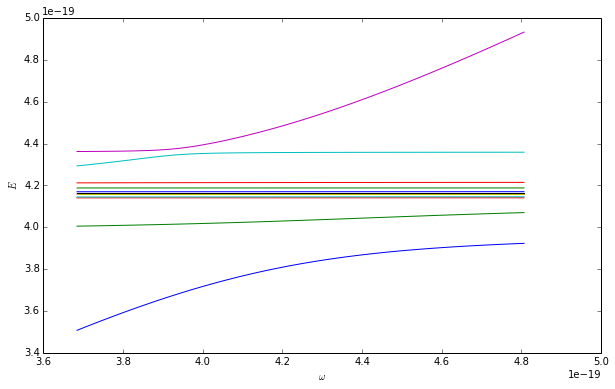

In [20]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=gs, tau=1)

Plot calculated in  1.211051 s


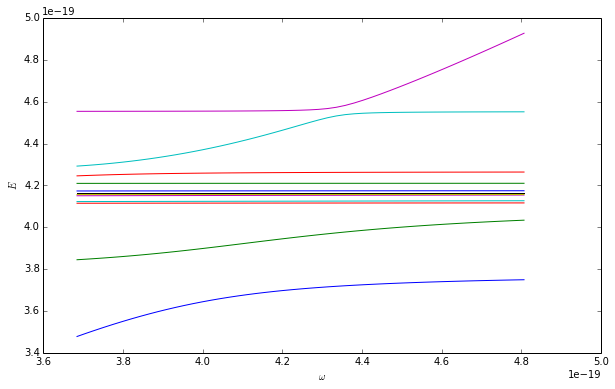

In [29]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=scalegs(gs,2), tau=1)

Plot calculated in  1.193994 s


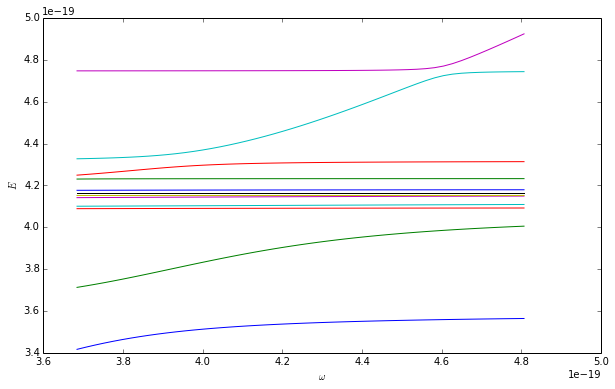

In [30]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=scalegs(gs,3), tau=1)

Plot calculated in  1.750171 s


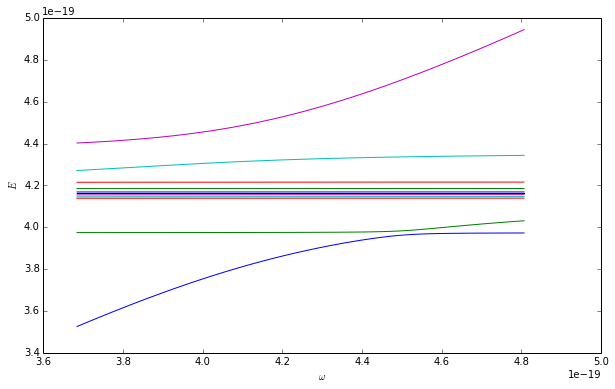

In [34]:
dicke_tryparams_proj(K=11, epsilons=2.6*eV,Vs=Vs, start=2.3*eV, stop=3*eV,gs=absgs(gs), tau=1)

In [34]:
def visualiseDipoles(pos=randomPositionBox(), dirs=randomUnitVectors(),
                     number=False):
    boxDiag = np.linalg.norm(np.amax(pos, axis=0)-np.amin(pos, axis=0))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(pos[...,0],pos[...,1], pos[...,2],
              dirs[...,0],dirs[...,1],dirs[...,2],
             length = boxDiag / 12)
    if(number):
        for i in range(shape(pos)[0]):
            ax.text(pos[i,0],pos[i,1],pos[i,2],'%d' % (i,))
        
    
    

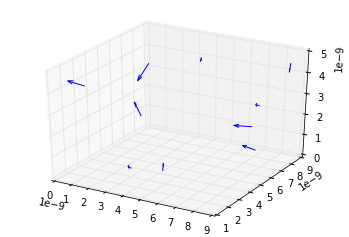

In [36]:
visualiseDipoles()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [29]:
dirs=randomUnitVectors()
pos=randomPositionBox()
shape(pos)

(10, 3)

In [26]:
np.linalg.norm(np.amax(pos, axis=0)-np.amin(pos, axis=0))

1.271476175011982e-08

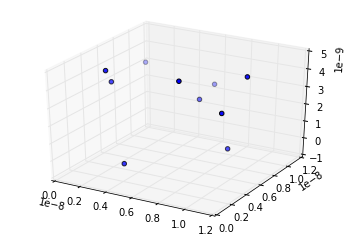

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.quiver(pos[...,0],pos[...,1], pos[...,2],dirs[...,0]*1*nm,dirs[...,1]*1*nm,dirs[...,2]*1*nm)
ax.scatter(pos[...,0],pos[...,1], pos[...,2])

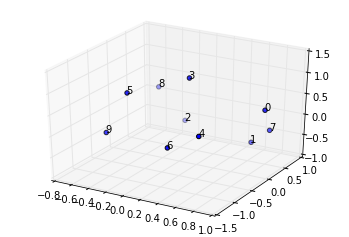

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.quiver(pos[...,0],pos[...,1], pos[...,2],dirs[...,0]*1*nm,dirs[...,1]*1*nm,dirs[...,2]*1*nm)
ax.scatter(dirs[...,0],dirs[...,1], dirs[...,2])
for i in range(10):
    ax.text(dirs[i,0],dirs[i,1],dirs[i,2],'%d' % (i,))
    
    

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', axes='equal')
ax.quiver(pos[...,0],pos[...,1], pos[...,2],dirs[...,0],dirs[...,1],dirs[...,2],length=nm)
for i in range(10):
    ax.text(pos[i,0],pos[i,1],pos[i,2],'%d' % (i,))
ax.scatter(pos[...,0],pos[...,1], pos[...,2])

AttributeError: 'str' object has no attribute 'xaxis'

In [5]:
pos[...,2]

array([  6.49224468e-10,   2.87138765e-09,   2.54502513e-09,
         2.66540738e-09,   4.07744060e-09,   3.57996444e-09,
         3.73849652e-09,   4.12271046e-09,   4.30352786e-09,
         2.00062966e-10])

In [6]:
x = randomUnitVectors()
y = randomUnitVectors()
print x
print y
z=np.cross(x,y)

[[-0.63097635 -0.5407203   0.55631861]
 [ 0.12078907 -0.67749715 -0.72553953]
 [-0.68595873 -0.22235587  0.69283367]
 [ 0.54787143 -0.78990848 -0.27546595]
 [ 0.26961257  0.86695894  0.41915541]
 [ 0.7066424  -0.40414613  0.58079465]
 [ 0.51612119  0.79250355  0.32489545]
 [-0.01420412  0.8389741  -0.54398594]
 [ 0.21439305 -0.77427577  0.59542644]
 [-0.02887411  0.55509171  0.83128784]]
[[ 0.40677092  0.88285143 -0.23475685]
 [ 0.86222689 -0.20729383  0.46216237]
 [ 0.91326152  0.18252103 -0.36419702]
 [ 0.0486534   0.0036559  -0.99880903]
 [-0.5973723   0.16501947  0.78480246]
 [-0.9673141  -0.24984424  0.04337393]
 [ 0.19527534  0.72769573 -0.65751538]
 [-0.37172309  0.80161591  0.46822417]
 [-0.47575987  0.20371866  0.85565838]
 [-0.72314703 -0.3902051  -0.56991083]]


In [34]:
nr=numpy.linalg.norm(z,axis=1)
print z.shape, nr.shape
numpy.linalg.norm(z/nr[:,np.newaxis],axis=1)

(10, 3) (10,)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

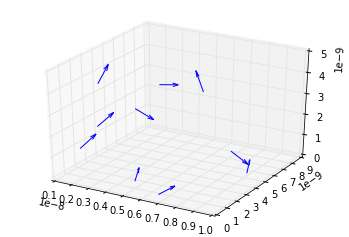

In [114]:
dirs=randomUnitVectors()
pos = randomPositionBox()
d = dir_transitions(begin = dirs, end=np.array([0,0,1]), steps=5)
visualiseDipoles(dirs=dirs, pos=pos)

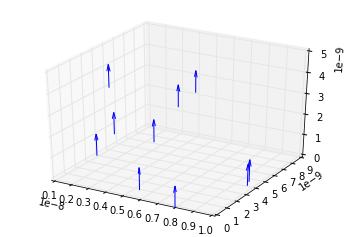

In [120]:
visualiseDipoles(dirs=d.next(), pos=pos)

In [59]:
dirs=randomUnitVectors(1)
z=np.array([0.,0.,1.])

In [63]:
dirs

array([[ 0.12061086, -0.51852574,  0.84651289]])

In [121]:
for d in dir_transitions(dirs,z,steps=10):
    print d

[[-0.50112189  0.13295517  0.8551022 ]
 [ 0.31551072  0.93831033  0.14151575]
 [ 0.365601   -0.45480623  0.81208817]
 [ 0.56551202  0.59769503  0.56829289]
 [ 0.48883806  0.17252189  0.85514534]
 [ 0.76639835  0.30131485 -0.56731203]
 [ 0.64505877  0.54932069 -0.53117414]
 [ 0.46487074 -0.36739579  0.80555293]
 [ 0.57820537  0.54714271  0.6052383 ]
 [ 0.9898279   0.05851332  0.12968006]]
[[-0.45535138  0.12081157  0.88207692]
 [ 0.30587313  0.9096487   0.28103538]
 [ 0.33321027 -0.41451229  0.84684738]
 [ 0.52518824  0.55507644  0.64503291]
 [ 0.44418818  0.15676395  0.88211219]
 [ 0.86223896  0.33899525 -0.37633256]
 [ 0.71599015  0.6097246  -0.33999121]
 [ 0.42388206 -0.33500169  0.84148551]
 [ 0.53533681  0.50657715  0.67586544]
 [ 0.96098579  0.05680833  0.27070116]]
[[-0.40822845  0.10830914  0.90643183]
 [ 0.29000181  0.86244833  0.41482748]
 [ 0.29952636 -0.37260964  0.87832   ]
 [ 0.47996374  0.50727823  0.71575387]
 [ 0.39821945  0.14054055  0.90645994]
 [ 0.91748675  0.360716

In [112]:
np.sum(np.multiply(dirs,z),axis=1) < 0

array([False, False, False, False, False,  True,  True, False, False, False], dtype=bool)

In [97]:
np.pi

3.141592653589793